In [1]:
# pip install pvlib # Установка библиотеки PVLIB
# pip install ephem # Установка библиотеки ephem - для выполнения высокоточных астрономических расчетов
# pip install NREL-PySAM # Установка библиотеки NREL-PySAM - для определения параметров мат. модели ФЭМ CEC

                    # Эта ячейка выполняется только один раз!!!

In [2]:
# импорт библиотеки для построения графиков
import matplotlib.pyplot as plt
%matplotlib inline
    
# Импорт библиотеки для работы с датой-временем
import datetime

# Импорт библиотеки для работы с табличными данными
import pandas as pd

# Импорт библиотеки для моделирования фотоэлектрических систем
import pvlib

# Импорт библиотеки, необходимой для промежуточных расчётов при определении заатмосферной солнечной радиации методом pyephem
import ephem

# Импорт библиотеки для осуществления HTTP-запросов
import requests

# Импорт библиотеки для работы с математическими функциями
import math

# импортируем библиотеку для работы с массивами
import numpy as np

C:\Users\vag\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Характеристика месторасположения

Класс ``pvlib.location.Location(latitude, longitude, tz='UTC', altitude=0, name=None, **kwargs)``
предоставляет возможность создавать Объекты местоположения ``Location`` - удобные контейнеры для данных о широте, долготе, часовом поясе и высоте над уровнем моря, связанных с конкретным географическим местоположением. Вы также можете назначить имя объекту местоположения.

### Параметры
- ``latitude`` (float.) – Широта местноти. Положительные значения для северной широты; отрицательные - для южной;
- ``longitude`` (float.) – Долгота местности. Положительные значения для восточной долготы; отрицательные - для западной;
- ``tz`` (str, int, float, или pytz.timezone, по умолчанию 'UTC'.) – См. http://en.wikipedia.org/wiki/List_of_tz_database_time_zones для изучения списка действующих часовых поясов;
- ``altitude`` (float, default 0.) – Высота над уровнем моря в метрах;
- ``name`` (None or string, default None.) – Имя объекта местоположения;
- ``kwargs`` - не используется.

In [3]:
# Создадим Объект местоположения, соответствующий Москве
A = pvlib.location.Location(
    55.4, 
    37.4, 
    tz='Europe/Moscow', 
    altitude=156, 
    name='Moscow')
A

Location: 
  name: Moscow
  latitude: 55.4
  longitude: 37.4
  altitude: 156
  tz: Europe/Moscow

In [4]:
# Определение периода моделирования
times = pd.date_range(start=datetime.datetime(2025,1,1), # Момент начала периода моделирования
             end=datetime.datetime(2025,12,31,23), # Момент окончания периода моделирования
             freq='1h') # Дискретность моделирования
times

DatetimeIndex(['2025-01-01 00:00:00', '2025-01-01 01:00:00',
               '2025-01-01 02:00:00', '2025-01-01 03:00:00',
               '2025-01-01 04:00:00', '2025-01-01 05:00:00',
               '2025-01-01 06:00:00', '2025-01-01 07:00:00',
               '2025-01-01 08:00:00', '2025-01-01 09:00:00',
               ...
               '2025-12-31 14:00:00', '2025-12-31 15:00:00',
               '2025-12-31 16:00:00', '2025-12-31 17:00:00',
               '2025-12-31 18:00:00', '2025-12-31 19:00:00',
               '2025-12-31 20:00:00', '2025-12-31 21:00:00',
               '2025-12-31 22:00:00', '2025-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq='h')

In [5]:
# "Локализация" моентов времени
times_loc = times.tz_localize(tz=A.tz)
times_loc

DatetimeIndex(['2025-01-01 00:00:00+03:00', '2025-01-01 01:00:00+03:00',
               '2025-01-01 02:00:00+03:00', '2025-01-01 03:00:00+03:00',
               '2025-01-01 04:00:00+03:00', '2025-01-01 05:00:00+03:00',
               '2025-01-01 06:00:00+03:00', '2025-01-01 07:00:00+03:00',
               '2025-01-01 08:00:00+03:00', '2025-01-01 09:00:00+03:00',
               ...
               '2025-12-31 14:00:00+03:00', '2025-12-31 15:00:00+03:00',
               '2025-12-31 16:00:00+03:00', '2025-12-31 17:00:00+03:00',
               '2025-12-31 18:00:00+03:00', '2025-12-31 19:00:00+03:00',
               '2025-12-31 20:00:00+03:00', '2025-12-31 21:00:00+03:00',
               '2025-12-31 22:00:00+03:00', '2025-12-31 23:00:00+03:00'],
              dtype='datetime64[ns, Europe/Moscow]', length=8760, freq=None)

## Solar Position Algoritm (SPA) - Определение положения Солнца на небосводе

Функция ``pvlib.solarposition.spa_python``(time, latitude, longitude, altitude=0, pressure=101325, temperature=12, delta_t=67.0, atmos_refract=None, how='numpy', numthreads=4, **kwargs) позволяет рассчитывать положение Солнца на небосводе, используя реализацию алгоритма NREL SPA.

### Параметры
- `time ()` - время (можно задать местное (поясное) или UTC);
- `latitude (float.)` – Широта местности. Положительные значения для северной широты; отрицательные - для южной;
- `longitude (float.)` – Долгота местности. Положительные значения для восточной долготы; отрицательные - для западной;
- `altitude (float, default 0)` – Высота над уровнем моря в метрах;
- `pressure (float, default 101325)` – Среднегодовая величина давления воздуха, Па;
- `temperature (float, default 12)` - Среднегодовая величина температуры воздуха, C;
- `delta_t (float, optional, default 67.0)` - Разница между земным динамическим временем и всемирным временем UT;
- `atmos_refract (None or float, optional, default None)` – атмосферная рефракция;
- `how (str, optional, default 'numpy')` – м.б. ‘numpy’ или ‘numba’ - используемая математическая библиотека;
- `numthreads (int, optional, default 4)` – Количество используемых потоков (при использовании библиотеки ‘numba’);
 
 
### Результаты:
DataFrame - таблица pandas со столбцами:	
- `apparent_zenith` - видимый зенитный угол (градусы);
- `zenith` - зенитный угол (градусы);
- `apparent_elevation` - видимая высота Солнца (градусы);
- `elevation` - высота Солнца (градусы);
- `azimuth` - азимутальный угол (градусы);
- `equation_of_time` - уравнение_времени (минуты)

In [6]:
SPA = pvlib.solarposition.spa_python(times_loc, 
                                     A.latitude, 
                                     A.longitude, 
                                     altitude=A.altitude)
SPA

apparent_zenith      zenith  apparent_elevation  \
2025-01-01 00:00:00+03:00       147.008542  147.008542          -57.008542   
2025-01-01 01:00:00+03:00       147.243411  147.243411          -57.243411   
2025-01-01 02:00:00+03:00       143.885336  143.885336          -53.885336   
2025-01-01 03:00:00+03:00       137.867054  137.867054          -47.867054   
2025-01-01 04:00:00+03:00       130.296023  130.296023          -40.296023   
...                                    ...         ...                 ...   
2025-12-31 19:00:00+03:00       112.479994  112.479994          -22.479994   
2025-12-31 20:00:00+03:00       120.968736  120.968736          -30.968736   
2025-12-31 21:00:00+03:00       129.322390  129.322390          -39.322390   
2025-12-31 22:00:00+03:00       137.019382  137.019382          -47.019382   
2025-12-31 23:00:00+03:00       143.283422  143.283422          -53.283422   

                           elevation     azimuth  equation_of_time  
2025-01-01 00:00:00+03:00 -57.008542  345.625175         -3.379598  
2025-01-01 01:00:00+03:00 -57.243411   11.188050         -3.399348  
2025-01-01 02:00:00+03:00 -53.885336   34.993610         -3.419089  
2025-01-01 03:00:00+03:00 -47.867054   54.778135         -3.438820  
2025-01-01 04:00:00+03:00 -40.296023   70.905231         -3.458542  
...                              ...         ...               ...  
2025-12-31 19:00:00+03:00 -22.479994  261.591302         -3.169379  
2025-12-31 20:00:00+03:00 -30.968736  273.786408         -3.189085  
2025-12-31 21:00:00+03:00 -39.322390  287.248563         -3.208782  
2025-12-31 22:00:00+03:00 -47.019382  303.008771         -3.228469  
2025-12-31 23:00:00+03:00 -53.283422  322.292170         -3.248147  

[8760 rows x 6 columns]

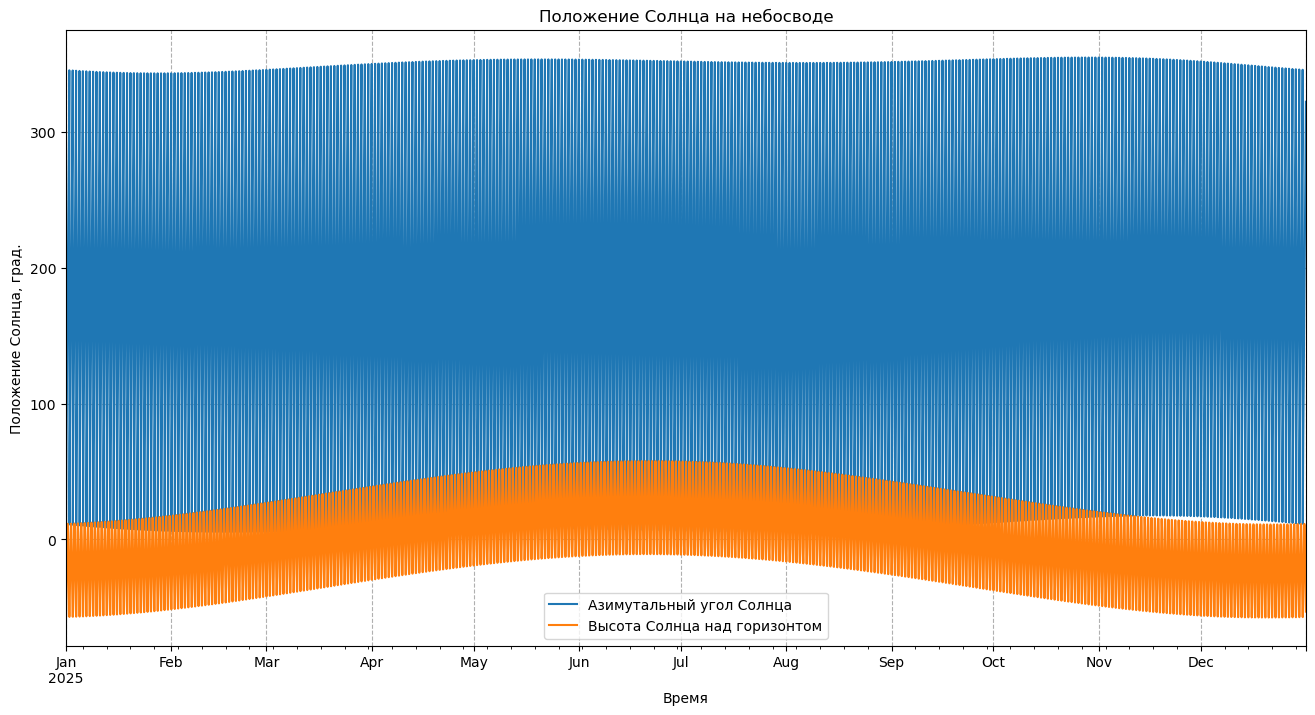

In [7]:
SPA['azimuth'].plot(label='Азимутальный угол Солнца', figsize=(16, 8))
SPA['elevation'].plot(label='Высота Солнца над горизонтом')
plt.grid(linestyle='--')
plt.legend()
plt.ylabel('Положение Солнца, град.')
plt.xlabel('Время')
plt.title('Положение Солнца на небосводе')
plt.show()

In [8]:
# Данные можно выгрузить в csv-файл
#SPA.to_csv('SPA.csv')

# Солнечное излучение на верхней границе атмосферы
Extraterrestrial radiation

Многие гелиоэнергетические расчёты начинаются с вычисления солнечного излучения на верхней границе земной атмосферы. В библиотеке pvlib доступны четыре различных алгоритма для расчёта солнечного излучения на верхней границе земной атмосферы с учетом солнечной постоянной: ``pyephem``, ``nrel``, ``spencer`` и ``asce``.

## Определение солнечного излучения на верхней границе атмосферы для заданной даты

Модуль ``pvlib.irradiance.get_extra_radiation``(datetime_or_doy, solar_constant=1366.1, method='spencer', epoch_year=2014) позволяет определить солнечное излучение на верхней границе атмосферы для заданной даты года:


### Параметры
* ``datetime_or_doy (numeric, array, date, datetime, Timestamp, DatetimeIndex)`` – Номер дня в году, заданный период года, дата или datetime-like объект.
* ``solar_constant (float, default 1366.1)`` – Солнечная постоянная, [$Вт/м^2$].
* ``method (string, default 'spencer')`` – Метод расчёта солнечного излучения на верхней границе атмосферы. Могут использоваться методы: 'pyephem', 'spencer', 'asce', 'nrel'. Подробнее про метод ``spencer`` (используется по умолчанию) можно прочитать здесь: J. W. Spencer, “A comparison of methods for estimating hourly diffuse solar radiation from global solar radiation”, Sol.Energy29, 19‐32 (1982). https://www.mail-archive.com/sundial@uni-koeln.de/msg01050.html
* ``epoch_year (int, default 2014)`` – Расчётный год. Необходимо указывать только при использовании методов pyephem и nrel.
* ``kwargs`` – Учёт положения солнца на небосводе с помошью модуля ``solarposition.nrel_earthsun_distance``.

### Результаты
* ``dni_extra (float, array, or Series)`` – Величина солнечного излучения на верхней границе атмосферы в Ваттах на квадратный метр поверхности, перпендикулярной солнечным лучам, [$Вт/м^2$]. Входные данные  в формате Pandas Timestamp или DatetimeIndex приведут к результатам в формате Pandas TimeSeries, т.е. будет получен массив данных за заданный период времени. Все остальные типы входные данные в результате приведут к числу с плавающей точкой или массиву с плавающей точкой.

### Список использованных источников    
    [1] M. Reno, C. Hansen, and J. Stein, “Global Horizontal Irradiance Clear Sky Models: Implementation and Analysis”, Sandia National Laboratories, SAND2012-2389, 2012. https://prod-ng.sandia.gov/techlib-noauth/access-control.cgi/2012/122389.pdf
    
    [2] http://solardat.uoregon.edu/SolarRadiationBasics.html, Eqs. SR1 and SR2
    
    [3] Partridge, G. W. and Platt, C. M. R. 1976. Radiative Processes in Meteorology and Climatology.
    
    [4] Duffie, J. A. and Beckman, W. A. 1991. Solar Engineering of Thermal Processes, 2nd edn. J. Wiley and Sons, New York.
    
    [5] ASCE, 2005. The ASCE Standardized Reference Evapotranspiration Equation, Environmental and Water Resources Institute of the American Civil Engineers, Ed. R. G. Allen et al. 

In [9]:
DNI_extra = pvlib.irradiance.get_extra_radiation(times_loc, # Расчёт методом Specer
                                                 solar_constant=1366.1, 
                                                 method='spencer')
DNI_extra2 = pvlib.irradiance.get_extra_radiation(times_loc, # Расчёт методом ASCE
                                                  solar_constant=1366.1, 
                                                  method='asce')
DNI_extra3 = pvlib.irradiance.get_extra_radiation(times_loc, 
                                                  solar_constant=1366.1, 
                                                  method='nrel', # Расчёт методом NREL
                                                  epoch_year=2024)
DNI_extra4 = pvlib.irradiance.get_extra_radiation(times_loc, 
                                                  solar_constant=1366.1, 
                                                  method='pyephem', # Расчёт методом pyEphem
                                                  epoch_year=2024)

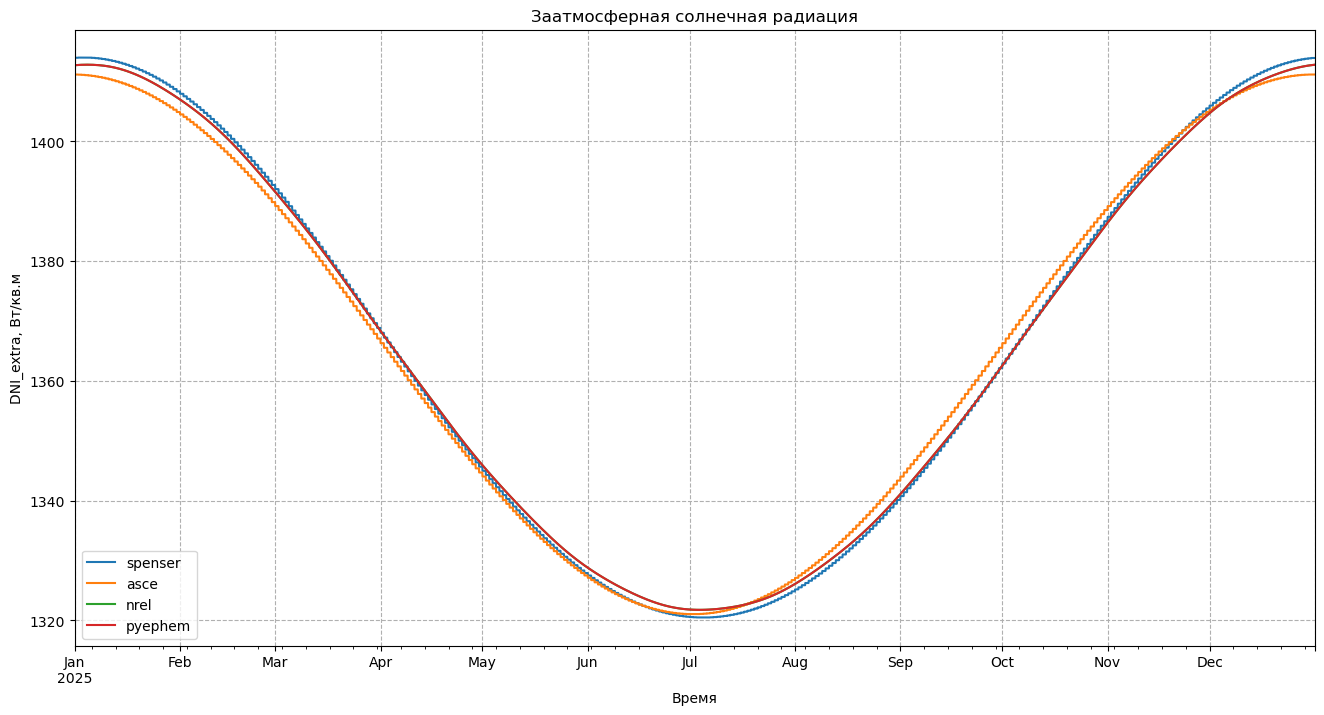

In [10]:
DNI_extra.plot(label='spenser', figsize=(16, 8))
DNI_extra2.plot(label='asce')
DNI_extra3.plot(label='nrel')
DNI_extra4.plot(label='pyephem')
plt.grid(linestyle='--')
plt.legend()
plt.ylabel('DNI_extra, Вт/кв.м')
plt.xlabel('Время')
plt.title('Заатмосферная солнечная радиация')
plt.show()

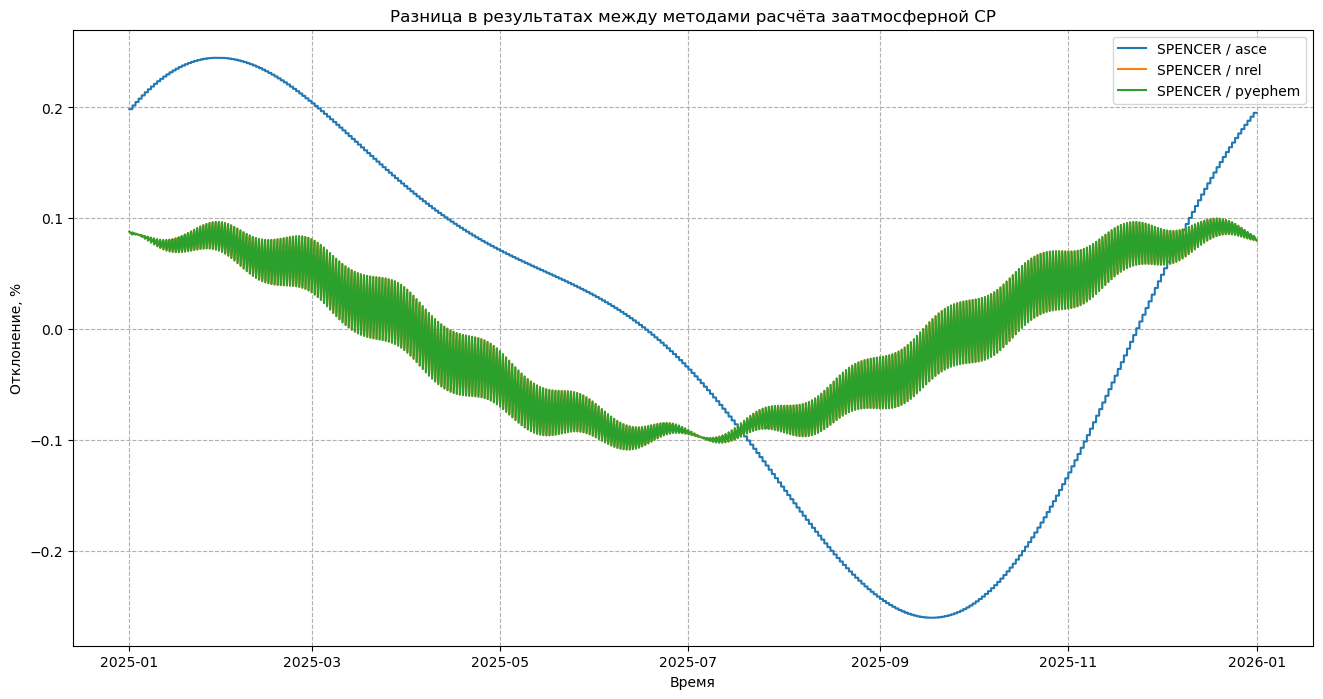

In [11]:
err2 = (DNI_extra - DNI_extra2) / DNI_extra * 100
err3 = (DNI_extra - DNI_extra3) / DNI_extra * 100
err4 = (DNI_extra - DNI_extra4) / DNI_extra * 100
plt.figure(figsize=(16, 8))
plt.plot(times_loc, err2, label='SPENCER / asce')
plt.plot(times_loc, err3, label='SPENCER / nrel')
plt.plot(times_loc, err4, label='SPENCER / pyephem')
plt.grid(linestyle='--')
plt.legend()
plt.ylabel('Отклонение, %')
plt.xlabel('Время')
plt.title('Разница в результатах между методами расчёта заатмосферной СР')
plt.show()

# 2 Солнечное излучение, падающее на горизонтальную поверхность

## 2.1 Простейшие модели для определения суммарного солнечного излучения на горизонтальной поверхности в ясный день

Самые простые модели ясного неба являются таковыми, потому что они используют только геометрические вычисления. Ослабление внеземного нормального падающего излучения (I0) во время прохождения через атмосферу является функцией зенитного угла, причем более высокие зенитные углы приводят к увеличению атмосферной массы воздуха (AM) и большему взаимодействию между солнечной радиацией и атмосферой. Эти очень простые модели ясного неба - это, по сути, эмпирические корреляции, основанные на измерениях местоположения объекта и астрономических параметров. Из-за этого следует соблюдать осторожность при применении очень простых моделей в местах, отличных от тех, которые используются для калибровки модели. Ниже приведен список некоторых из опубликованных очень простых моделей ясного неба.

### Модуль ``pvlib.clearsky.simplified_solis``

Модуль ``pvlib.clearsky.simplified_solis(apparent_elevation, aod700=0.1, precipitable_water=1.0, pressure=101325.0, dni_extra=1364.0)`` позволяет рассчитать GHI, DNI, и DHI для ясного неба с использованием простейшей модели [1].
В [1] точность модели характеризуется как 15, 20 и 18 Вт/ м^2 для GHI, DNI, и DHI составляющих. В [2] приведено сравнение с другими моделями ясного неба.

### Параметры:	
- ``apparent_elevation (numeric)`` – Кажущаяся (apparent elevation) высота солнца над горизонтом (град).
- ``aod700 (numeric, default 0.1)`` – Оптическая глубина аэрозоля при 700 нм (без единиц измерения). Алгоритм, полученный для значений от 0 до 0,45.
- ``precipitable_water (numeric, default 1.0)`` – Осаждаемая вода атмосферы (см). Алгоритм выведен для значений от 0,2 до 10 см. Значения менее 0,2 будут приниматься равными 0,2.
- ``pressure (numeric, default 101325.0)`` – Атмосферное давление (Паскаль). Алгоритм, полученный для высот между уровнем моря и 7000 м, или 101325 и 41000 Паскалей.
- ``dni_extra (numeric, default 1364.0)`` – Внеземное излучение. Единицы dni_extra определяют единицы вывода.

### Результаты:	
- ``clearsky (DataFrame (if Series input) or OrderedDict of arrays)`` – DataFrame/OrderedDict содержащий столбцы 'dhi', 'dni', 'ghi'.

### Примечания:
- GHI - Global Horizontal Irradiance - Суммарная солнечная радиация на горизонтальной поверхности
- DNI - Direct Normal Irradiance - Прямая солнечная радиация на поверхности, перпендикулярной солнечному излучению
- DHI - Diffuse Horizontal Irradiation - Диффузная солнечная радиация на горизонтальной поверхности

### Список использованных источников:

[1]	(1, 2) P. Ineichen, “A broadband simplified version of the Solis clear sky model,” Solar Energy, 82, 758-762 (2008).

[2]	P. Ineichen, “Validation of models that estimate the clear sky global and beam solar irradiance,” Solar Energy, 132, 332-344 (2016).

In [12]:
VerySimpleClearSky = pvlib.clearsky.simplified_solis(SPA['apparent_elevation'], 
                                                     aod700=0.1, 
                                                     precipitable_water=1.0, 
                                                     pressure=101325.0, 
                                                     dni_extra=DNI_extra)
VerySimpleClearSky

ghi  dni  dhi
2025-01-01 00:00:00+03:00  0.0  0.0  0.0
2025-01-01 01:00:00+03:00  0.0  0.0  0.0
2025-01-01 02:00:00+03:00  0.0  0.0  0.0
2025-01-01 03:00:00+03:00  0.0  0.0  0.0
2025-01-01 04:00:00+03:00  0.0  0.0  0.0
...                        ...  ...  ...
2025-12-31 19:00:00+03:00  0.0  0.0  0.0
2025-12-31 20:00:00+03:00  0.0  0.0  0.0
2025-12-31 21:00:00+03:00  0.0  0.0  0.0
2025-12-31 22:00:00+03:00  0.0  0.0  0.0
2025-12-31 23:00:00+03:00  0.0  0.0  0.0

[8760 rows x 3 columns]

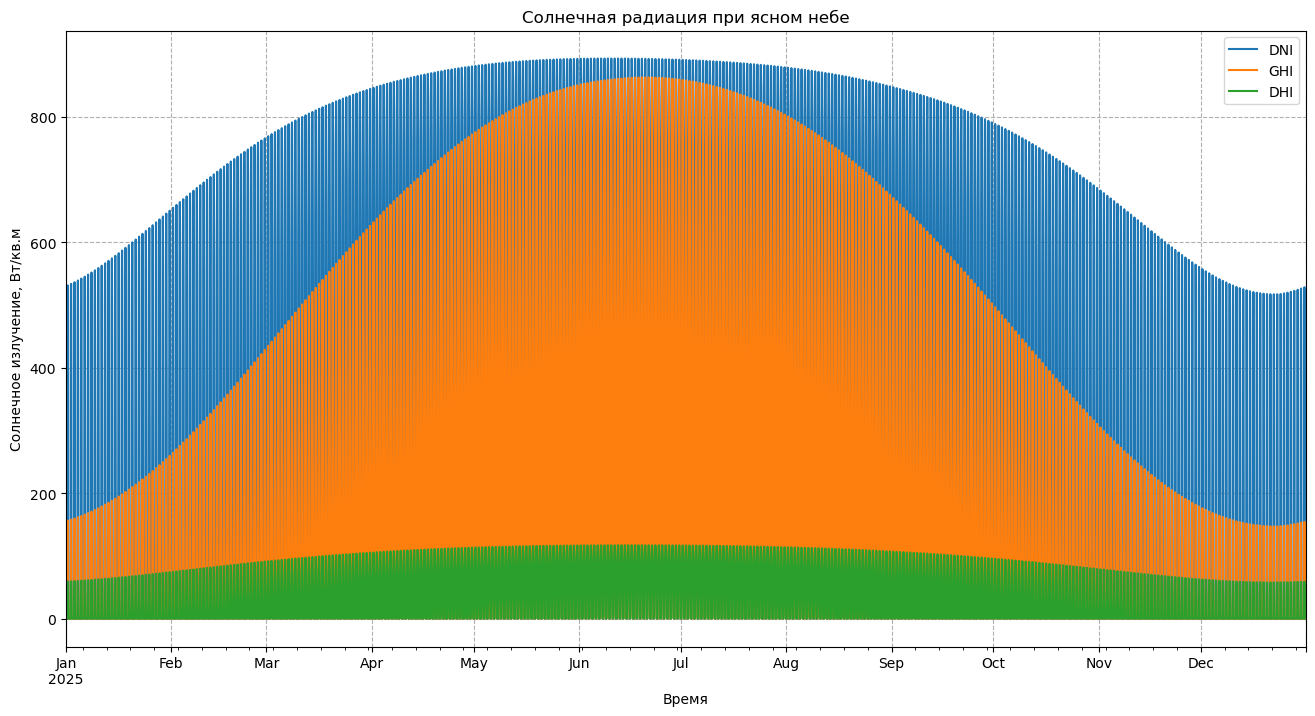

In [13]:
VerySimpleClearSky['dni'].plot(label='DNI', figsize=(16, 8)) # dni - direct normal irradiation, DNI
VerySimpleClearSky['ghi'].plot(label='GHI', figsize=(16, 8)) # ghi - global horizontal irradiation, GHI
VerySimpleClearSky['dhi'].plot(label='DHI', figsize=(16, 8)) # dhi - diffuse horizontal irradiation, DHI
plt.grid(linestyle='--')
plt.legend()
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Время')
plt.title('Солнечная радиация при ясном небе')
plt.show()

## 2.2 Простые модели для определения суммарного солнечного излучения на горизонтальной поверхности в ясный день

Следующая категория моделей - это простые модели ясного неба, которые включают, помимо зенитного угла, некоторые основные параметры состояния атмосферы, такие как давление воздуха, температура, относительная влажность, содержание аэрозоля и рэлеевское рассеяние.

Модуль ``pvlib.clearsky.ineichen(apparent_zenith, airmass_absolute, linke_turbidity, altitude=0, dni_extra=1364.0, perez_enhancement=False)`` позволяет определить GHI, DNI и DHI при ясном небе по модели Ineichen/Perez.
Модель чистого неба Ineichen и Perez для суммарного солнечного излучения на горизонтальной поверхности (GHI), прямого нормального излучения (DNI) и компоненты рассеянного горизонтального освещения (DHI) в виде разницы между GHI и DNI * cos (зенит), как представлено в [1, 2]. Отчет о моделях ясного неба обнаружил, что модель Инейхена / Переса имеет отличные характеристики с минимальным набором входных данных [3].

Значения по умолчанию для месячной мутности Линке предоставлены SoDa [4, 5].
 
### Параметры:	
- ``apparent_zenith`` (numeric) – Кажущийся (apparent zenith) зентиный угол солнца(град).
- ``airmass_absolute`` (numeric) – Атмосферная масса с учетом давления.
- ``linke_turbidity`` (numeric) – Linke Turbidity.
- ``altitude`` (numeric, default 0) – Высота над уровнем моря (м).
- ``dni_extra`` (numeric, default 1364) – Внеземное излучение. Единицы dni_extra определяют единицы вывода.
- ``perez_enhancement`` (bool, default False) – Параметр контролирует, следует ли применять коэффициент усиления Perez. Установка в True может привести к ложным результатам в те времена, когда Солнце приближается к горизонту, а воздушная масса высока. Подробности см.: https://github.com/pvlib/pvlib-python/issues/435

### Результаты:	
- ``clearsky`` (DataFrame (if Series input) or OrderedDict of arrays) – DataFrame/OrderedDict contains the columns/keys 'dhi', 'dni', 'ghi'.

### Список использованных источников:

[1]	P. Ineichen and R. Perez, “A New airmass independent formulation for the Linke turbidity coefficient”, Solar Energy, vol 73, pp. 151-157, 2002.

[2]	R. Perez et. al., “A New Operational Model for Satellite-Derived Irradiances: Description and Validation”, Solar Energy, vol 73, pp. 307-317, 2002.

[3]	M. Reno, C. Hansen, and J. Stein, “Global Horizontal Irradiance Clear Sky Models: Implementation and Analysis”, Sandia National Laboratories, SAND2012-2389, 2012.

[4]	http://www.soda-is.com/eng/services/climat_free_eng.php#c5 (obtained July 17, 2012).

[5]	J. Remund, et. al., “Worldwide Linke Turbidity Information”, Proc. ISES Solar World Congress, June 2003. Goteborg, Sweden.

In [14]:
# Определение относительной атмосферной массы
airmass_relative = pvlib.atmosphere.get_relative_airmass(SPA['zenith'], model='simple')
# Определение абсолютной атмосферной массы
airmass_absolute = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure=101325.0)
# Определение турбуленции Линке
linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times_loc, 
                                      A.latitude, 
                                      A.longitude, 
                                      filepath=None, 
                                      interp_turbidity=True)
# Моделирование составляющих солнечного излучения для условий ясного неба
SimpleClearSky = pvlib.clearsky.ineichen(SPA['apparent_zenith'], 
                                         airmass_absolute, 
                                         linke_turbidity, 
                                         altitude=A.altitude, 
                                         dni_extra=DNI_extra, 
                                         perez_enhancement=False)
SimpleClearSky

ghi  dni  dhi
2025-01-01 00:00:00+03:00  0.0  0.0  0.0
2025-01-01 01:00:00+03:00  0.0  0.0  0.0
2025-01-01 02:00:00+03:00  0.0  0.0  0.0
2025-01-01 03:00:00+03:00  0.0  0.0  0.0
2025-01-01 04:00:00+03:00  0.0  0.0  0.0
...                        ...  ...  ...
2025-12-31 19:00:00+03:00  0.0  0.0  0.0
2025-12-31 20:00:00+03:00  0.0  0.0  0.0
2025-12-31 21:00:00+03:00  0.0  0.0  0.0
2025-12-31 22:00:00+03:00  0.0  0.0  0.0
2025-12-31 23:00:00+03:00  0.0  0.0  0.0

[8760 rows x 3 columns]

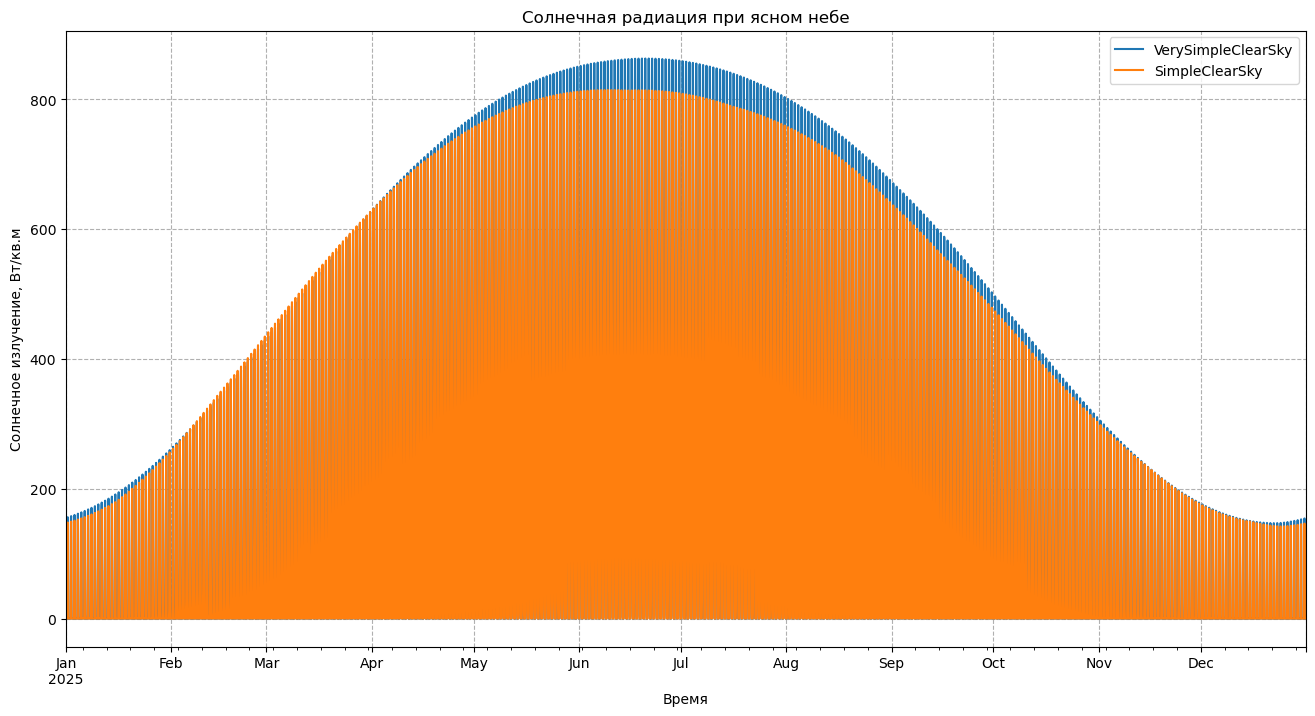

In [15]:
VerySimpleClearSky['ghi'].plot(label='VerySimpleClearSky', figsize=(16, 8))
SimpleClearSky['ghi'].plot(label='SimpleClearSky')
plt.grid(linestyle='--')
plt.legend()
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Время')
plt.title('Солнечная радиация при ясном небе')
plt.show()

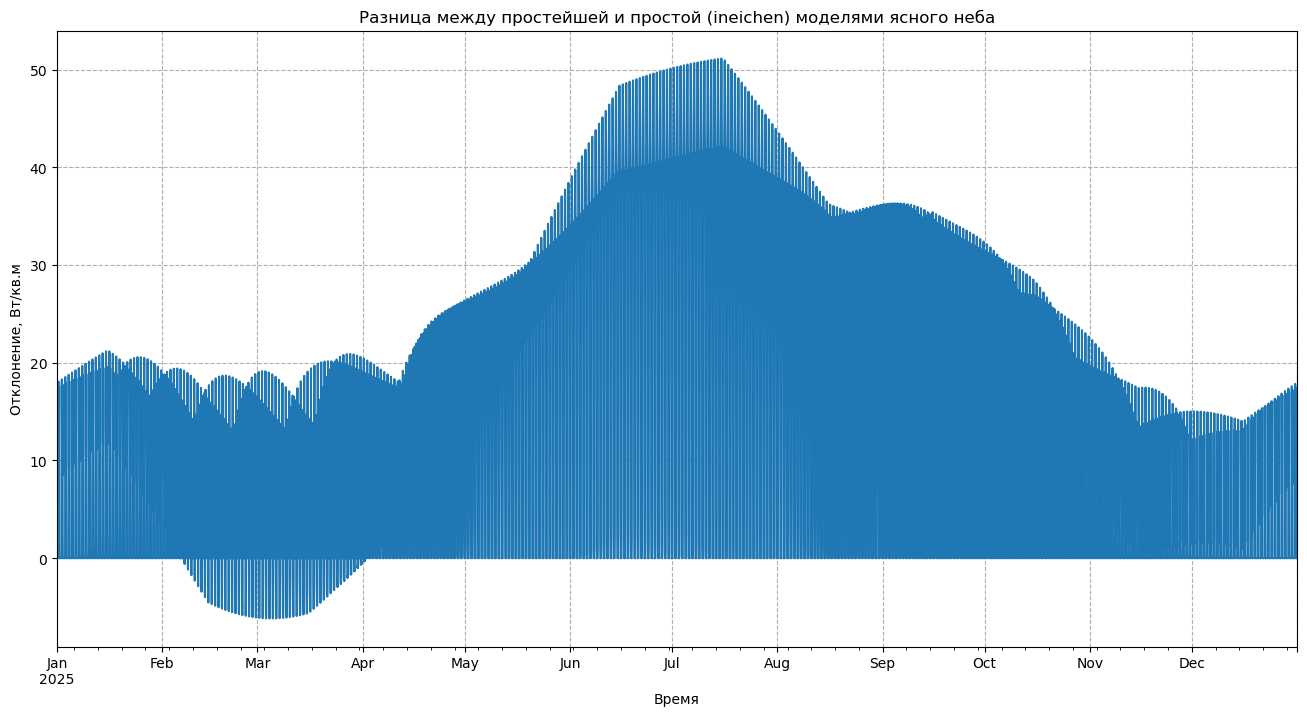

In [16]:
eps = VerySimpleClearSky['ghi'] - SimpleClearSky['ghi']
eps.plot(figsize=(16, 8))
plt.grid(linestyle='--')
plt.ylabel('Отклонение, Вт/кв.м')
plt.xlabel('Время')
plt.title('Разница между простейшей и простой (ineichen) моделями ясного неба')
plt.show()

## 2.3 Получение данных из БД PVGIS

Использование моделей ясного неба допустимо только в условиях полного отсутствия актинометрической информации!
При любой возможности целесообразно использовать внешние специализированные информационные источники. Напрмиер такие, как PVGIS, NASA SSE, региональные базы данных

Функция `pvlib.iotools.get_pvgis_hourly(latitude, longitude, start=None, end=None, raddatabase=None, components=True, surface_tilt=0, surface_azimuth=180, outputformat='json', usehorizon=True, userhorizon=None, pvcalculation=False, peakpower=None, pvtechchoice='crystSi', mountingplace='free', loss=0, trackingtype=0, optimal_surface_tilt=False, optimalangles=False, url='https://re.jrc.ec.europa.eu/api/', map_variables=True, timeout=30)` позволяет получить часовые суммы солнечного излучения и оценочные значения выработки энергии фотоэлектрической системой из геоинформационной системы PVGIS.

Данные PVGIS находятся в свободном доступе по адресу [1].

### Параметры:
- `latitude` (float) – Широта местности (в соответствии с ISO 19115).
- `longitude` (float) – Долгота местности (в соответствии с ISO 19115).
- `start` (int or datetime like, optional) – Начало (первый год) запрашиваемого временного ряда. По умолчанию задаётся первый из доступных в базе данных.
- `end` (int or datetime like, optional) – Конец (последний год) запрашиваемого временного ряда. По умолчанию задаётся последний из доступных в базе данных.
- `raddatabase` (str, optional) – Название базы данных из которой будут получены данные. Доступность данных зависит от заданного месторасположения, подробности см. в [3].
- `components` (bool, default: True) – Если параметр равен True, то будут возвращены составляющие солнечной радиации (прямое (beam), диффузное (diffuse) и отражённое (reflected) излучение). Если параметр установить равным False, то буде возвращено лишь значение суммарной солнечной радиации.
- `surface_tilt` (float, default: 0) – Угол наклона приёмной поверхности к горизонту. Игнорируется, если рассчитывается система слежения за Солнцем.
- `surface_azimuth` (float, default: 180) – Ориентация приёмной поверности по азимуту. Отсчитывается от севера (север=0, восток=90, юг=180, запад=270).
- `usehorizon` (bool, default: True) – Учитывает (true) или нецчитывает (false) влияние атмосыеры в пригоризонтальной области
- `userhorizon` (list of float, optional) – Необязательный параметр, в котором пользователем указывается высота горизонта в градусах, на равном расстоянии по азимуту по часовой стрелке от севера. Параметр учитывается только в том случае, если `usehorizon` имеет значение true. Если `usehorizon` имеет значение true, но `userhorizon` не указан, тогда PVGIS вычислит горизонт с высотой 4 градуса.
- `pvcalculation` (bool, default: False) – Если параметр имеет значение true, то функциярассчитает выработку электроэнергии СЭС с заданными ниже параметрами.
- `peakpower` (float, optional) – Номинальная мощность СЭС в кВт. Учитывается только если параметр `pvcalculation` = True.
- `pvtechchoice` ({'crystSi', 'CIS', 'CdTe', 'Unknown'}, default: 'crystSi') – Технология производства ФЭМ.
- `mountingplace` ({'free', 'building'}, default: free) – Способ монтажа ФЭМ. Может принимать два варианта значения: ‘free’ в случае размещения на открытой поверхности; ‘building’ для интегрируемых в задание ФЭМ.
- `loss` (float, default: 0) – Суммарная величина потерь энрегии в СЭС, задаётся в процентах.
- `trackingtype` ({0, 1, 2, 3, 4, 5}, default: 0) – Параметр определяет тип используемой системы слежения за Солнцем: 0=слежение отсутствует; 1=одноосевая система слежения (горизонтальная ось север-юг); 2=двухосевой трекер; 3=одноосевой трекер с вертикальной остю, 4=одноосевая система слежения (горизонтальная ось восток-запад), 5=одноосевой трекер с наклонной осью, расположенной вдоль линии север-юг.
- `optimal_surface_tilt` (bool, default: False) – Определение оптимального угла наклона к горизонту. Параметр игнорируется, если рассчитывается двухосевая система слежения.
- `optimalangles` (bool, default: False) – Определение оптимального угла наклона к горизонту и ориентации приёмной поверхности по азимуту. Параметр игнорируется, если рассчитывается двухосевая система слежения.
- `outputformat` (str, default: 'json') – Формат выходного файла, может быть'json' или 'csv'. Подробнее можно почитать в [2].
 - `url` (str, default: pvlib.iotools.pvgis.URL) – Базовый URL-адрес PVGIS API. Примечание: можно указать конкретную версию PVGIS, например, https://re.jrc.ec.europa.eu/api/v5_2/.
- `map_variables` (bool, default: True) – При значении true столбцы фрейма данных переименовываются в имена переменных pvlib, если это возможно. Для подробностей рассмотрите переменную VARIABLE_MAP.
- `timeout` (int, default: 30) – Время ожидания ответа сервера в секундах. В случае превышения этого времени будет выдано сообщение об ошибке.

### Результаты:
- `data` (pandas.DataFrame) – Временной ряд часовых значений (подробнее см. в Примечаниях)
- `inputs` (dict) – Описание параметров функции, для которых получены данные
- `metadata` (dict) – Метаданные, содержащие в том числе, описание полученных данных

### Сообщения
requests.HTTPError – если на запрос (обращение к серверу PVGIS) получен ответ со статусом `HTTP/1.1 400 BAD REQUEST`, то в сообщение об ошибке будет сформулировано как исключение.

Геоинформационная система PVGIS предоставляет доступ к ряду различных наборов данных о солнечной радиации, включая спутниковые данные (SARAH, SARAH 2 и NSRDB PSM3) и результаты их реанализа (ERA5). Каждый источник данных имеет различный географический охват и осреднены за различные интервалы времени, например, SARAH и SARAH2 предоставляют мгновенные значения, тогда как значения из ERA5 являются средними за час.

В выходных метаданных ориентация по азимуту указывается не в соответствии с действующим соглашением pvlib (направление на север соответствует азимуту=0), а смещена на 180 градусов. Это несмотря на то, что входной параметр `surface_tilt` должен быть указан в соответствии с соглашением pvlib.

### Примечания
Полученные в результате работы функции данные `data` содержат следующие столбцы (в случае, если аргумент `map_variables` имеет значение True):

| Название                  | Формат | Описание                                           |
|---------------------------|--------|----------------------------------------------------|
| P                         | float  | Выработка электроэнергии СЭС (Вт)                  |
| G(i), poa_global          | float  | Суммарное СИ в заданной плоскости (Вт/м^2)         |
| Gb(i), poa_direct         | float  | Прямое СИ в наклонной плоскости (Вт/м^2)           |
| Gd(i), poa_sky_diffuse    | float  | Диффузное СИ в наклонной плоскости (Вт/м^2)        |
| Gr(i), poa_ground_diffuse | float  | Отражённое от поверхности земли СИ (Вт/м^2)        |
| H_sun, solar_elevation    | float  | Высота Солнца над горизонтом (градусы)             |
| T2m, temp_air             | float  | Температура воздуха на высоте 2 метра (гр.Цельсия) |
| WS10m, wind_speed         | float  | Скорость ветра на высоте 10 м (м/с)                |
| Int                       | int    | Солнечное излучение "восстановленное" (1 / 0)      |

Примечания к таблице

1) P (PV system power) это значение возвращается только если параметр `pvcalculation` имеет значение True.

2) Gb(i), Gd(i), и Gr(i) эти значения возвращаются только если параметр `components` имеет значение True, в противном случае возвращается сумма всех трех компонентов, G(i).


### Список использованных источников:
[1] PVGIS https://ec.europa.eu/jrc/en/pvgis

[2] PVGIS Hourly Radiation https://ec.europa.eu/jrc/en/PVGIS/tools/hourly-radiation

[3] PVGIS Non-interactive service https://ec.europa.eu/jrc/en/PVGIS/docs/noninteractive

[4] PVGIS horizon profile tool https://ec.europa.eu/jrc/en/PVGIS/tools/horizon

In [17]:
PVGIS_data, PVGIS_inputs, PVGIS_metadata = pvlib.iotools.get_pvgis_hourly(A.latitude, 
                               A.longitude, 
                               start=2015, 
                               end=2015, 
                               raddatabase=None, 
                               components=True, 
                               surface_tilt=0, 
                               surface_azimuth=180, 
                               outputformat='json', 
                               usehorizon=True, 
                               userhorizon=None, 
                               pvcalculation=False, 
                               peakpower=None, 
                               pvtechchoice='crystSi', 
                               mountingplace='free', 
                               loss=0, 
                               trackingtype=0, 
                               optimal_surface_tilt=False, 
                               optimalangles=False, 
                               url='https://re.jrc.ec.europa.eu/api/', 
                               map_variables=True, 
                               timeout=30)

In [18]:
# Содержание полученных актинометрических и метеорологических данных
PVGIS_data

poa_direct  poa_sky_diffuse  poa_ground_diffuse  \
time                                                                         
2015-01-01 00:11:00+00:00         0.0              0.0                 0.0   
2015-01-01 01:11:00+00:00         0.0              0.0                 0.0   
2015-01-01 02:11:00+00:00         0.0              0.0                 0.0   
2015-01-01 03:11:00+00:00         0.0              0.0                 0.0   
2015-01-01 04:11:00+00:00         0.0              0.0                 0.0   
...                               ...              ...                 ...   
2015-12-31 19:11:00+00:00         0.0              0.0                 0.0   
2015-12-31 20:11:00+00:00         0.0              0.0                 0.0   
2015-12-31 21:11:00+00:00         0.0              0.0                 0.0   
2015-12-31 22:11:00+00:00         0.0              0.0                 0.0   
2015-12-31 23:11:00+00:00         0.0              0.0                 0.0   

                           solar_elevation  temp_air  wind_speed  Int  
time                                                                   
2015-01-01 00:11:00+00:00              0.0     -7.32        3.83    0  
2015-01-01 01:11:00+00:00              0.0     -6.22        3.64    0  
2015-01-01 02:11:00+00:00              0.0     -5.11        3.44    0  
2015-01-01 03:11:00+00:00              0.0     -4.00        3.24    0  
2015-01-01 04:11:00+00:00              0.0     -3.36        2.98    0  
...                                    ...       ...         ...  ...  
2015-12-31 19:11:00+00:00              0.0    -11.31        4.64    0  
2015-12-31 20:11:00+00:00              0.0    -11.65        4.58    0  
2015-12-31 21:11:00+00:00              0.0    -11.99        4.52    0  
2015-12-31 22:11:00+00:00              0.0    -11.99        4.52    0  
2015-12-31 23:11:00+00:00              0.0    -11.99        4.52    0  

[8760 rows x 7 columns]

In [19]:
# Описание параметров функции, для которых получены данные
PVGIS_inputs

{'location': {'latitude': 55.4, 'longitude': 37.4, 'elevation': 171.0},
 'meteo_data': {'radiation_db': 'PVGIS-SARAH',
  'meteo_db': 'ERA-Interim',
  'year_min': 2015,
  'year_max': 2015,
  'use_horizon': True,
  'horizon_db': None,
  'horizon_data': 'DEM-calculated'},
 'mounting_system': {'fixed': {'slope': {'value': 0, 'optimal': False},
   'azimuth': {'value': 0, 'optimal': False},
   'type': 'free-standing'}},
 'pv_module': {'technology': None, 'peak_power': None, 'system_loss': None}}

In [20]:
# Содержание метаданных
PVGIS_metadata

{'inputs': {'location': {'description': 'Selected location',
   'variables': {'latitude': {'description': 'Latitude',
     'units': 'decimal degree'},
    'longitude': {'description': 'Longitude', 'units': 'decimal degree'},
    'elevation': {'description': 'Elevation', 'units': 'm'}}},
  'meteo_data': {'description': 'Sources of meteorological data',
   'variables': {'radiation_db': {'description': 'Solar radiation database'},
    'meteo_db': {'description': 'Database used for meteorological variables other than solar radiation'},
    'year_min': {'description': 'First year of the calculations'},
    'year_max': {'description': 'Last year of the calculations'},
    'use_horizon': {'description': 'Include horizon shadows'},
    'horizon_db': {'description': 'Source of horizon data'}}},
  'mounting_system': {'description': 'Mounting system',
   'choices': 'fixed, vertical_axis, inclined_axis, two_axis',
   'fields': {'slope': {'description': 'Inclination angle from the horizontal plane'

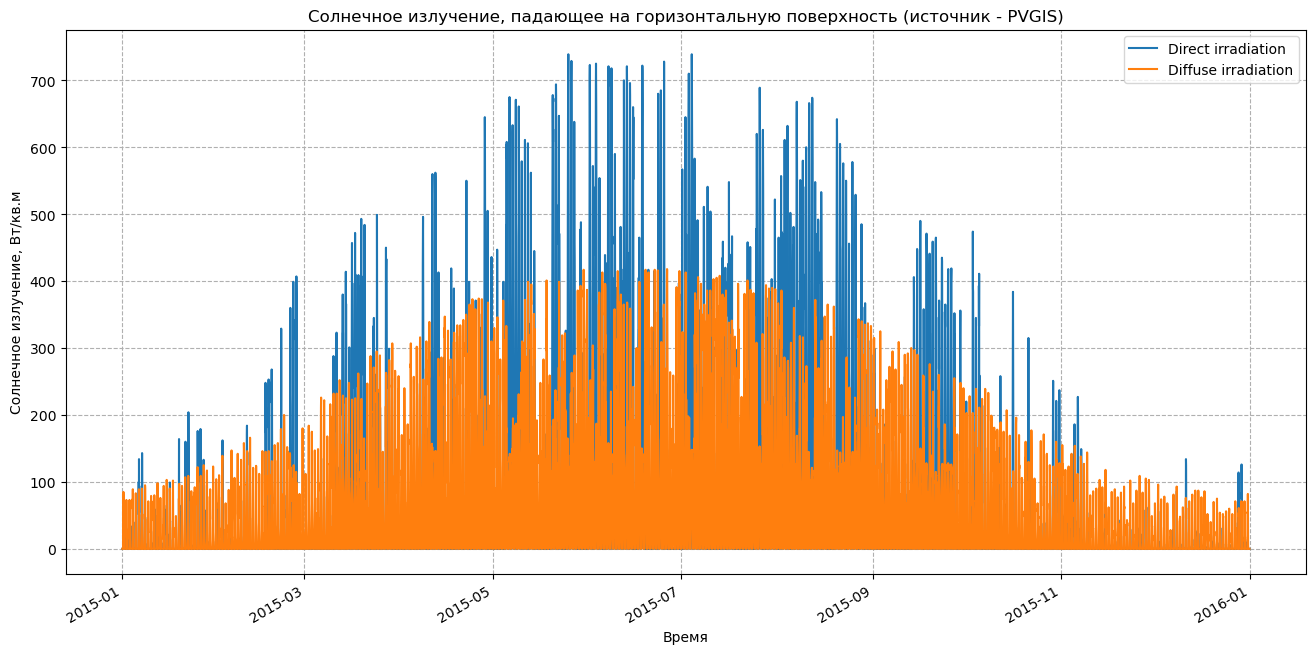

In [21]:
PVGIS_data['poa_direct'].plot(label='Direct irradiation', figsize=(16, 8))
PVGIS_data['poa_sky_diffuse'].plot(label='Diffuse irradiation')
#PVGIS_data['poa_ground_diffuse'].plot(label='Groud diffuse irradiation')
plt.legend()
plt.grid(linestyle='--')
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Время')
plt.title('Cолнечное излучение, падающее на горизонтальную поверхность (источник - PVGIS)')
plt.show()

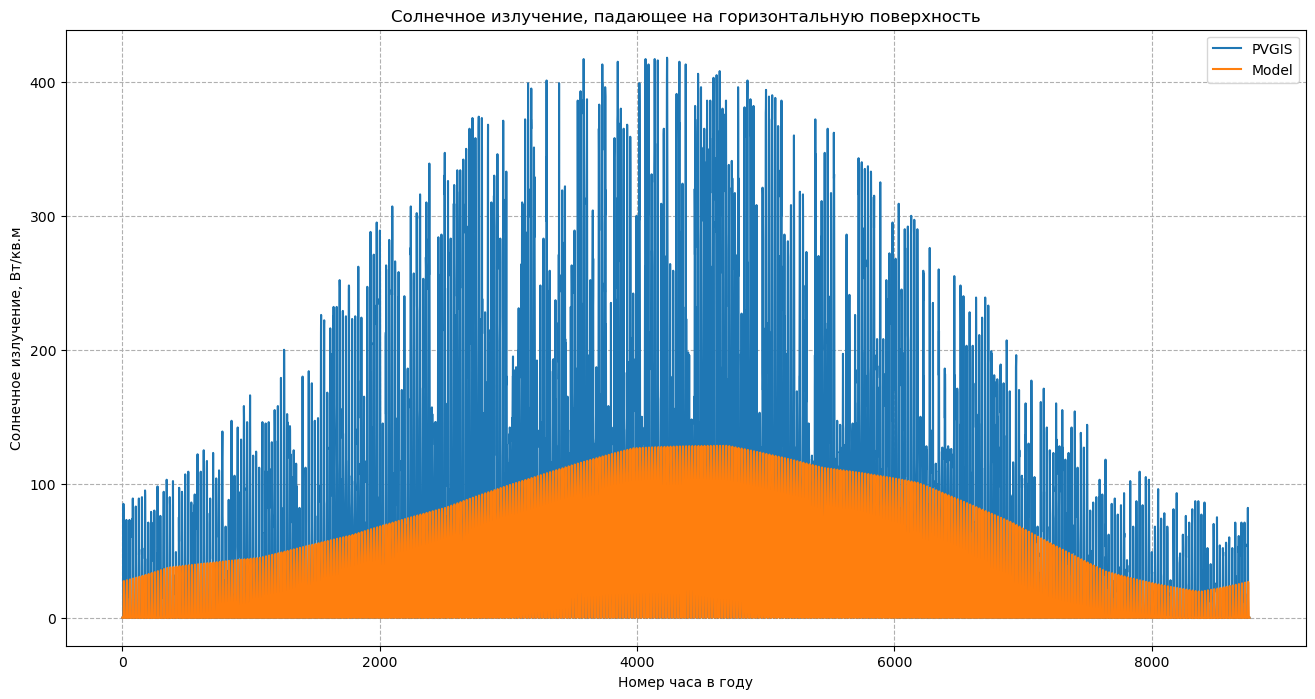

In [22]:
# Сравнение смоделированных и полученных из PVGIS данных 
y1 = SimpleClearSky['dhi'].values
y2 = PVGIS_data['poa_sky_diffuse'].values
x = range(8760)
plt.figure(figsize=(16, 8))
plt.plot(x, y2, label='PVGIS')
plt.plot(x, y1, label='Model')
plt.legend()
plt.grid(linestyle='--')
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Номер часа в году')
plt.title('Cолнечное излучение, падающее на горизонтальную поверхность')
plt.show()

### Особенности данных, полученных из геоинформационной системы PVGIS
Метки времени, приведённые в столбце time, даны по Гринвичу - их необходимо привести к местному времени.

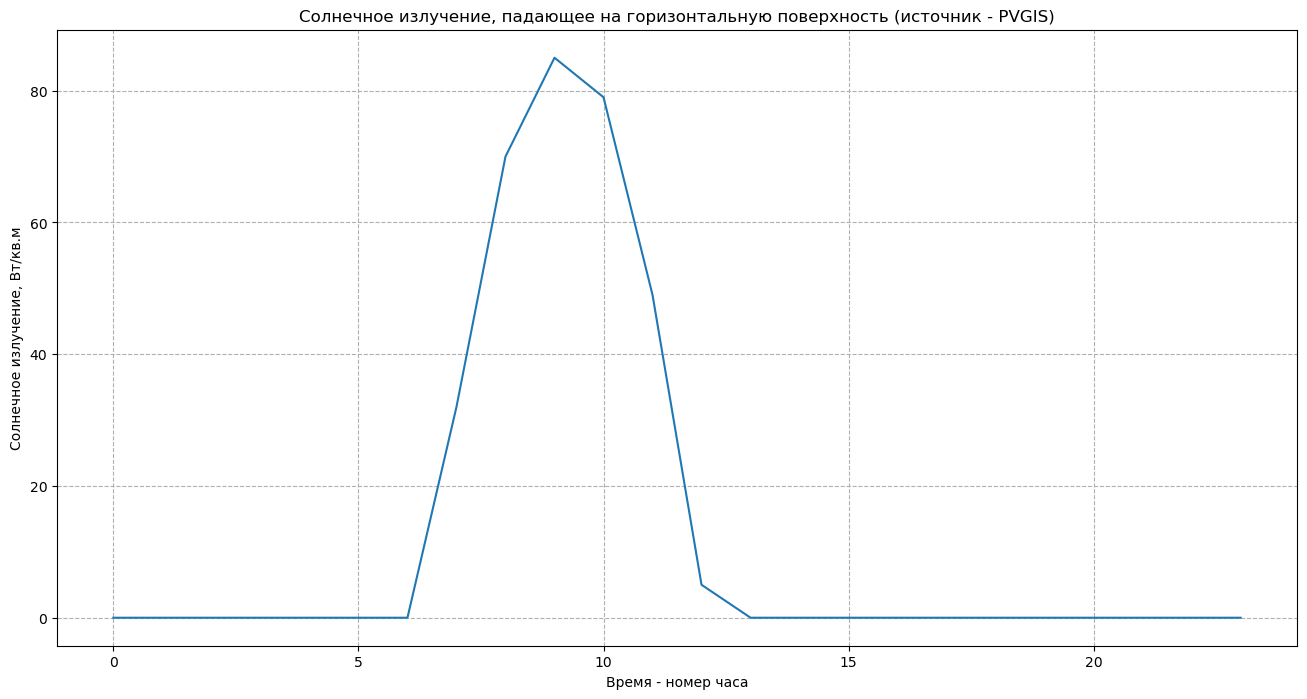

In [23]:
# Отображение графика за первые сутки года (0:24 час), только первый [1] столбец - poa_global
y = PVGIS_data.iloc[0:24, [1]]
x = range(24)
plt.figure(figsize=(16, 8))
plt.plot(x, y)
plt.grid(linestyle='--')
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Время - номер часа')
plt.title('Cолнечное излучение, падающее на горизонтальную поверхность (источник - PVGIS)')
plt.show()

In [24]:
# по первому члену переменной times_loc определим смещение по отношению ко времени UTC
times_loc1 = times_loc[1]
deltaTimeZone = times_loc1.strftime('%z')

# Возьмём первые два числа (целое количество часов) и знак 
# (+ для восточного полушария, а - для западного), т.е. всего - первые три символа
deltaTimeZone = deltaTimeZone[0:3]

# Преобразуем полученную строку в целое число
deltaTimeZone = int(deltaTimeZone)

#deltaTimeZone = +3

# Чтобы ничего не попортить, скопируем данные из БД в отдельный dataframe
data = PVGIS_data

# Определим длину dataframe
lenDATA = len(data)

# Если сдвиг по отнощению к UTC положителен (восточное полушарие), то
# Концовку dataframe нужно переместить в начало - сдвинуть весь временной ряд
# на deltaTimeZone часов вправо
if deltaTimeZone >= 0:
    data1 = data[lenDATA - deltaTimeZone:lenDATA]
    data2 = data[0:lenDATA - deltaTimeZone]
    #data3 = data1.append(data2, ignore_index = True) # При создании нового datafame удалим индексы
    data3 = pd.concat([data1, data2], ignore_index=True)

# Если сдвиг по отнощению к UTC отрицателен (западное полушарие), то
# начало dataframe нужно переместить в конец - сдвинуть весь временной ряд
# на deltaTimeZone часов влево    
if deltaTimeZone < 0:
    data1 = data[0:abs(deltaTimeZone)]
    data2 = data[abs(deltaTimeZone):lenDATA]
    #data3 = data2.append(data1, ignore_index = True)
    data3 = pd.concat([data2, data1], ignore_index=True)

# Создадим новый столбец 'time' и запишем в него значения из переменной times_loc
data3['time'] = times_loc
# Сделаем этот столбец индесом
data3 = data3.set_index('time')
PVGIS_data = data3
PVGIS_data

poa_direct  poa_sky_diffuse  poa_ground_diffuse  \
time                                                                         
2025-01-01 00:00:00+03:00         0.0              0.0                 0.0   
2025-01-01 01:00:00+03:00         0.0              0.0                 0.0   
2025-01-01 02:00:00+03:00         0.0              0.0                 0.0   
2025-01-01 03:00:00+03:00         0.0              0.0                 0.0   
2025-01-01 04:00:00+03:00         0.0              0.0                 0.0   
...                               ...              ...                 ...   
2025-12-31 19:00:00+03:00         0.0              0.0                 0.0   
2025-12-31 20:00:00+03:00         0.0              0.0                 0.0   
2025-12-31 21:00:00+03:00         0.0              0.0                 0.0   
2025-12-31 22:00:00+03:00         0.0              0.0                 0.0   
2025-12-31 23:00:00+03:00         0.0              0.0                 0.0   

                           solar_elevation  temp_air  wind_speed  Int  
time                                                                   
2025-01-01 00:00:00+03:00              0.0    -11.99        4.52    0  
2025-01-01 01:00:00+03:00              0.0    -11.99        4.52    0  
2025-01-01 02:00:00+03:00              0.0    -11.99        4.52    0  
2025-01-01 03:00:00+03:00              0.0     -7.32        3.83    0  
2025-01-01 04:00:00+03:00              0.0     -6.22        3.64    0  
...                                    ...       ...         ...  ...  
2025-12-31 19:00:00+03:00              0.0    -10.12        4.64    0  
2025-12-31 20:00:00+03:00              0.0    -10.55        4.67    0  
2025-12-31 21:00:00+03:00              0.0    -10.97        4.70    0  
2025-12-31 22:00:00+03:00              0.0    -11.31        4.64    0  
2025-12-31 23:00:00+03:00              0.0    -11.65        4.58    0  

[8760 rows x 7 columns]

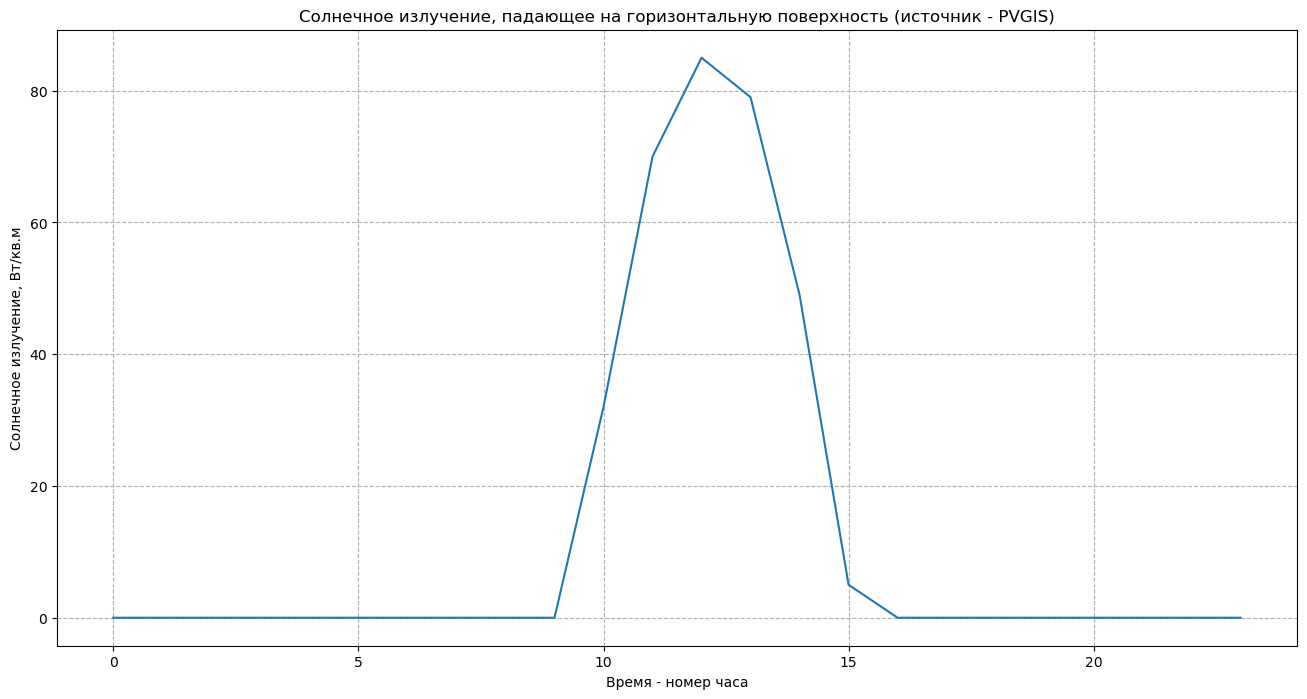

In [25]:
# Отображение графика за первые сутки года (0:24 час), только первый [1] столбец - poa_global
y = data3.iloc[0:24, [1]]
x = range(24)
plt.figure(figsize=(16, 8))
plt.plot(x, y)
plt.grid(linestyle='--')
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Время - номер часа')
plt.title('Cолнечное излучение, падающее на горизонтальную поверхность (источник - PVGIS)')
plt.show()

## 2.4 Получение данных из БД NASA SSE

База данных предоставляет наборы солнечных и метеорологических данных из исследований НАСА, необходимых для анализа работы энергетических объектов на основе возобновляемых источников энергии, повышения энергоэффективности зданий и удовлетворения потребностей сельского хозяйства.

База данных доступна по адресу [1]. На рисунке представлен скриншот главной страницы сайта:


### Основные разделы документации:
Первым делом стоит обратить внимание на страницу с рекомендациями по работе с данными: https://power.larc.nasa.gov/ -> `Data Access Tutorials`.

В меню слева доступно несколько полезных текстов:

1. Описание доступных в БД параметров: `Parameters` -> `Dictionary` -> `Parameter Dictionary`
2. Примеры кода со способами получения доступа к данным из интерфейсов прикладного программного обеспеения (API): `Service Data Request` / `API`


### Пример исходного кода (из документации)
```
'''
*Version: 2.0 Published: 2021/03/09* Source: [NASA POWER](https://power.larc.nasa.gov/)
POWER API Multi-Point Download
This is an overview of the process to request data from multiple data points from the POWER API.
'''

import os, json, requests

locations = [(32.929, -95.770), (5, 10)]

output = r""

base_url = r"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN&community=RE&longitude={longitude}&latitude={latitude}&start=20150101&end=20150305&format=JSON"

for latitude, longitude in locations:

    api_request_url = base_url.format(longitude=longitude, latitude=latitude)

    response = requests.get(url=api_request_url, verify=True, timeout=30.00)

    content = json.loads(response.content.decode('utf-8'))
    filename = response.headers['content-disposition'].split('filename=')[1]

    filepath = os.path.join(output, filename)
    with open(filepath, 'w') as file_object:
        json.dump(content, file_object)
```

### Список использованных источников:
1. The POWER Project: https://power.larc.nasa.gov/

In [26]:
# задаём начальную и конечную даты периода, за которых хотим получить данные
start = '20150101'
stop = '20151231'

# Из раздела документации Parameter Dictionary выбраны следующие параметры:
# ALLSKY_SRF_ALB        # The all sky rate of reflectivity of the earth's surface; the ratio of the solar energy reflected by the surface of the earth compared to the total solar energy incident reaching the surface of the earth.
# ALLSKY_SFC_SW_DIFF    # The diffuse (light energy scattered out of the direction of the sun) solar irradiance incident on a horizontal plane at the surface of the earth under all sky conditions.
# ALLSKY_SFC_SW_DNI     # The direct solar irradiance incident to a horizontal plane normal (perpendicular) to the direction of the sun's position under all sky conditions.
# ALLSKY_SFC_SW_DWN     # The total solar irradiance incident (direct plus diffuse) on a horizontal plane at the surface of the earth under all sky conditions. An alternative term for the total solar irradiance is the "Global Horizontal Irradiance" or GHI.
# T2M                   # The average air (dry bulb) temperature at 2 meters above the surface of the earth.
# WS10M                 # The average of wind speed at 10 meters above the surface of the earth.

# Оригинальная строка запроса:
#base_url = r"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN&community=RE&longitude={longitude}&latitude={latitude}&start=20150101&end=20150305&format=JSON"
# Заменим указанные параметры на нужные нам, а также даты начала-конца периода на переменные start и stop
base_url = r"https://power.larc.nasa.gov/api/temporal/hourly/point?parameters=ALLSKY_SRF_ALB,ALLSKY_SFC_SW_DIFF,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DWN,T2M,WS10M&community=RE&longitude={longitude}&latitude={latitude}&start={start}&end={stop}&format=CSV"

# Функция Python format() - это встроенная строковая функция, используемая для форматирования строк.
api_request_url = base_url.format(longitude=A.longitude, latitude=A.latitude, start=start, stop=stop)

# С помощью функции requests.get обратимся по заданному url за данными
response = requests.get(url=api_request_url, verify=True, timeout=30.00)

# преобразуем данные в строку
content = str(response.content)

# заменим последовательность символов '\n' на перевод строки по всему тексту (maxsplit=-1)
content = content.split(sep=r'\n', maxsplit=-1)

# Придумаем название файлу, в который сохраним данные
NASAfilename = 'NASA_SSE_date__lat' + str(A.latitude) + '_lon' + str(A.longitude) + '.csv'

# Откроем файл с нужным именем в режиме "для записи"
f = open(NASAfilename, 'w')

# Запишем в файл каждую строку из переменной content, добавив в конце перевод строки
for text in content:
    f.write(text + '\n')

    # Закроем файл, чтобы с ним можно было и дальше работать
f.close()

# Прочитаем файл в dataframe, пропустив первые строки, в которых идёт описание данных 
# (предварительно файл надо открыть и количество этих строе подсчитать)
NASA_data = pd.read_csv(NASAfilename, sep=',', skiprows=14, header=0)

# Удалим последнюю "пустую" строку
NASA_data = NASA_data.drop(index=8760)
NASA_data

YEAR    MO    DY    HR  ALLSKY_SRF_ALB  ALLSKY_SFC_SW_DIFF  \
0     2015   1.0   1.0   0.0          -999.0                 0.0   
1     2015   1.0   1.0   1.0          -999.0                 0.0   
2     2015   1.0   1.0   2.0          -999.0                 0.0   
3     2015   1.0   1.0   3.0          -999.0                 0.0   
4     2015   1.0   1.0   4.0          -999.0                 0.0   
...    ...   ...   ...   ...             ...                 ...   
8755  2015  12.0  31.0  19.0          -999.0                 0.0   
8756  2015  12.0  31.0  20.0          -999.0                 0.0   
8757  2015  12.0  31.0  21.0          -999.0                 0.0   
8758  2015  12.0  31.0  22.0          -999.0                 0.0   
8759  2015  12.0  31.0  23.0          -999.0                 0.0   

      ALLSKY_SFC_SW_DNI  ALLSKY_SFC_SW_DWN    T2M  WS10M  
0                   0.0                0.0  -8.06   7.08  
1                   0.0                0.0  -7.70   6.79  
2                   0.0                0.0  -7.24   6.44  
3                   0.0                0.0  -7.08   5.86  
4                   0.0                0.0  -7.16   5.93  
...                 ...                ...    ...    ...  
8755                0.0                0.0 -14.39   6.74  
8756                0.0                0.0 -14.70   6.48  
8757                0.0                0.0 -14.94   6.19  
8758                0.0                0.0 -15.02   6.03  
8759                0.0                0.0 -14.95   5.95  

[8760 rows x 10 columns]

### Особенности БД NASA SSE

Построим график изменения солнечного излучения (столбец №7 - ALLSKY_SFC_SW_DWN) за первые сутки года

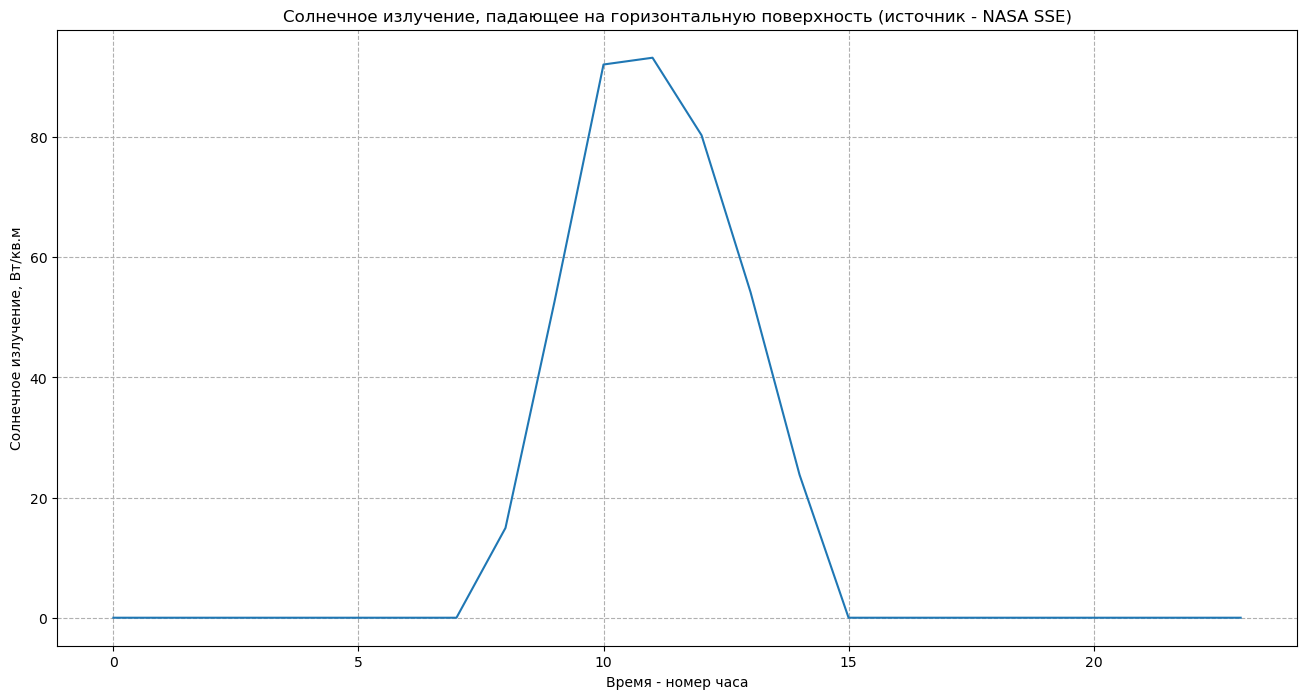

In [27]:
y = NASA_data.iloc[0:24, [7]]
x = range(24)
plt.figure(figsize=(16, 8))
plt.plot(x, y)
plt.grid(linestyle='--')
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Время - номер часа')
plt.title('Cолнечное излучение, падающее на горизонтальную поверхность (источник - NASA SSE)')
plt.show()

In [28]:
# по первому члену переменной times_loc определим смещение по отношению ко времени UTC
times_loc1 = times_loc[1]
deltaTimeZone = times_loc1.strftime('%z')

# Возьмём первые два числа (целое количество часов) и знак 
# (+ для восточного полушария, а - для западного), т.е. всего - первые три символа
deltaTimeZone = deltaTimeZone[0:3]

# Преобразуем полученную строку в целое число
deltaTimeZone = int(deltaTimeZone)

#deltaTimeZone = +3

# Чтобы ничего не попортить, скопируем данные из БД в отдельный dataframe
data = NASA_data

# Определим длину dataframe
lenDATA = len(data)

# Если сдвиг по отнощению к UTC положителен (восточное полушарие), то
# Концовку dataframe нужно переместить в начало - сдвинуть весь временной ряд
# на deltaTimeZone часов вправо
if deltaTimeZone >= 0:
    data1 = data[lenDATA - deltaTimeZone:lenDATA]
    data2 = data[0:lenDATA - deltaTimeZone]
    #data3 = data1.append(data2, ignore_index = True) # При создании нового datafame удалим индексы
    data3 = pd.concat([data1, data2], ignore_index=True)

# Если сдвиг по отнощению к UTC отрицателен (западное полушарие), то
# начало dataframe нужно переместить в конец - сдвинуть весь временной ряд
# на deltaTimeZone часов влево    
if deltaTimeZone < 0:
    data1 = data[0:abs(deltaTimeZone)]
    data2 = data[abs(deltaTimeZone):lenDATA]
    #data3 = data2.append(data1, ignore_index = True)
    data3 = pd.concat([data2, data1], ignore_index=True)

# Создадим новый столбец 'time' и запишем в него значения из переменной times_loc
data3['time'] = times_loc
# Сделаем этот столбец индесом
data3 = data3.set_index('time')
NASA_data = data3
NASA_data

YEAR    MO    DY    HR  ALLSKY_SRF_ALB  \
time                                                                
2025-01-01 00:00:00+03:00  2015  12.0  31.0  21.0          -999.0   
2025-01-01 01:00:00+03:00  2015  12.0  31.0  22.0          -999.0   
2025-01-01 02:00:00+03:00  2015  12.0  31.0  23.0          -999.0   
2025-01-01 03:00:00+03:00  2015   1.0   1.0   0.0          -999.0   
2025-01-01 04:00:00+03:00  2015   1.0   1.0   1.0          -999.0   
...                         ...   ...   ...   ...             ...   
2025-12-31 19:00:00+03:00  2015  12.0  31.0  16.0          -999.0   
2025-12-31 20:00:00+03:00  2015  12.0  31.0  17.0          -999.0   
2025-12-31 21:00:00+03:00  2015  12.0  31.0  18.0          -999.0   
2025-12-31 22:00:00+03:00  2015  12.0  31.0  19.0          -999.0   
2025-12-31 23:00:00+03:00  2015  12.0  31.0  20.0          -999.0   

                           ALLSKY_SFC_SW_DIFF  ALLSKY_SFC_SW_DNI  \
time                                                               
2025-01-01 00:00:00+03:00                 0.0                0.0   
2025-01-01 01:00:00+03:00                 0.0                0.0   
2025-01-01 02:00:00+03:00                 0.0                0.0   
2025-01-01 03:00:00+03:00                 0.0                0.0   
2025-01-01 04:00:00+03:00                 0.0                0.0   
...                                       ...                ...   
2025-12-31 19:00:00+03:00                 0.0                0.0   
2025-12-31 20:00:00+03:00                 0.0                0.0   
2025-12-31 21:00:00+03:00                 0.0                0.0   
2025-12-31 22:00:00+03:00                 0.0                0.0   
2025-12-31 23:00:00+03:00                 0.0                0.0   

                           ALLSKY_SFC_SW_DWN    T2M  WS10M  
time                                                        
2025-01-01 00:00:00+03:00                0.0 -14.94   6.19  
2025-01-01 01:00:00+03:00                0.0 -15.02   6.03  
2025-01-01 02:00:00+03:00                0.0 -14.95   5.95  
2025-01-01 03:00:00+03:00                0.0  -8.06   7.08  
2025-01-01 04:00:00+03:00                0.0  -7.70   6.79  
...                                      ...    ...    ...  
2025-12-31 19:00:00+03:00                0.0 -12.77   6.54  
2025-12-31 20:00:00+03:00                0.0 -13.37   6.74  
2025-12-31 21:00:00+03:00                0.0 -13.88   6.89  
2025-12-31 22:00:00+03:00                0.0 -14.39   6.74  
2025-12-31 23:00:00+03:00                0.0 -14.70   6.48  

[8760 rows x 10 columns]

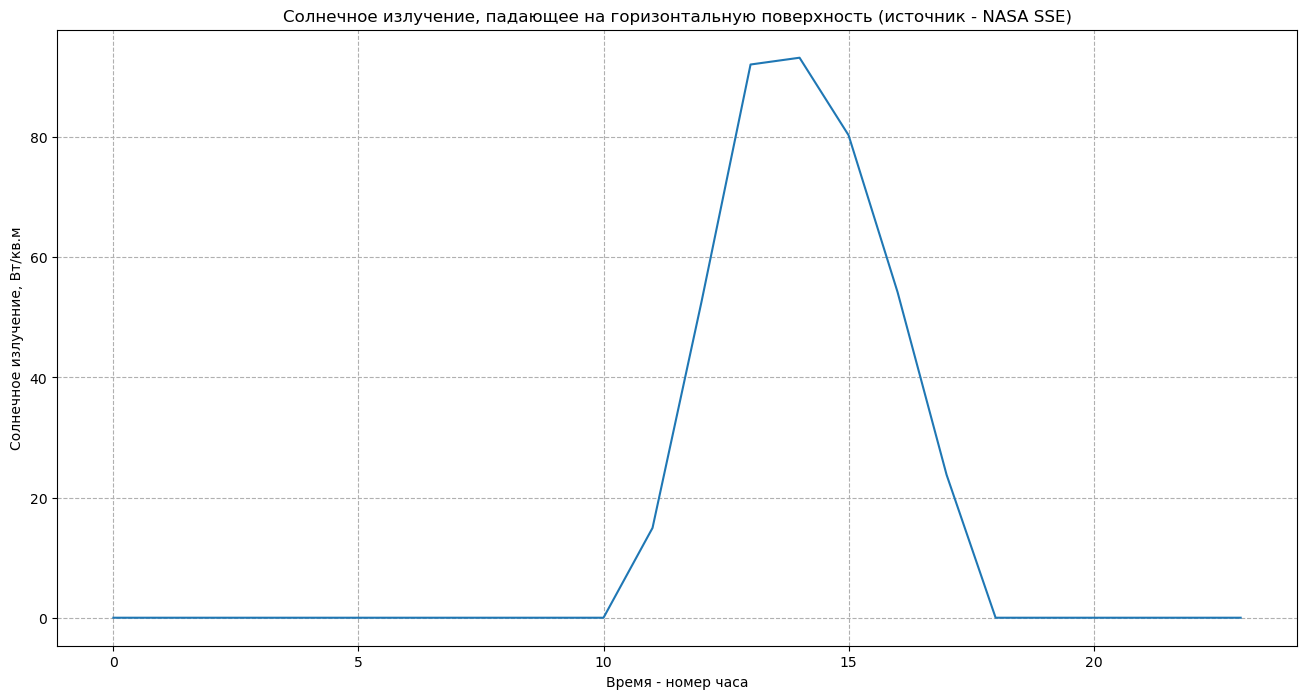

In [29]:
y = data3.iloc[0:24, [7]]
x = range(24)
plt.figure(figsize=(16, 8))
plt.plot(x, y)
plt.grid(linestyle='--')
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Время - номер часа')
plt.title('Cолнечное излучение, падающее на горизонтальную поверхность (источник - NASA SSE)')
plt.show()

## 2.5 Пример загрузки данных из источника, не имеющего стандартного API
Для примера поработаем с базой данных, созданной на основе информации, представленной в научно-прикладном справочнике по климату СССР.

Информация представлена в виде отдельных таблиц (солнечная суммарная, диффузная и прямая радиация за каждый час характерных суток каждого месяца года) следующего формата:

|Месяц\Час| 1 | 2 | 3 | ... | 24 |
|---------|---|---|---|-----|----|
| 1       | x | x | x | ... | x  |
| 2       | x | x | x | ... | x  |
| ...     | x | x | x | ... | x  |
| 12      | x | x | x | ... | x  |

Проведён предварительный экспорт данных в CSV-файл, в котором таблицы для удобства транспонированы, т.е. имеют следующий вид:

|Час\Месяц| 1 | 2 | 3 | ... | 12 |
|---------|---|---|---|-----|----|
| 1       | x | x | x | ... | x  |
| 2       | x | x | x | ... | x  |
| ...     | x | x | x | ... | x  |
| 24      | x | x | x | ... | x  |

In [30]:
# загрузка данных по суммарной солнечной радиации
GHI = pd.read_csv('GlobalHorizontalIrradiation.csv', sep=';')
GHI

1         2         3         4         5         6         7  \
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.011111  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.025000  0.047222  0.036111   
5   0.000000  0.000000  0.000000  0.025000  0.094444  0.130556  0.105556   
6   0.000000  0.000000  0.025000  0.094444  0.188889  0.236111  0.200000   
7   0.000000  0.025000  0.083333  0.188889  0.297222  0.344444  0.308333   
8   0.011111  0.072222  0.177778  0.283333  0.402778  0.438889  0.402778   
9   0.047222  0.141667  0.272222  0.355556  0.486111  0.522222  0.475000   
10  0.094444  0.202778  0.330556  0.413889  0.533333  0.580556  0.522222   
11  0.119444  0.236111  0.377778  0.450000  0.544444  0.580556  0.533333   
12  0.119444  0.236111  0.366667  0.450000  0.544444  0.580556  0.522222   
13  0.094444  0.213889  0.344444  0.427778  0.508333  0.544444  0.497222   
14  0.058333  0.152778  0.272222  0.366667  0.438889  0.497222  0.450000   
15  0.011111  0.072222  0.188889  0.283333  0.366667  0.427778  0.377778   
16  0.000000  0.025000  0.083333  0.188889  0.283333  0.330556  0.297222   
17  0.000000  0.000000  0.025000  0.094444  0.177778  0.236111  0.200000   
18  0.000000  0.000000  0.000000  0.025000  0.094444  0.141667  0.105556   
19  0.000000  0.000000  0.000000  0.000000  0.025000  0.058333  0.036111   
20  0.000000  0.000000  0.000000  0.000000  0.000000  0.011111  0.000000   
21  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
22  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           8         9        10        11        12  
0   0.000000  0.000000  0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  0.000000  0.000000  
3   0.000000  0.000000  0.000000  0.000000  0.000000  
4   0.011111  0.000000  0.000000  0.000000  0.000000  
5   0.047222  0.000000  0.000000  0.000000  0.000000  
6   0.130556  0.047222  0.000000  0.000000  0.000000  
7   0.236111  0.119444  0.036111  0.000000  0.000000  
8   0.344444  0.200000  0.083333  0.025000  0.000000  
9   0.413889  0.283333  0.141667  0.047222  0.036111  
10  0.461111  0.330556  0.177778  0.083333  0.058333  
11  0.486111  0.355556  0.200000  0.105556  0.083333  
12  0.475000  0.355556  0.200000  0.105556  0.083333  
13  0.438889  0.319444  0.177778  0.083333  0.058333  
14  0.391667  0.272222  0.130556  0.047222  0.036111  
15  0.319444  0.188889  0.083333  0.025000  0.000000  
16  0.225000  0.119444  0.025000  0.000000  0.000000  
17  0.130556  0.047222  0.000000  0.000000  0.000000  
18  0.047222  0.000000  0.000000  0.000000  0.000000  
19  0.011111  0.000000  0.000000  0.000000  0.000000  
20  0.000000  0.000000  0.000000  0.000000  0.000000  
21  0.000000  0.000000  0.000000  0.000000  0.000000  
22  0.000000  0.000000  0.000000  0.000000  0.000000  
23  0.000000  0.000000  0.000000  0.000000  0.000000

In [31]:
# загрузка данных по прямой солнечной радиации
DirectHI = pd.read_csv('DirectHorizontalIrradiation.csv', sep=';')
DirectHI

1         2         3         4         5         6         7  \
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.011111  0.011111   
5   0.000000  0.000000  0.000000  0.000000  0.036111  0.058333  0.033333   
6   0.000000  0.000000  0.000000  0.036111  0.083333  0.130556  0.094444   
7   0.000000  0.013889  0.025000  0.083333  0.155556  0.191667  0.166667   
8   0.000000  0.025000  0.058333  0.130556  0.225000  0.250000  0.225000   
9   0.011111  0.047222  0.119444  0.166667  0.272222  0.297222  0.261111   
10  0.022222  0.083333  0.141667  0.188889  0.297222  0.330556  0.272222   
11  0.036111  0.094444  0.163889  0.225000  0.294444  0.319444  0.272222   
12  0.036111  0.094444  0.152778  0.213889  0.294444  0.308333  0.261111   
13  0.022222  0.094444  0.155556  0.213889  0.272222  0.283333  0.247222   
14  0.011111  0.058333  0.119444  0.177778  0.225000  0.261111  0.225000   
15  0.000000  0.025000  0.083333  0.130556  0.177778  0.227778  0.188889   
16  0.000000  0.013889  0.025000  0.083333  0.130556  0.163889  0.144444   
17  0.000000  0.000000  0.000000  0.036111  0.072222  0.105556  0.080556   
18  0.000000  0.000000  0.000000  0.000000  0.036111  0.058333  0.036111   
19  0.000000  0.000000  0.000000  0.000000  0.000000  0.022222  0.011111   
20  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
21  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
22  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           8         9        10        11        12  
0   0.000000  0.000000  0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  0.000000  0.000000  
3   0.000000  0.000000  0.000000  0.000000  0.000000  
4   0.000000  0.000000  0.000000  0.000000  0.000000  
5   0.011111  0.000000  0.000000  0.000000  0.000000  
6   0.058333  0.011111  0.000000  0.000000  0.000000  
7   0.116667  0.047222  0.011111  0.000000  0.000000  
8   0.191667  0.080556  0.025000  0.013889  0.000000  
9   0.225000  0.141667  0.047222  0.011111  0.011111  
10  0.247222  0.163889  0.072222  0.025000  0.011111  
11  0.250000  0.177778  0.080556  0.033333  0.025000  
12  0.238889  0.177778  0.080556  0.033333  0.025000  
13  0.213889  0.152778  0.072222  0.025000  0.011111  
14  0.191667  0.130556  0.047222  0.011111  0.011111  
15  0.152778  0.083333  0.025000  0.013889  0.000000  
16  0.105556  0.047222  0.000000  0.000000  0.000000  
17  0.047222  0.011111  0.000000  0.000000  0.000000  
18  0.011111  0.000000  0.000000  0.000000  0.000000  
19  0.000000  0.000000  0.000000  0.000000  0.000000  
20  0.000000  0.000000  0.000000  0.000000  0.000000  
21  0.000000  0.000000  0.000000  0.000000  0.000000  
22  0.000000  0.000000  0.000000  0.000000  0.000000  
23  0.000000  0.000000  0.000000  0.000000  0.000000

In [32]:
# загрузка данных по диффузной солнечной радиации
DHI = pd.read_csv('DiffuseHorizontalIrradiation.csv', sep=';')
DHI

1         2         3         4         5         6         7  \
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.011111  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.025000  0.036111  0.025000   
5   0.000000  0.000000  0.000000  0.025000  0.058333  0.072222  0.072222   
6   0.000000  0.000000  0.025000  0.058333  0.105556  0.105556  0.105556   
7   0.000000  0.011111  0.058333  0.105556  0.141667  0.152778  0.141667   
8   0.011111  0.047222  0.119444  0.152778  0.177778  0.188889  0.177778   
9   0.036111  0.094444  0.152778  0.188889  0.213889  0.225000  0.213889   
10  0.072222  0.119444  0.188889  0.225000  0.236111  0.250000  0.250000   
11  0.083333  0.141667  0.213889  0.225000  0.250000  0.261111  0.261111   
12  0.083333  0.141667  0.213889  0.236111  0.250000  0.272222  0.261111   
13  0.072222  0.119444  0.188889  0.213889  0.236111  0.261111  0.250000   
14  0.047222  0.094444  0.152778  0.188889  0.213889  0.236111  0.225000   
15  0.011111  0.047222  0.105556  0.152778  0.188889  0.200000  0.188889   
16  0.000000  0.011111  0.058333  0.105556  0.152778  0.166667  0.152778   
17  0.000000  0.000000  0.025000  0.058333  0.105556  0.130556  0.119444   
18  0.000000  0.000000  0.000000  0.025000  0.058333  0.083333  0.069444   
19  0.000000  0.000000  0.000000  0.000000  0.025000  0.036111  0.025000   
20  0.000000  0.000000  0.000000  0.000000  0.000000  0.011111  0.000000   
21  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
22  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           8         9        10        11        12  
0   0.000000  0.000000  0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  0.000000  0.000000  
3   0.000000  0.000000  0.000000  0.000000  0.000000  
4   0.011111  0.000000  0.000000  0.000000  0.000000  
5   0.036111  0.000000  0.000000  0.000000  0.000000  
6   0.072222  0.036111  0.000000  0.000000  0.000000  
7   0.119444  0.072222  0.025000  0.000000  0.000000  
8   0.152778  0.119444  0.058333  0.011111  0.000000  
9   0.188889  0.141667  0.094444  0.036111  0.025000  
10  0.213889  0.166667  0.105556  0.058333  0.047222  
11  0.236111  0.177778  0.119444  0.072222  0.058333  
12  0.236111  0.177778  0.119444  0.072222  0.058333  
13  0.225000  0.166667  0.105556  0.058333  0.047222  
14  0.200000  0.141667  0.083333  0.036111  0.025000  
15  0.166667  0.105556  0.058333  0.011111  0.000000  
16  0.119444  0.072222  0.025000  0.000000  0.000000  
17  0.083333  0.036111  0.000000  0.000000  0.000000  
18  0.036111  0.000000  0.000000  0.000000  0.000000  
19  0.011111  0.000000  0.000000  0.000000  0.000000  
20  0.000000  0.000000  0.000000  0.000000  0.000000  
21  0.000000  0.000000  0.000000  0.000000  0.000000  
22  0.000000  0.000000  0.000000  0.000000  0.000000  
23  0.000000  0.000000  0.000000  0.000000  0.000000

In [33]:
# загрузка данных об отражающей способности поверхности
Albedo = pd.read_csv('Albedo.csv', sep=';')
Albedo

1     2     3     4     5     6     7     8     9    10    11    12
0  0.72  0.74  0.65  0.27  0.21  0.23  0.23  0.23  0.23  0.28  0.49  0.66

In [34]:
# Создание пустого dataframe с нужными столбцами, в который будут перенесены необходимые значения
imax = 8760
NPS_data = pd.DataFrame(index=range(imax),
                       columns=['HOY', 'DOY', 'Month', 'Day', 'Hour', 'GHI', 'DirectHI', 'DHI', 'Albedo'])
NPS_data

HOY  DOY Month  Day Hour  GHI DirectHI  DHI Albedo
0     NaN  NaN   NaN  NaN  NaN  NaN      NaN  NaN    NaN
1     NaN  NaN   NaN  NaN  NaN  NaN      NaN  NaN    NaN
2     NaN  NaN   NaN  NaN  NaN  NaN      NaN  NaN    NaN
3     NaN  NaN   NaN  NaN  NaN  NaN      NaN  NaN    NaN
4     NaN  NaN   NaN  NaN  NaN  NaN      NaN  NaN    NaN
...   ...  ...   ...  ...  ...  ...      ...  ...    ...
8755  NaN  NaN   NaN  NaN  NaN  NaN      NaN  NaN    NaN
8756  NaN  NaN   NaN  NaN  NaN  NaN      NaN  NaN    NaN
8757  NaN  NaN   NaN  NaN  NaN  NaN      NaN  NaN    NaN
8758  NaN  NaN   NaN  NaN  NaN  NaN      NaN  NaN    NaN
8759  NaN  NaN   NaN  NaN  NaN  NaN      NaN  NaN    NaN

[8760 rows x 9 columns]

In [35]:
i = 0 # здесь будет номер часа в году 0...8759
ddd = 0 # здесь будет номер суток в году 0...365
for mm in range(12):
    m = mm + 1 # Номер месяца в году: +1 так как range() возвращает 0...11
    # Определение продолжительности каждого месяца года
    # Январь, март, май, июль, автгуст, октябрь и декабрь имеют продолжительнось в 31 день
    if m==1 or m==3 or m==5 or m==7 or m==8 or m==10 or m==12:
        dd_max = 31
    # продолжительность февраля - 28 дней (рассматривается невисокосный год)
    if m==2:
        dd_max = 28
    # Апрель, июнь, сентябрь и ноябрь имееют продолжительность в 30 дней.
    if m==4 or m==6 or m==9 or m==11:
        dd_max = 30
        
    for dd in range(dd_max):
        d = dd + 1 # Номер дня в месяце
        ddd = ddd + 1 # Номер дня в году
        for hh in range(24):
            h = hh + 1 # Номер часа в сутках
            i = i + 1 # Номер часа в году
            NPS_data.loc[i-1, 'HOY'] = i
            NPS_data.loc[i-1, 'DOY'] = ddd
            NPS_data.loc[i-1, 'Month'] = m
            NPS_data.loc[i-1, 'Day'] = d
            NPS_data.loc[i-1, 'Hour'] = h
            NPS_data.loc[i-1, 'GHI'] = GHI[str(m)][hh] * 1000
            NPS_data.loc[i-1, 'DirectHI'] = DirectHI[str(m)][hh] * 1000
            NPS_data.loc[i-1, 'DHI'] = DHI[str(m)][hh] * 1000
            NPS_data.loc[i-1, 'Albedo'] = Albedo[str(m)][0]

NPS_data['time'] = times_loc
NPS_data = NPS_data.set_index('time')
NPS_data

HOY  DOY Month Day Hour  GHI DirectHI  DHI Albedo
time                                                                         
2025-01-01 00:00:00+03:00     1    1     1   1    1  0.0      0.0  0.0   0.72
2025-01-01 01:00:00+03:00     2    1     1   1    2  0.0      0.0  0.0   0.72
2025-01-01 02:00:00+03:00     3    1     1   1    3  0.0      0.0  0.0   0.72
2025-01-01 03:00:00+03:00     4    1     1   1    4  0.0      0.0  0.0   0.72
2025-01-01 04:00:00+03:00     5    1     1   1    5  0.0      0.0  0.0   0.72
...                         ...  ...   ...  ..  ...  ...      ...  ...    ...
2025-12-31 19:00:00+03:00  8756  365    12  31   20  0.0      0.0  0.0   0.66
2025-12-31 20:00:00+03:00  8757  365    12  31   21  0.0      0.0  0.0   0.66
2025-12-31 21:00:00+03:00  8758  365    12  31   22  0.0      0.0  0.0   0.66
2025-12-31 22:00:00+03:00  8759  365    12  31   23  0.0      0.0  0.0   0.66
2025-12-31 23:00:00+03:00  8760  365    12  31   24  0.0      0.0  0.0   0.66

[8760 rows x 9 columns]

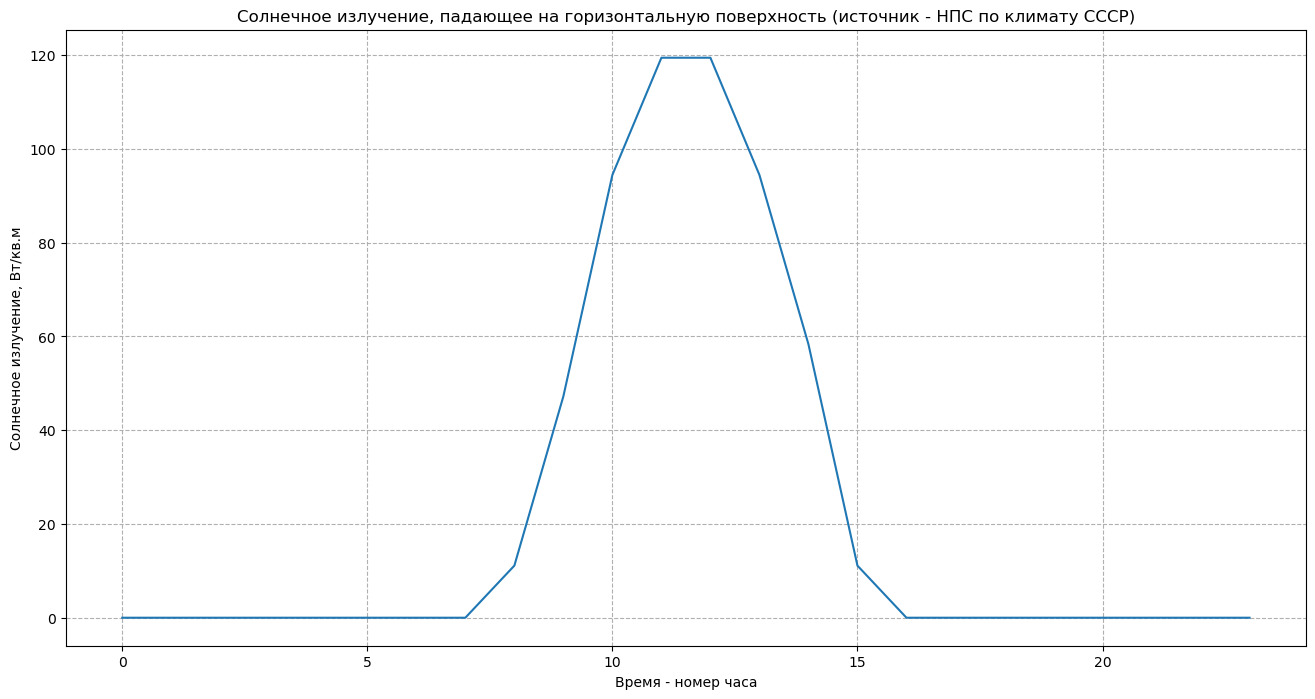

In [36]:
y = NPS_data.iloc[0:24, [5]]
x = range(24)
plt.figure(figsize=(16, 8))
plt.plot(x, y)
plt.grid(linestyle='--')
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Время - номер часа')
plt.title('Cолнечное излучение, падающее на горизонтальную поверхность (источник - НПС по климату СССР)')
plt.show()

## 2.7 Сравнение данных по солнечной радиации

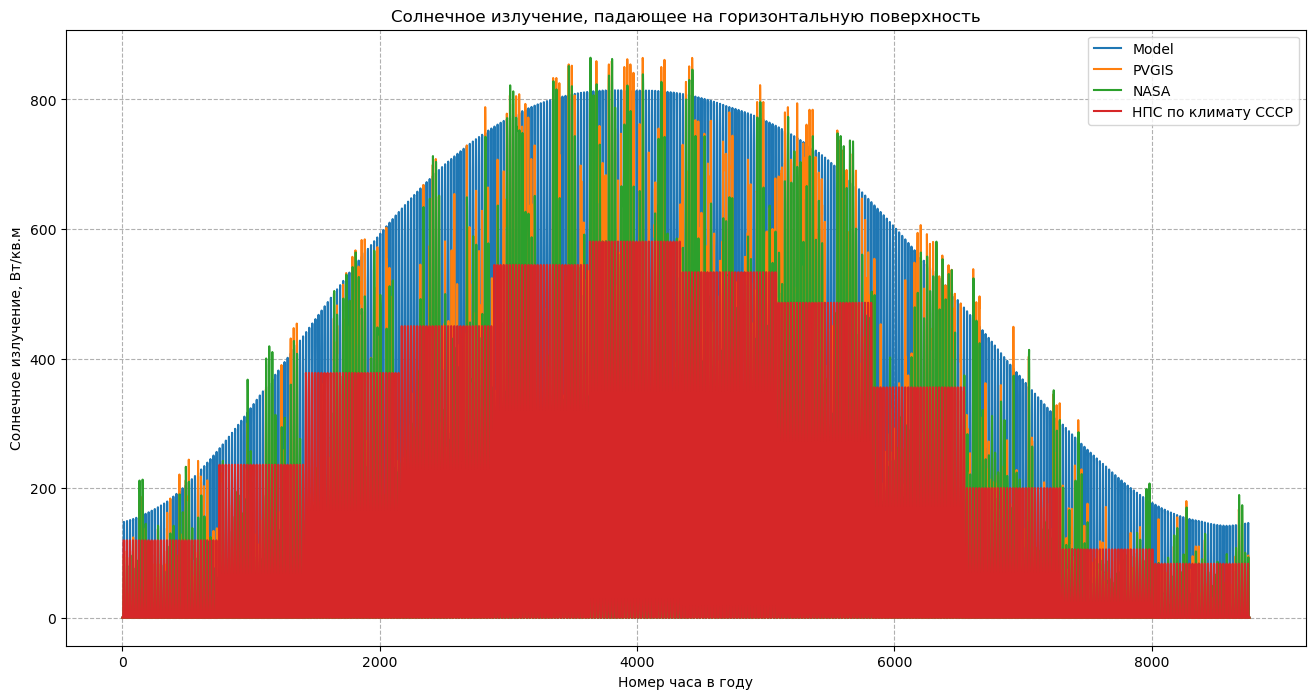

In [37]:
# Сравнение смоделированных и полученных из сторонних источников данных 
y1 = SimpleClearSky['ghi'].values
y2 = PVGIS_data['poa_direct'].values + PVGIS_data['poa_sky_diffuse'].values
y3 = NASA_data['ALLSKY_SFC_SW_DWN'].values
y4 = NPS_data['GHI'].values
x = range(8760)

plt.figure(figsize=(16, 8))
plt.plot(x, y1, label='Model')
plt.plot(x, y2, label='PVGIS')
plt.plot(x, y3, label='NASA')
plt.plot(x, y4, label='НПС по климату СССР')
plt.legend()
plt.grid(linestyle='--')
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Номер часа в году')
plt.title('Cолнечное излучение, падающее на горизонтальную поверхность')
plt.show()

In [38]:
ClearSky_year_sum = SimpleClearSky['ghi'].sum()
PVGIS_year_sum = PVGIS_data['poa_direct'].sum() + PVGIS_data['poa_sky_diffuse'].sum()
NASA_year_sum = NASA_data['ALLSKY_SFC_SW_DWN'].sum()
NPS_year_sum = NPS_data['GHI'].sum()

print('Годовые сумму суммарного солнечного излучения, МВтч/кв.м:')
print('   Модель ясного неба                          :', round(ClearSky_year_sum / 10**6, 3))
print('   Геоинформационная система PVGIS             :', round(PVGIS_year_sum / 10**6, 3))
print('   База данных NASA SSE                        :', round(NASA_year_sum / 10**6, 3))
print('   Научно-прикладной справочник по климату СССР:', round(NPS_year_sum / 10**6, 3))
print('---')
print('Отклонения от данных НПС по климату СССР, %:')
print('   Модель ясного неба                          :', 
      round((ClearSky_year_sum - NPS_year_sum) / NPS_year_sum * 100, 2))
print('   Геоинформационная система PVGIS             :', 
      round((PVGIS_year_sum - NPS_year_sum) / NPS_year_sum * 100, 2))
print('   База данных NASA SSE                        :', 
      round((NASA_year_sum - NPS_year_sum) / NPS_year_sum * 100, 2))
print('   Научно-прикладной справочник по климату СССР:', 
      round((NPS_year_sum - NPS_year_sum) / NPS_year_sum * 100, 2))

Годовые сумму суммарного солнечного излучения, МВтч/кв.м:
   Модель ясного неба                          : 1.468
   Геоинформационная система PVGIS             : 0.997
   База данных NASA SSE                        : 1.059
   Научно-прикладной справочник по климату СССР: 1.002
---
Отклонения от данных НПС по климату СССР, %:
   Модель ясного неба                          : 46.48
   Геоинформационная система PVGIS             : -0.54
   База данных NASA SSE                        : 5.67
   Научно-прикладной справочник по климату СССР: 0.0


# 3 Солнечное излучение, падающее на наклонную поверхность

In [39]:
# Ориентация приёмной поверхности
surface_tilt = A.latitude - 15 # Угол наклона к горизонту
surface_azimuth = 180 # Азимут

In [40]:
# Для примера будем работать с одним из источников информации

#DiffuseIrradiation = NPS_data['DiffHI']
#DiffuseIrradiation = NASA_data['ALLSKY_SFC_SW_DIFF']
#DiffuseIrradiation = VerySimpleClearSky['dhi']
DiffuseIrradiation = SimpleClearSky['dhi']
#DiffuseIrradiation = PVGIS_data['poa_sky_diffuse']

## 3.1 Диффузное солнечное излучение

## 3.1.1 Изотропная небесная сфера
### Модуль ``pvlib.irradiance.isotropic``

Модуль ``pvlib.irradiance.isotropic(surface_tilt, dhi)`` позволяет определить диффузное излучение, падающее на наклонную поверхность, используя модель изотропного неба.

Модель Хоттеля (Hottel) и Вёрца (Woertz) рассматривает небо как единый источник рассеянного излучения. Таким образом, диффузное излучение от неба (отраженное от земли излучение не учитывается в этом алгоритме) на наклонной поверхности можно определить по рассеянному горизонтальному излучению и углу наклона поверхности.

$$I_d = DHI * (1+cosβ) / 2$$

### Параметры:

- ``surface_tilt`` (numeric) – Угол наклона поверхности к горизонту в градусах. Наклон должен быть >=0 и <=180.
- ``dhi`` (numeric) – Диффузная составляющая солнечного излучения, падающая на горизонтальную поверхность, Вт/ м^2. Значения DHI должны быть >=0.

### Результаты:	

- ``diffuse`` (numeric) – Диффузное излучение, падающее на наклонную поверхность.

### Список использованных источников:

[1]	Loutzenhiser P.G. et. al. “Empirical validation of models to compute solar irradiance on inclined surfaces for building energy simulation” 2007, Solar Energy vol. 81. pp. 254-267

[2]	Hottel, H.C., Woertz, B.B., 1942. Evaluation of flat-plate solar heat collector. Trans. ASME 64, 91.

In [41]:
DiffuseSky_isotropic = pvlib.irradiance.isotropic(surface_tilt, DiffuseIrradiation)
DiffuseSky_isotropic

2025-01-01 00:00:00+03:00    0.0
2025-01-01 01:00:00+03:00    0.0
2025-01-01 02:00:00+03:00    0.0
2025-01-01 03:00:00+03:00    0.0
2025-01-01 04:00:00+03:00    0.0
                            ... 
2025-12-31 19:00:00+03:00    0.0
2025-12-31 20:00:00+03:00    0.0
2025-12-31 21:00:00+03:00    0.0
2025-12-31 22:00:00+03:00    0.0
2025-12-31 23:00:00+03:00    0.0
Name: dhi, Length: 8760, dtype: float64

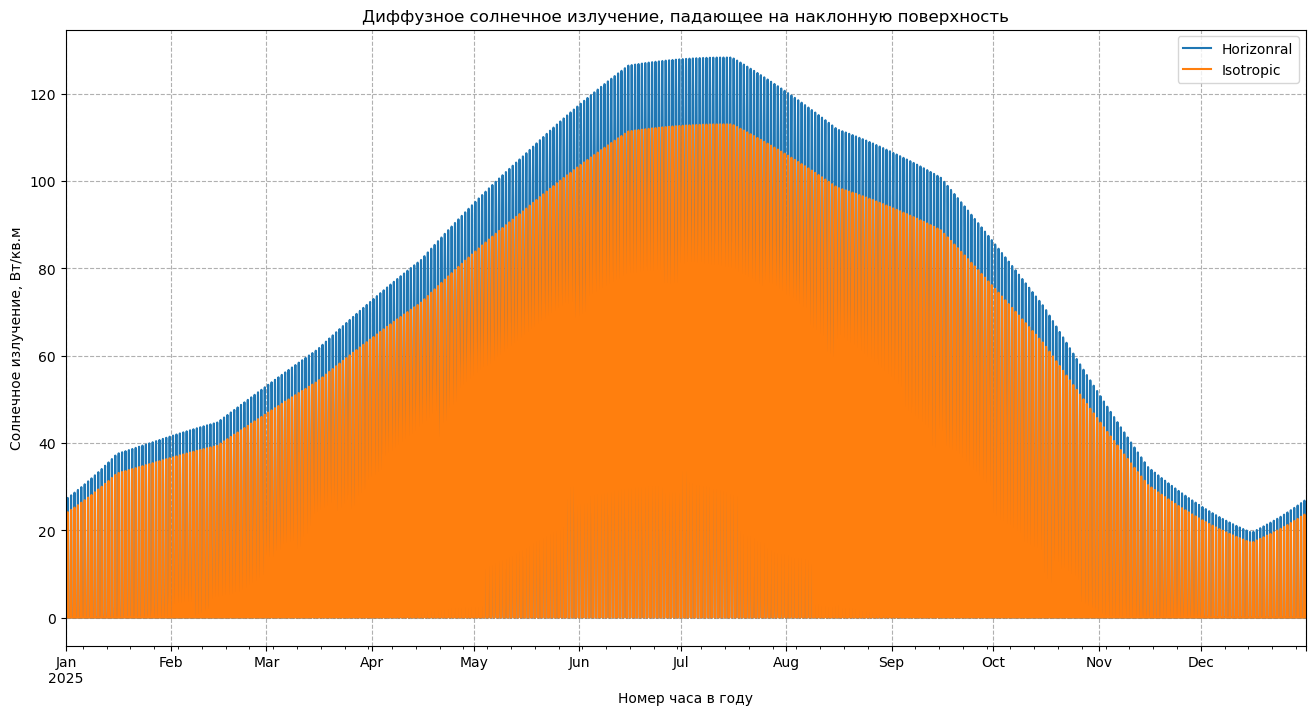

In [42]:
DiffuseIrradiation.plot(figsize=(16,8), label='Horizonral')
DiffuseSky_isotropic.plot(label='Isotropic')
plt.legend()
plt.grid(linestyle='--')
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Номер часа в году')
plt.title('Диффузное солнечное излучение, падающее на наклонную поверхность')
plt.show()

## 3.1.2 Анизотропная небесная сфера
### Модуль ``pvlib.irradiance.perez``

Модуль ``pvlib.irradiance.perez(surface_tilt, surface_azimuth, dhi, dni, dni_extra, solar_zenith, solar_azimuth, airmass, model='allsitescomposite1990', return_components=False)`` позволяет определить диффузное излучение, падающее на наклонную поверхность, используя одну из моделей Переса (Perez).

Модели Переса (Perez) определяют диффузное излучение (отраженное от земли излучение не учитывается в этом алгоритме), попадающее на наклонную поверхность в зависимости от:
- угла наклона поверхности к горизонту,
- азимута поверхности,
- диффузного  излучения на горизонтальной поверхности,
- прямого нормального излучения,
- внеземного излучения,
- зенитного угла солнца,
- азимутального угла Солнца,
- относительной (без учёта атмосферного давления) воздушной массы.
При желании можно использовать любой из наборов коэффициентов модели Переса (Perez).
    
### Параметры:	

- ``surface_tilt`` (numeric) – Угол наклона поверхности к горизонту в градусах. Наклон должен быть >=0 и <=180.
- ``surface_azimuth`` (numeric) – Аазимут поверхности в градусах. Азимут должен быть >=0 и <=360. Азимут отсчитывается к востоку от севера (например, север=0, восток=90, юг=180, запад=270).
- ``dhi`` (numeric) – Диффузная составляющая солнечного излучения, падающая на горизонтальную поверхность, Вт/ м^2. Значения DHI должны быть >=0.
- ``dni`` (numeric) – Прямое нормальное солнечное излучение, Вт/ м^2. Значения DNI должны быть >=0.
- ``dni_extra`` (numeric) – Солнечное излучение на верхней границе атмосферы в Вт/м^2.
- ``solar_zenith`` (numeric) – Кажущийся (с поправкой на преломление) зенитный угол в градусах, должен быть >=0 и <=180.
- ``solar_azimuth`` (numeric) – Азимутальный угол Солнца в градусах. Должен быть >=0 и <=360.
- ``airmass`` (numeric) – Относительная (без поправки на атмосферное давление) атмосферная масса. Если AM - DataFrame, то он должен быть того же размера, что и все другие входные данные DataFrame. AM должна быть >=0.
- ``model`` (string (optional, default='allsitescomposite1990')) – Указывается желаемый набор коэффициентов модели Переса (Perez). Если модель не указана в качестве входных данных, будет использоваться значение по умолчанию «1990». Возможные варианты моделей:
            ’1990’
            ’allsitescomposite1990’ (тоже самое, что и модель ‘1990’)
            ’allsitescomposite1988’
            ’sandiacomposite1988’
            ’usacomposite1988’
            ’france1988’
            ’phoenix1988’
            ’elmonte1988’
            ’osage1988’
            ’albuquerque1988’
            ’capecanaveral1988’
            ’albany1988’
- ``return_components`` (bool (optional, default=False)) – Флаг, используемый для указания, возвращать ли вычисленные диффузные компоненты солнечного излучения или нет.

### Результаты:	
- numeric, OrderedDict, or DataFrame – Если return_components=False, то sky_diffuse не возвращается. Если return_components=True, то diffuse_components возвращается.
- ``sky_diffuse`` (numeric) – Диффузная составляющая солнечного излучения, падающая на наклонную поверхность.
- ``diffuse_components`` (OrderedDict (array input) or DataFrame (Series input)) – Составляющие:
                sky_diffuse: Общая сумма диффузной составляющей
                isotropic - изотропная составляющая
                circumsolar - околосолнечная составляющая
                horizon - составляющая "горизонтальная"

### Список использованных источников:

[1]	Loutzenhiser P.G. et. al. “Empirical validation of models to compute solar irradiance on inclined surfaces for building energy simulation” 2007, Solar Energy vol. 81. pp. 254-267. http://www.physics.arizona.edu/~cronin/Solar/References/Irradiance%20Models%20and%20Data/LMF07.pdf

[2]	Perez, R., Seals, R., Ineichen, P., Stewart, R., Menicucci, D., 1987. A new simplified version of the Perez diffuse irradiance model for tilted surfaces. Solar Energy 39(3), 221-232. http://www.physics.arizona.edu/~cronin/Solar/References/Shade%20effects/sdarticle%20(24).pdf

[3]	Perez, R., Ineichen, P., Seals, R., Michalsky, J., Stewart, R., 1990. Modeling daylight availability and irradiance components from direct and global irradiance. Solar Energy 44 (5), 271-289. http://www.cuepe.ch/html/biblio/pdf/perez-ineichen%201990%20-%20modelling%20daylight%20(se).pdf

[4]	Perez, R. et. al 1988. “The Development and Verification of the Perez Diffuse Radiation Model”. SAND88-7030. https://pdfs.semanticscholar.org/2132/4d502d248d9a415447a7a1abc3536e163d90.pdf

In [43]:
DiffuseSky_Perez = pvlib.irradiance.perez(surface_tilt, 
                       surface_azimuth, 
                       DiffuseIrradiation, 
                       SimpleClearSky['dni'], 
                       DNI_extra, 
                       SPA['apparent_zenith'], 
                       SPA['azimuth'], 
                       airmass_relative, 
                       model='allsitescomposite1990', 
                       return_components=False)
DiffuseSky_Perez

2025-01-01 00:00:00+03:00    0.0
2025-01-01 01:00:00+03:00    0.0
2025-01-01 02:00:00+03:00    0.0
2025-01-01 03:00:00+03:00    0.0
2025-01-01 04:00:00+03:00    0.0
                            ... 
2025-12-31 19:00:00+03:00    0.0
2025-12-31 20:00:00+03:00    0.0
2025-12-31 21:00:00+03:00    0.0
2025-12-31 22:00:00+03:00    0.0
2025-12-31 23:00:00+03:00    0.0
Length: 8760, dtype: float64

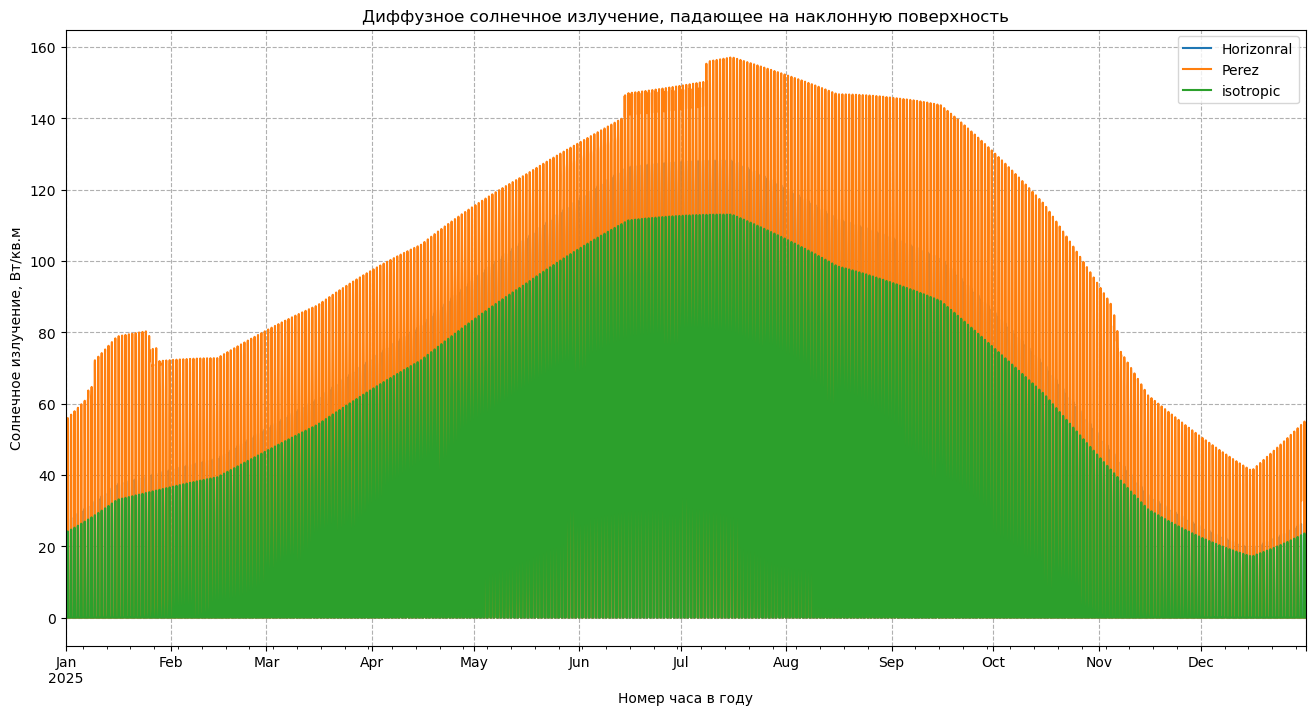

In [44]:
DiffuseIrradiation.plot(figsize=(16,8), label='Horizonral')
DiffuseSky_Perez.plot(label='Perez')
DiffuseSky_isotropic.plot(label='isotropic')
plt.legend()
plt.grid(linestyle='--')
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Номер часа в году')
plt.title('Диффузное солнечное излучение, падающее на наклонную поверхность')
plt.show()

## 3.1.3 Отражённое от земли солнечное излучение
### Модуль ``pvlib.irradiance.get_ground_diffuse``

Модуль ``pvlib.irradiance.get_ground_diffuse(surface_tilt, ghi, albedo=0.25, surface_type=None)`` позволяет оценить диффузное излучение, отражённое от поверхности земли, учитывая излучение, альбедо и наклон поверхности.

### Параметры:	
- ``surface_tilt`` (numeric) – Surface tilt angles in decimal degrees. Tilt must be >=0 and <=180. The tilt angle is defined as degrees from horizontal (e.g. surface facing up = 0, surface facing horizon = 90).
- ``ghi`` (numeric) – Global horizontal irradiance in W/m^2.
- ``albedo`` (numeric, default 0.25) – Ground reflectance, typically 0.1-0.4 for surfaces on Earth (land), may increase over snow, ice, etc. May also be known as the reflection coefficient. Must be >=0 and <=1. Will be overridden if surface_type is supplied.
- ``surface_type`` (None or string, default None) – If not None, overrides albedo. String can be one of ‘urban’, ‘grass’, ‘fresh grass’, ‘snow’, ‘fresh snow’, ‘asphalt’, ‘concrete’, ‘aluminum’, ‘copper’, ‘fresh steel’, ‘dirty steel’, ‘sea’.

### Результаты:	
- ``grounddiffuse`` (numeric) – Отражённое поверхностью земли солнечное излучение, Вт/м^2.

### Список использованных источников:

[1]	Loutzenhiser P.G. et. al. “Empirical validation of models to compute solar irradiance on inclined surfaces for building energy simulation” 2007, Solar Energy vol. 81. pp. 254-267.

[2]	albedos from: http://files.pvsyst.com/help/albedo.htm and http://en.wikipedia.org/wiki/Albedo and https://doi.org/10.1175/1520-0469(1972)029<0959:AOTSS>2.0.CO;2

In [45]:
DiffuseGround = pvlib.irradiance.get_ground_diffuse(surface_tilt, 
                                    NASA_data['ALLSKY_SFC_SW_DWN'], 
                                    albedo=NPS_data['Albedo'].values, 
                                    surface_type=None)
DiffuseGround

time
2025-01-01 00:00:00+03:00    0.0
2025-01-01 01:00:00+03:00    0.0
2025-01-01 02:00:00+03:00    0.0
2025-01-01 03:00:00+03:00    0.0
2025-01-01 04:00:00+03:00    0.0
                            ... 
2025-12-31 19:00:00+03:00    0.0
2025-12-31 20:00:00+03:00    0.0
2025-12-31 21:00:00+03:00    0.0
2025-12-31 22:00:00+03:00    0.0
2025-12-31 23:00:00+03:00    0.0
Name: diffuse_ground, Length: 8760, dtype: object

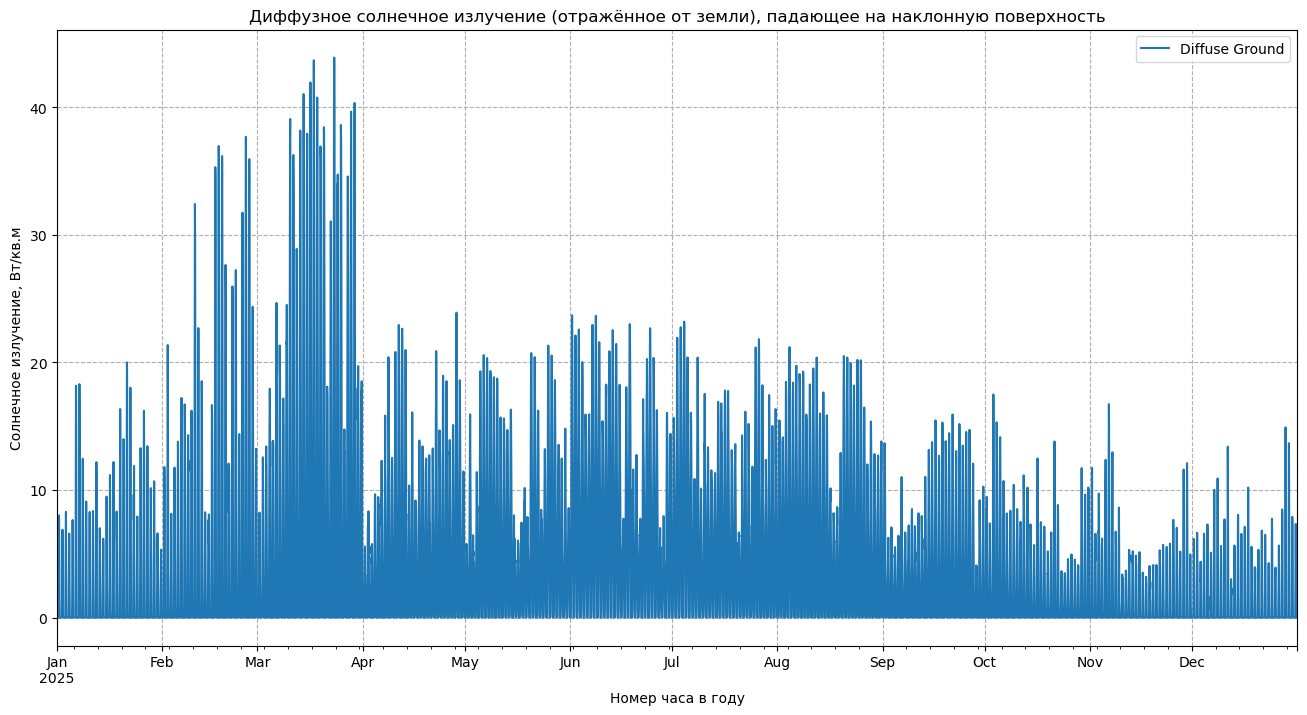

In [46]:
DiffuseGround.plot(figsize=(16,8), label='Diffuse Ground')
plt.legend()
plt.grid(linestyle='--')
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Номер часа в году')
plt.title('Диффузное солнечное излучение (отражённое от земли), падающее на наклонную поверхность')
plt.show()

## 3.2 Суммарное солнечное излучение, падающее в наклонной плоскости
## 3.2.1 Определение угла падения солнечных лучей на поверхность заданной ориентации
### Модуль ``pvlib.irradiance.aoi``

Модуль ``pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth)`` позволяет рассчитывать угол падения солнечных лучей на поверхность заданной ориентации (угол между солнечными лучами и нормалью к поверхности).

Все значения задаются в градусах.

### Параметры:
- ``surface_tilt`` (numeric) – Угол наклона поверхности к горизонту.
- ``surface_azimuth`` (numeric) – Азимут поверхности.
- ``solar_zenith`` (numeric) – Зенитный угол Солнца.
- ``solar_azimuth`` (numeric) – Азимутальный угол Солнца.

### Результаты:	
- ``aoi`` (numeric) – Угол падения солнечных лучей на поверхность (angle of incidence).

In [47]:
AOI = pvlib.irradiance.aoi(surface_tilt, 
                     surface_azimuth, 
                     SPA['zenith'], 
                     SPA['azimuth'])
AOI

2025-01-01 00:00:00+03:00    168.696636
2025-01-01 01:00:00+03:00    169.882843
2025-01-01 02:00:00+03:00    158.147338
2025-01-01 03:00:00+03:00    144.638199
2025-01-01 04:00:00+03:00    130.860967
                                ...    
2025-12-31 19:00:00+03:00    101.747998
2025-12-31 20:00:00+03:00    115.376449
2025-12-31 21:00:00+03:00    129.141836
2025-12-31 22:00:00+03:00    142.924183
2025-12-31 23:00:00+03:00    156.492017
Name: aoi, Length: 8760, dtype: float64

## Модуль ``pvlib.irradiance.poa_components``

Модуль ``pvlib.irradiance.poa_components(aoi, dni, poa_sky_diffuse, poa_ground_diffuse)`` позволяет определить  составляющие солнечного излучения (суммарная, прямая, диффузная и отражённая компоненты) в плоскости массива.

### Параметры:	
- ``aoi`` (numeric) – Угол падения солнечных лучей на поверхность.
- ``dni`` (numeric) – Прямая нормальная солнечная радиация DNI, Вт/м^2. Задается по данным натурных измерений в формате TMY-файла или рассчитывается с помощью модели ясного неба.
- ``poa_sky_diffuse`` (numeric) – Диффузная солнечная радиация (Вт/м^2), падающая на поверхность модулей
- ``poa_ground_diffuse`` (numeric) – Отражённая от земли солнечная радиация (Вт/м^2), падающая на поверхность модулей
        
### Результаты:	
- ``irrads`` (OrderedDict or DataFrame) – Содержит следующие столбцы:
        poa_global : Суммарная солнечная радиация, падающая на поверхность модулей (Вт/м^2)
        poa_direct : Прямая солнечная радиация, падающая на поверхность модулей (Вт/м^2)
        poa_diffuse : Диффузная и отражённая солнечная радиация, падающая на поверхность модулей (Вт/м^2)
        poa_sky_diffuse : Диффузная солнечная радиация, падающая на поверхность модулей (Вт/м^2)
        poa_ground_diffuse : Отражённая от земли солнечная радиация, падающая на поверхность модулей (Вт/м^2)

### Примечания:
При AOI > 90∘ или AOI < 0∘ могут возникать отрицательные значения солнечного излучения.

In [48]:
G = pvlib.irradiance.poa_components(AOI, 
                                SimpleClearSky['dni'], 
                                DiffuseSky_Perez, 
                                DiffuseGround)

G

poa_global  poa_direct poa_diffuse  poa_sky_diffuse  \
2025-01-01 00:00:00+03:00        0.0         0.0         0.0              0.0   
2025-01-01 01:00:00+03:00        0.0         0.0         0.0              0.0   
2025-01-01 02:00:00+03:00        0.0         0.0         0.0              0.0   
2025-01-01 03:00:00+03:00        0.0         0.0         0.0              0.0   
2025-01-01 04:00:00+03:00        0.0         0.0         0.0              0.0   
...                              ...         ...         ...              ...   
2025-12-31 19:00:00+03:00        0.0         0.0         0.0              0.0   
2025-12-31 20:00:00+03:00        0.0         0.0         0.0              0.0   
2025-12-31 21:00:00+03:00        0.0         0.0         0.0              0.0   
2025-12-31 22:00:00+03:00        0.0         0.0         0.0              0.0   
2025-12-31 23:00:00+03:00        0.0         0.0         0.0              0.0   

                          poa_ground_diffuse  
2025-01-01 00:00:00+03:00                0.0  
2025-01-01 01:00:00+03:00                0.0  
2025-01-01 02:00:00+03:00                0.0  
2025-01-01 03:00:00+03:00                0.0  
2025-01-01 04:00:00+03:00                0.0  
...                                      ...  
2025-12-31 19:00:00+03:00                0.0  
2025-12-31 20:00:00+03:00                0.0  
2025-12-31 21:00:00+03:00                0.0  
2025-12-31 22:00:00+03:00                0.0  
2025-12-31 23:00:00+03:00                0.0  

[8760 rows x 5 columns]

### 3.2.2 Определение оптимальной ориентации приёмной поверхности

Впределение оптимальной ориентации приёмной поверхности выполним простейшим способом - полным перебором среди заданных значений азимута приёмной поверхности SA и угла наклона приёмной поверхности ST.

In [49]:
SA = [180] # Заданные значения азимута приёмной поверхности
ST = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 51] # Заданные значения угла наклона приёмной поверхности

print('Суммарное солнечное излучение в плоскости заданной ориентации, МВтч/кв.м в год')
print('(на основе данных полученных по моделям ясного неба):')
print('GHI =', round(NASA_data['ALLSKY_SFC_SW_DWN'].sum()/1000000,3))

for surface_azimuth in SA: # Для каждого из заданных значений азимута приёмной поверхности
    print('Азимут приёмной поверхности, град.:', surface_azimuth)
    # Для каждого из заданных значений угла наклона приёмной поверхности
    for surface_tilt in ST:
        # Определим диффузную составляющую солнечного излучения
        DiffuseSky_Perez = pvlib.irradiance.perez(surface_tilt, 
                       surface_azimuth, 
                       DiffuseIrradiation, 
                       SimpleClearSky['dni'], 
                       DNI_extra, 
                       SPA['apparent_zenith'], 
                       SPA['azimuth'], 
                       airmass_relative, 
                       model='allsitescomposite1990', 
                       return_components=False)
        # Определим отражённую от земли солнечную радиацию
        DiffuseGround = pvlib.irradiance.get_ground_diffuse(surface_tilt, 
                                    NASA_data['ALLSKY_SFC_SW_DWN'], 
                                    albedo=NPS_data['Albedo'].values, 
                                    surface_type=None)
        # Рассчитаем угло падения солнечных лучей на приёмную поверхность
        AOI = pvlib.irradiance.aoi(surface_tilt, 
                     surface_azimuth, 
                     SPA['zenith'], 
                     SPA['azimuth'])
        # Определим все компоненты суммарной солнечной радиации в заданной плоскости
        G = pvlib.irradiance.poa_components(AOI, 
                                SimpleClearSky['dni'], 
                                DiffuseSky_Perez, 
                                DiffuseGround)
        # Расситаем годвую сумму суммарной солнечной радиации
        Gsum = G['poa_global'].sum()
        # Выведем информацию на экран
        print('   Угол наклона поверхности', surface_tilt, ' град.: ', round(Gsum/1000000, 3),  '       прирост - ',round(Gsum/NASA_data['ALLSKY_SFC_SW_DWN'].sum()*100-100,1), '%')

Суммарное солнечное излучение в плоскости заданной ориентации, МВтч/кв.м в год
(на основе данных полученных по моделям ясного неба):
GHI = 1.059
Азимут приёмной поверхности, град.: 180
   Угол наклона поверхности 0  град.:  1.466        прирост -  38.4 %
   Угол наклона поверхности 10  град.:  1.697        прирост -  60.3 %
   Угол наклона поверхности 20  град.:  1.885        прирост -  78.0 %
   Угол наклона поверхности 30  град.:  2.024        прирост -  91.1 %
   Угол наклона поверхности 40  град.:  2.11        прирост -  99.2 %
   Угол наклона поверхности 50  град.:  2.143        прирост -  102.3 %
   Угол наклона поверхности 60  град.:  2.118        прирост -  100.0 %
   Угол наклона поверхности 70  град.:  2.036        прирост -  92.2 %
   Угол наклона поверхности 80  град.:  1.903        прирост -  79.7 %
   Угол наклона поверхности 90  град.:  1.724        прирост -  62.8 %
   Угол наклона поверхности 51  град.:  2.143        прирост -  102.4 %


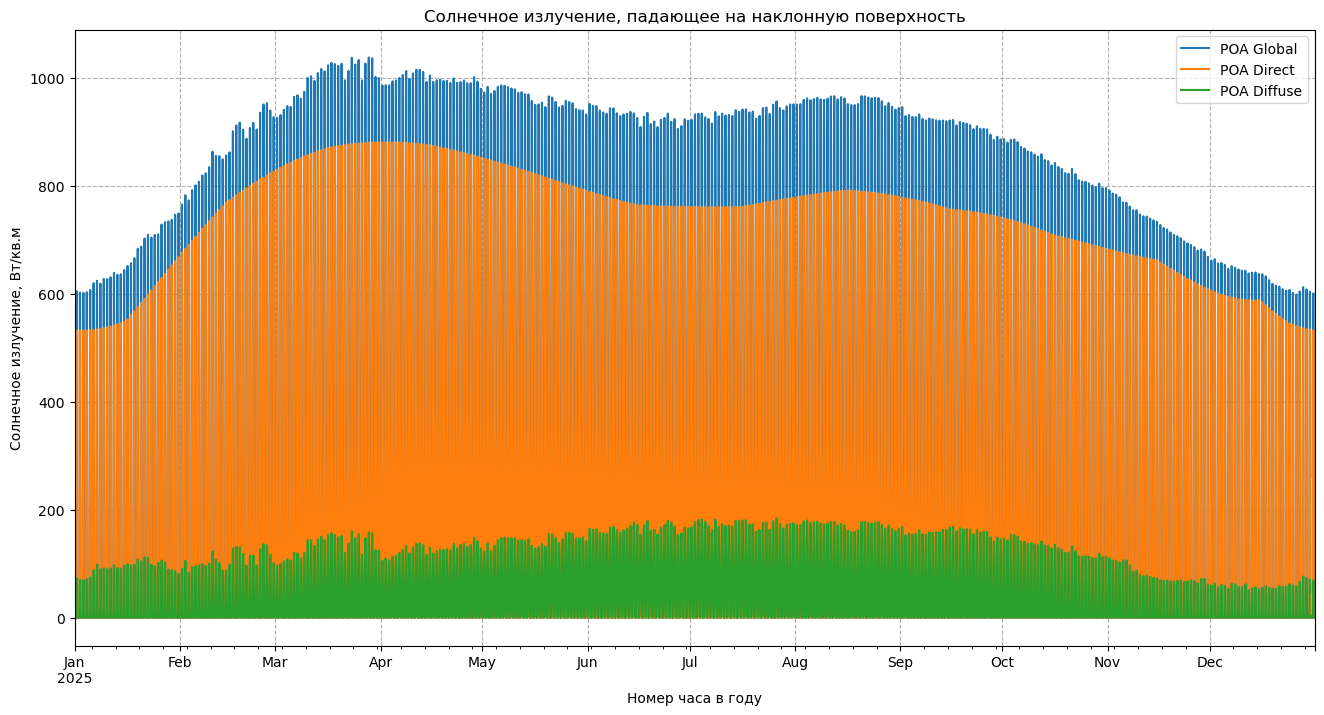

In [50]:
G['poa_global'].plot(figsize=(16,8), label='POA Global')
G['poa_direct'].plot(label='POA Direct')
G['poa_diffuse'].plot(label='POA Diffuse')
plt.legend()
plt.grid(linestyle='--')
plt.ylabel('Солнечное излучение, Вт/кв.м')
plt.xlabel('Номер часа в году')
plt.title('Солнечное излучение, падающее на наклонную поверхность')
plt.show()

### 3.2.3 Анализ полученной информации
Полученная годовая сумма солнечного излучения, падающего на оптимально-ориентированную поверхность в два раза превышает соответствующий показатель для горизонтальной поверхности, что противоречит теоретическим положениям.
Судя по всему это связано с тем, что прямая нормальная радиация (DNI) рассчитана для условий ясного неба.

Рекомендуется использовать другой источник информации по DNI.

Ниже рассмотрена возможность использования двух альтернативный вариантов:
1. Функции `pvlib.irradiance.dni`, позволяющей оценить величину DNI по известным значениям суммарной солнечной радиации (GHI) и диффузной солнечной радиации (DHI). 
2. В базе данных наса содержится информация о прямой нормальной радиации - ALLSKY_SFC_SW_DNI

## Функция `pvlib.irradiance.dni`

Функция `pvlib.irradiance.dni(ghi, dhi, zenith, clearsky_dni=None, clearsky_tolerance=1.1, zenith_threshold_for_zero_dni=88.0, zenith_threshold_for_clearsky_limit=80.0)` позволяет оценить величину DNI по известным значениям суммарной солнечной радиации (GHI) и диффузной солнечной радиации (DHI).

При вычислении значения DNI на основе GHI и DHI рассчитанное значение DNI может быть неоправданно высоким или отрицательным для зенитных углов, близких к 90 градусам (переходы между восходом и заходом солнца). Эта функция определяет необоснованные значения DNI и присваивает им значение NaN. Если для параметра clear sky DNI заданы неоправданно высокие значения, они отключаются.

### Параметры:
- `ghi` (Series) – Суммарное солнечное излучение в горизонтальной плоскости.
- `dhi` (Series) – Диффузное солнечное излучение в горизонтальной плоскости.
- `zenith` (Series) – Истинные зенитные углы (без коррекции на рефракцию) в десятичных градусах. Значения должны лежать в диапазоне >=0 и <=180.
- `clearsky_dni` (Series, optional) – Прямая нормальная радиация при ясном небе.
- `clearsky_tolerance` (float, default 1.1) – Если задан параметр ‘clearsky_dni’, то этот параметр можно использовать для определения допуска на величину, на которую вычисленное значение DNI может превышать значение clearsky, прежде чем оно будет идентифицировано как необоснованное значение.
- `zenith_threshold_for_zero_dni` (float, default 88.0) – Для зенитных углов, превышающих или равных ‘zenith_threshold_for_zero_dni’, ненулевые значения DNI будут установлены в NaN.
- `zenith_threshold_for_clearsky_limit` (float, default 80.0) – Значения DNI для зенитных углов, превышающих или равных ‘zenith_threshold_for_clearsky_limit’ и меньших zenith_threshold_for_zero_dni’, которые превышают значение clearsky DNI (допустимый допуск во времени), будут скорректированы. применяется только в том случае, если значение ‘clearsky_dni’ не равно None.

### Результаты:
- `dni` (Series) – Смоделированные значения прямой нормальной радиации.

In [51]:
DirectNormalIrradiance = pvlib.irradiance.dni(NASA_data['ALLSKY_SFC_SW_DWN'], 
                     NASA_data['ALLSKY_SFC_SW_DIFF'], 
                     SPA['zenith'], 
                     clearsky_dni=None, 
                     clearsky_tolerance=1.1, 
                     zenith_threshold_for_zero_dni=88.0, 
                     zenith_threshold_for_clearsky_limit=80.0)

print('Годовая сумма DNI, полученная функцией dni, МВтч/кв.м  :', round(DirectNormalIrradiance.sum() / 1000000,3))
print('Годовая сумма DNI, полученная из БД NASA SSE, МВтч/кв.м:', round(NASA_data['ALLSKY_SFC_SW_DNI'].sum() / 1000000, 3))

Годовая сумма DNI, полученная функцией dni, МВтч/кв.м  : 1.334
Годовая сумма DNI, полученная из БД NASA SSE, МВтч/кв.м: 1.197


In [52]:
# Повторим расчёт солнечного излучения, падающего в плоскостях заданной ориентации, но теперь
# будем использовать данные DNI, рассчитанные функцией dni

# Также добавим в этот блок запись полученной информации в отдельный dataframe.
# Для этого создадим его пустым с двумя столбцами: 
# surf_tilt - угол наклона поверхности к горизонту
# Gsum_year - годовая сумма суммарного солнечного излучения
TiltedSurface = pd.DataFrame(columns=['surf_tilt', 'Gsum_year'])
i = 0

SA = [180] # Заданные значения азимута приёмной поверхности
ST = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 51] # Заданные значения угла наклона приёмной поверхности


print('Суммарное солнечное излучение в плоскости заданной ориентации, МВтч/кв.м в год')
print('(на основе данных полученных по моделям ясного неба):')
print('GHI =', round(NASA_data['ALLSKY_SFC_SW_DWN'].sum()/1000000,3))

for surface_azimuth in SA: # Для каждого из заданных значений азимута приёмной поверхности
    print('Азимут приёмной поверхности, град.:', surface_azimuth)
    # Для каждого из заданных значений угла наклона приёмной поверхности
    for surface_tilt in ST:
        # Определим диффузную составляющую солнечного излучения
        DiffuseSky_Perez = pvlib.irradiance.perez(surface_tilt, 
                       surface_azimuth, 
                       DiffuseIrradiation, 
                       DirectNormalIrradiance, 
                       DNI_extra, 
                       SPA['apparent_zenith'], 
                       SPA['azimuth'], 
                       airmass_relative, 
                       model='allsitescomposite1990', 
                       return_components=False)
        # Определим отражённую от земли солнечную радиацию
        DiffuseGround = pvlib.irradiance.get_ground_diffuse(surface_tilt, 
                                    NASA_data['ALLSKY_SFC_SW_DWN'], 
                                    albedo=NPS_data['Albedo'].values, 
                                    surface_type=None)
        # Рассчитаем угло падения солнечных лучей на приёмную поверхность
        AOI = pvlib.irradiance.aoi(surface_tilt, 
                     surface_azimuth, 
                     SPA['zenith'], 
                     SPA['azimuth'])
        # Определим все компоненты суммарной солнечной радиации в заданной плоскости
        G = pvlib.irradiance.poa_components(AOI, 
                                DirectNormalIrradiance, 
                                DiffuseSky_Perez, 
                                DiffuseGround)
        # Расситаем годвую сумму суммарной солнечной радиации
        Gsum = G['poa_global'].sum()
        
        TiltedSurface.loc[i, 'surf_tilt'] = surface_tilt # в i-ую строчку dataframe запишем 
        TiltedSurface.loc[i, 'Gsum_year'] = Gsum / 1000000 # соответствующие значения
        i = i + 1
        
        # Выведем информацию на экран
        #print('   Угол наклона поверхности', surface_tilt, ' град.: ', round(Gsum/1000000, 3),  '       прирост - ',round(Gsum/NASA_data['ALLSKY_SFC_SW_DWN'].sum()*100-100,1), '%')

TiltedSurface = TiltedSurface.sort_values(by=['surf_tilt'])
TiltedSurface

Суммарное солнечное излучение в плоскости заданной ориентации, МВтч/кв.м в год
(на основе данных полученных по моделям ясного неба):
GHI = 1.059
Азимут приёмной поверхности, град.: 180


surf_tilt Gsum_year
0          0  0.830076
1         10  0.921095
2         20  0.996621
3         30  1.051369
4         40  1.083456
5         50  1.093069
10        51  1.092598
6         60  1.076614
7         70  1.034515
8         80  0.970505
9         90   0.88673

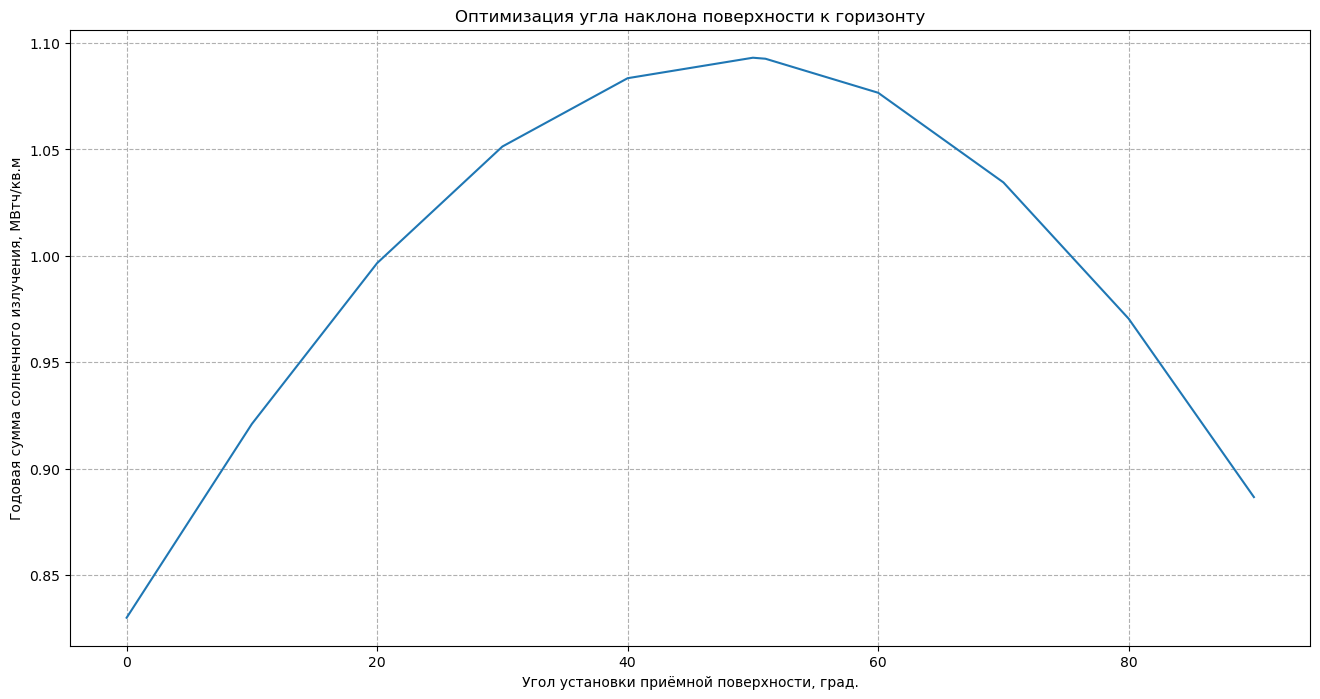

In [53]:
x = TiltedSurface['surf_tilt']
y = TiltedSurface['Gsum_year']
plt.figure(figsize=(16, 8))
plt.plot(x, y)
plt.grid(linestyle='--')
plt.ylabel('Годовая сумма солнечного излучения, МВтч/кв.м')
plt.xlabel('Угол установки приёмной поверхности, град.')
plt.title('Оптимизация угла наклона поверхности к горизонту')
plt.show()

### 3.2.4 Получение месячных сумм солнечного излучения

In [54]:
# Создадим пустой dataframe для хранения месячных сумм суммарной, диффузной и прямой
# солнечной радиации
IrradianceOnTiltedSurface = pd.DataFrame(index=range(12),
                                        columns=['Month', 'Global', 'Diffuse', 'Direct'])

# Для  каждого месяца года "вырежем" нужный дипазон из переменной G, в которой хранятся
# рассчитанные значения составляющих солнечного излучения, падающего в плоскости заданной
# ориентации
for mm in range(12):
    m = mm + 1
    if m==1: date_range = G.loc['2025-01-01':'2025-01-31']
    if m==2: date_range = G.loc['2025-02-01':'2025-02-28']
    if m==3: date_range = G.loc['2025-03-01':'2025-03-31']
    if m==4: date_range = G.loc['2025-04-01':'2025-04-30']
    if m==5: date_range = G.loc['2025-05-01':'2025-05-31']
    if m==6: date_range = G.loc['2025-06-01':'2025-06-30']
    if m==7: date_range = G.loc['2025-07-01':'2025-07-31']
    if m==8: date_range = G.loc['2025-08-01':'2025-08-31']
    if m==9: date_range = G.loc['2025-09-01':'2025-09-30']
    if m==10: date_range = G.loc['2025-10-01':'2025-10-31']
    if m==11: date_range = G.loc['2025-11-01':'2025-11-30']
    if m==12: date_range = G.loc['2025-12-01':'2025-12-31']
    
    # Месячные суммы записшем в соответствующие столбцы (в кВтч/кв.м за месяц)
    IrradianceOnTiltedSurface.loc[mm, 'Month'] = m
    IrradianceOnTiltedSurface.loc[mm, 'Global'] = date_range['poa_global'].sum() / 1000
    IrradianceOnTiltedSurface.loc[mm, 'Diffuse'] = date_range['poa_diffuse'].sum() / 1000
    IrradianceOnTiltedSurface.loc[mm, 'Direct'] = date_range['poa_direct'].sum() / 1000
IrradianceOnTiltedSurface

Month      Global    Diffuse      Direct
0      1   32.198923  10.266861       22.15
1      2   60.230285  16.682172   43.856555
2      3   98.754995  30.063677   69.018137
3      4   93.321237  32.692658   60.745267
4      5  130.269451  43.055663   87.290562
5      6  144.629395  50.329244   94.373137
6      7  131.851518  50.873852    81.07483
7      8  164.473424  46.833577  117.760258
8      9  103.440352  33.279951   70.258567
9     10   75.325193  22.106714   53.356007
10    11   32.370057   9.772176   22.731201
11    12   25.733516   7.073785   18.914218

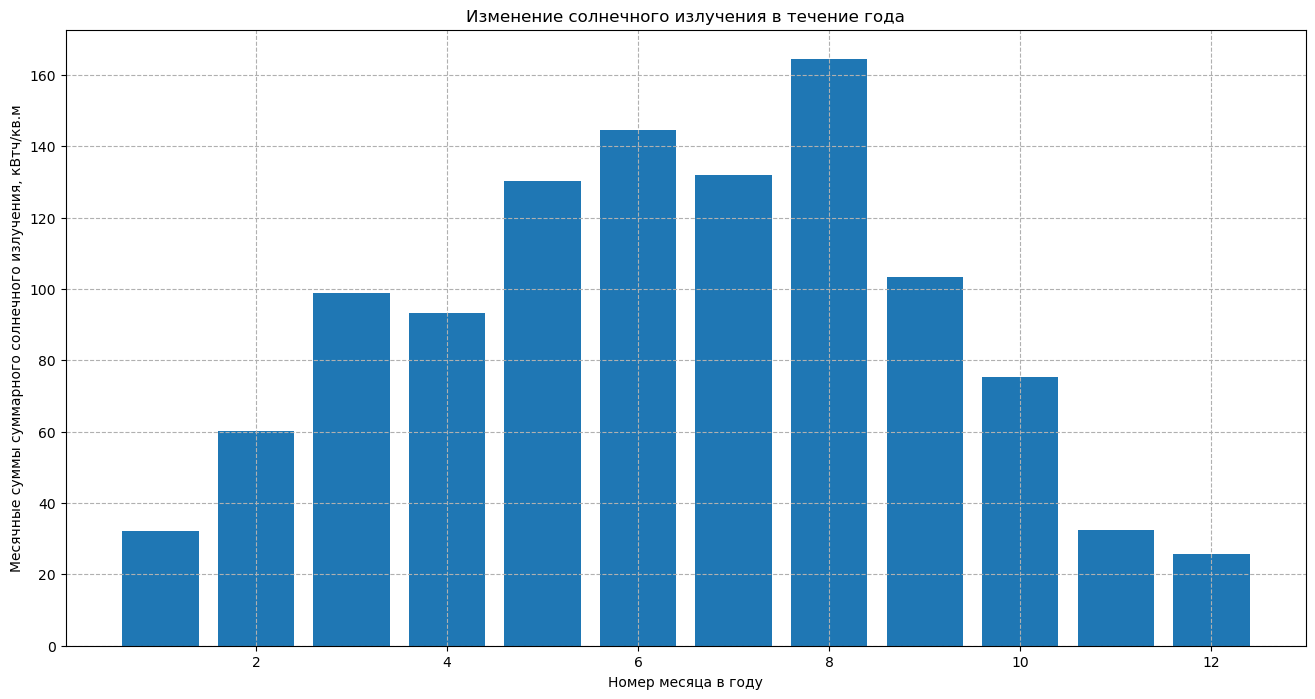

In [55]:
# Построим график изменения солнечного излучения в течение года
plt.figure(figsize=(16, 8))
plt.bar(range(1,13), IrradianceOnTiltedSurface['Global'])
plt.grid(linestyle='--')
plt.ylabel('Месячные суммы суммарного солнечного излучения, кВтч/кв.м')
plt.xlabel('Номер месяца в году')
plt.title('Изменение солнечного излучения в течение года')
plt.show()

# 4 Моделирование режима работы оборудования СЭС
## 4.1 Загрузка информации о ФЭМ

## Функция ``pvlib.pvsystem.retrieve_sam``

Функция ``pvlib.pvsystem.retrieve_sam(name=None, path=None)`` позволяет получить информацию о солнечном модуле из локального файла или с веб-сайта SAM, используя одну из баз данных:

    CEC module database
    Sandia Module database
    CEC Inverter database
    Anton Driesse Inverter database
    
### Параметры:	
- ``name`` (None or string, default None) – может принимать значения:
    1. ’CECMod’ - база данных "CEC" по солнечным модулям 
    2. ’CECInverter’ - база данных "CEC" по инверторам
    3. ’SandiaInverter’ - returns the CEC Inverter database (CEC is only current inverter db available; tag kept for backwards compatibility)
    4. ’SandiaMod’ - база данных "Sandia Module" по солнечным модулям
    5. ’ADRInverter’ - база данных "ADR Inverter database" по инвертора

- ``path`` (None or string, default None) – путь к SAM-файлу. Можно задать URL.

### Результаты:	
- ``samfile`` (DataFrame) – DataFrame, содержащий все элементы желаемой базы данных. Каждый столбец представляет модуль или инвертор, и конкретный набор данных может быть получен командой

### Примечания:
[1] SAM-файлы доступны здесь: https://github.com/NREL/SAM/tree/develop/deploy/libraries

[2] Документация по базам данных солнечных модулей и инверторов: https://sam.nrel.gov/photovoltaic/pv-sub-page-2.html 

In [56]:
# Загрузим БД по солнечным содулям от CEC
PV_Modules = pvlib.pvsystem.retrieve_sam(name=None, path='CEC_Modules.csv')
PV_Modules

C:\Users\vag\anaconda3\lib\site-packages\pvlib\pvsystem.py:2086: UserWarning: Original names contain 29 duplicate(s).
  warnings.warn('Original names contain %d duplicate(s).' % n_duplicates)
C:\Users\vag\anaconda3\lib\site-packages\pvlib\pvsystem.py:2090: UserWarning: Normalized names contain 29 duplicate(s).
  warnings.warn(


Ablytek_6MN6A270 Ablytek_6MN6A275 Ablytek_6MN6A280  \
Manufacturer          Ablytek          Ablytek          Ablytek   
Technology          Mono-c-Si        Mono-c-Si        Mono-c-Si   
Bifacial                    0                0                0   
STC                   270.643          275.191           280.09   
PTC                     242.1            246.7            251.3   
A_c                     1.627            1.627            1.627   
Length                   1.64             1.64             1.64   
Width                   0.992            0.992            0.992   
N_s                        60               60               60   
I_sc_ref                 9.34             9.42             9.51   
V_oc_ref                38.63            38.97            39.31   
I_mp_ref                 8.81             8.88             8.96   
V_mp_ref                30.72            30.99            31.26   
alpha_sc             0.004866         0.004908         0.004955   
beta_oc             -0.121182        -0.122249        -0.123315   
T_NOCT                   47.4             47.4             47.4   
a_ref                 1.58733          1.60182          1.61626   
I_L_ref               9.34243          9.42313          9.51376   
I_o_ref                   0.0              0.0              0.0   
R_s                  0.374013         0.374165          0.37392   
R_sh_ref               1440.5          1127.45          945.874   
Adjust                12.6561          12.7242           12.784   
gamma_r               -0.4509          -0.4509          -0.4509   
BIPV                        N                N                N   
Version            2023.10.31       2023.10.31       2023.10.31   
Date               11/16/2022       11/16/2022       11/16/2022   

             Ablytek_6MN6A285 Ablytek_6MN6A290 Advance_Power_API_P210  \
Manufacturer          Ablytek          Ablytek          Advance Power   
Technology          Mono-c-Si        Mono-c-Si             Multi-c-Si   
Bifacial                    0                0                      0   
STC                   285.031          290.016                210.148   
PTC                     256.0            260.6                  186.8   
A_c                     1.627            1.627                  1.638   
Length                   1.64             1.64                  1.646   
Width                   0.992            0.992                  0.995   
N_s                        60               60                     60   
I_sc_ref                 9.59             9.67                    7.6   
V_oc_ref                39.65            39.99                  35.94   
I_mp_ref                 9.04             9.12                   7.09   
V_mp_ref                31.53             31.8                  29.64   
alpha_sc             0.004996         0.005038               0.004376   
beta_oc             -0.124382        -0.125449              -0.120111   
T_NOCT                   47.4             47.4                   47.6   
a_ref                 1.62978          1.64329                1.52964   
I_L_ref               9.59321          9.67267                7.60815   
I_o_ref                   0.0              0.0                    0.0   
R_s                  0.374045         0.374168               0.247801   
R_sh_ref               1116.6          1357.41                231.181   
Adjust                12.7245           12.666                12.9624   
gamma_r               -0.4509          -0.4509                -0.4501   
BIPV                        N                N                      N   
Version            2023.10.31       2023.10.31             2023.10.31   
Date               11/16/2022       11/16/2022             11/16/2022   

             Advance_Power_API_P215 Advance_Power_API_P220  \
Manufacturer          Advance Power          Advance Power   
Technology               Multi-c-Si             Multi-c-Si   
Bifacial                          0          

In [57]:
# Простейший поиск по загруженной базе данных:

# Для удобства работы транспонируем таблицу
PV_Modules2 = PV_Modules.transpose()
# Установим в качестве индексов порядковые номера строк в таблице
PV_Modules2 = PV_Modules2.rename_axis('Name').reset_index()
# для каждой строчки в таблице выполним проверку по нескольким условиям
for i in range(len(PV_Modules2)):
    if PV_Modules2['STC'].iloc[i] >= 690: # по мощности
        if PV_Modules2['Technology'].iloc[i] == 'Mono-c-Si': # по типу СЭ, может быть:
                                                             # CdTe
                                                             # CIGS
                                                             # Mono-c-Si
                                                             # Multi-c-Si
                                                             # Thin Film
            if PV_Modules2['Bifacial'].iloc[i] == 0: # односторонний (0) или двусторонний (1)
                if PV_Modules2['V_oc_ref'].iloc[i] > 40: # по величине напряжения холостого хода
                    print(PV_Modules2['Name'].iloc[i])

Chint_New_Energy_Technology_Co__Ltd__CHSM66N_HC_690
Chint_New_Energy_Technology_Co__Ltd__CHSM66N_HC_695
Mate_Solar_Co__Ltd__MS690M_66H
Sunpal_Power_Co__Ltd__SP690M_66H


In [58]:
# Для примера выберем один солнечный модуль для дальнейшей работы
PV_Module = PV_Modules['Chint_New_Energy_Technology_Co__Ltd__CHSM66N_HC_695']
PV_Module

Manufacturer    Chint New Energy Technology Co. Ltd.
Technology                                 Mono-c-Si
Bifacial                                           0
STC                                          694.908
PTC                                            656.1
A_c                                             3.11
Length                                           NaN
Width                                            NaN
N_s                                               66
I_sc_ref                                       18.27
V_oc_ref                                        48.0
I_mp_ref                                       17.46
V_mp_ref                                        39.8
alpha_sc                                    0.007125
beta_oc                                     -0.11568
T_NOCT                                          45.0
a_ref                                         1.6631
I_L_ref                                      18.2718
I_o_ref                                       

## 4.2 Влияние внешних факторов на работу ФЭМ

In [59]:
# Оценка эффективной иррадиации

effective_irradiance = G['poa_global'] * 0.97

## Функция ``pvlib.pvsystem.sapm_celltemp``
Функция ``pvlib.pvsystem.sapm_celltemp(poa_global, wind_speed, temp_air, model='open_rack_cell_glassback')`` позволяет оценить температуру фотоэлемента в соответствии с моделью SAPM, исходя из освещенности, скорости ветра, температуры окружающей среды и параметров модуля SAPM.

## Параметры:	
- ``poa_global`` (float or Series) - Суммарная солнечная радиация, падающая на поверхность ФЭП, [Вт/м^2].
- ``wind_speed`` (float or Series) - Скорость ветра на высоте 10 м над поверхностью земли, [м/с].
- ``temp_air`` (float or Series) - Температура окружающего воздуха, [градусы Цельсия].
- ``model`` (string, list, or dict) - Используемая модель:
            ‘open_rack_glass_glass’
            ‘close_mount_glass_glass’
            ‘open_rack_glass_polymer’
            ‘insulated_back_glass_polymer’

## Результаты:	
- (float) - Значения температуры солнечного элемента, [градусы Цельсия].
    
## Использованные источники:

[1] King, D. et al, 2004, “Sandia Photovoltaic Array Performance Model”, SAND Report 3535, Sandia National Laboratories, Albuquerque, NM. https://energy.sandia.gov/wp-content/gallery/uploads/043535.pdf

In [60]:
# Эмпирически определённые коэффициенты, определяющие нагреы СЭ в зависиомсти от типа ФЭМ и способа их установки
a = -3.56
b = -0.075
deltaT = 3

# расчёт температуры СЭ на основе метеорологических данных из БД NASA SSE
Cells_temperature_NASA = pvlib.temperature.sapm_cell(G['poa_global'], 
                            NASA_data['T2M'], 
                            NASA_data['WS10M'], 
                            a, 
                            b, 
                            deltaT, 
                            irrad_ref=1000.0)
# расчёт температуры СЭ на основе метеорологических данных из ГИС PVGIS
Cells_temperature_PVGIS = pvlib.temperature.sapm_cell(G['poa_global'], 
                            PVGIS_data['temp_air'], 
                            PVGIS_data['wind_speed'], 
                            a, 
                            b, 
                            deltaT, 
                            irrad_ref=1000.0)

In [61]:
print('Минимальная температура окр.воздуха:', NASA_data['T2M'].min())
print('Максимальная температура окр.воздуха:', NASA_data['T2M'].max())
print()
print('   Минимальная температура по NASA:', round(Cells_temperature_NASA.min(),2))
print('   Минимальная температура по PVGIS:', round(Cells_temperature_PVGIS.min(),2))
print()
print('   Максимальная температура по NASA:', round(Cells_temperature_NASA.max(),2))
print('   Максимальная температура по PVGIS:', round(Cells_temperature_PVGIS.max(),2))

Минимальная температура окр.воздуха: -30.13
Максимальная температура окр.воздуха: 28.3

   Минимальная температура по NASA: -29.99
   Минимальная температура по PVGIS: -22.47

   Максимальная температура по NASA: 54.27
   Максимальная температура по PVGIS: 55.32


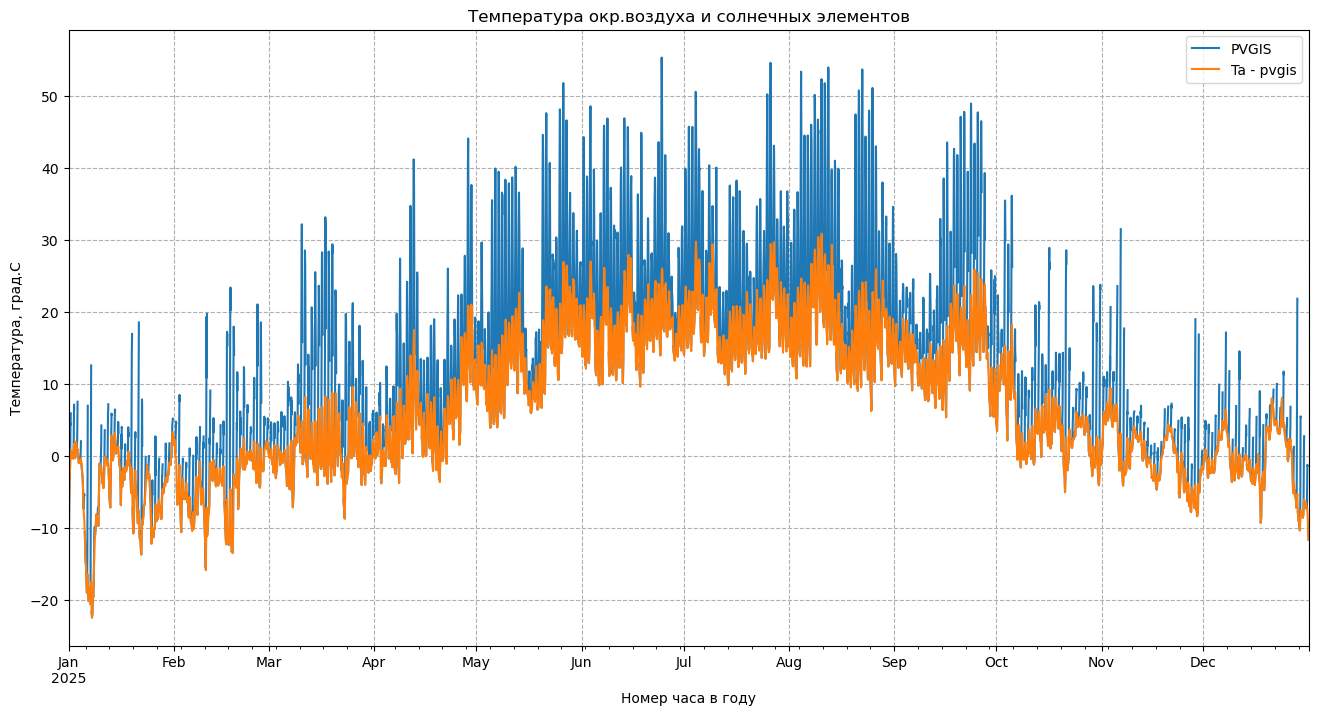

In [62]:
#Cells_temperature_NASA.plot(figsize=(16,8), label='NASA')
Cells_temperature_PVGIS.plot(figsize=(16,8), label='PVGIS')
PVGIS_data['temp_air'].plot(label='Ta - pvgis')
plt.legend()
plt.grid(linestyle='--')
plt.ylabel('Температура, град.C')
plt.xlabel('Номер часа в году')
plt.title('Температура окр.воздуха и солнечных элементов')
plt.show()

In [63]:
# Для примера рассмотрена также функция pvlib.temperature.pvsyst_cell:
# требуется проверка, какая эффективность моделя используется - номинальная или текущая
#
#
Eff_ref = PV_Module['STC'] / (PV_Module['A_c'] * 1000)

Cells_temperature_PVSYST = pvlib.temperature.pvsyst_cell(G['poa_global'], 
                              NASA_data['T2M'], 
                              NASA_data['WS10M'], 
                              u_c=29.0, 
                              u_v=0.0, 
                              module_efficiency=0.1, 
                              alpha_absorption=0.9)
print('Минимальная температура по PVSYST:', Cells_temperature_PVSYST.min())
print('Максимальная температура по PVSYST:', Cells_temperature_PVSYST.max())

Минимальная температура по PVSYST: -29.99
Максимальная температура по PVSYST: 54.569025204876226


In [64]:
T_minimum = min(Cells_temperature_PVGIS.min(), Cells_temperature_NASA.min())
print('Минимальная температура окуржующего воздуха, гр.Цельсия: ', T_minimum)

T_maximum = max(Cells_temperature_PVGIS.max(), Cells_temperature_NASA.max())
print('Максимальная температура окуржующего воздуха, гр.Цельсия:', T_maximum)

Минимальная температура окуржующего воздуха, гр.Цельсия:  -29.99
Максимальная температура окуржующего воздуха, гр.Цельсия: 55.32499395494285


## 4.3 Построение ВАХ ФЭМ при стандартных условиях


# Функция ``pvlib.pvsystem.singlediode``

Функция ``pvlib.pvsystem.singlediode(photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth, ivcurve_pnts=None, method='lambertw')`` позволяет смоделироать ВАХ солнечного модуля на основе модели с одним диодом. Основное уравнение этой модели [1]:

    I=IL−I0∗[exp((V+I∗Rs)/(nNsVth))−1]−(V+I∗Rs)/Rsh                  (1)

Входные параметры могут быть рассчитаны с использованием calcparams_desoto на основе метеорологических данных.

## Параметры:	
- ``photocurrent`` (numeric) – Фототок при заданных условиях, (А).
- ``saturation_current`` (numeric) – Ток насыщения диода при заданных условиях, (А)
- ``resistance_series`` (numeric) – Последовательное сопротивление при заданных условиях, (Ом).
- ``resistance_shunt`` (numeric) – Параллельное сопротивление при заданных условиях, (Ом).
- ``nNsVth`` (numeric) – Произведение коэффициента идеальности диода (n), количества последовательно соединённых элементов (Ns) и термального напряжения при заданной эффективной иррадиации и температуре фотоэлемента.
- ``ivcurve_pnts`` (None or int, default None) – Количество точек на моделируемой ВАХ. Если задать None или 0, ВАХ не будут получены.
- ``method`` (str, default 'lambertw') – Определяет метод, используемый для расчета точек ВАХ. Возможные варианты: 'lambertw', 'newton', or 'brentq'.

## Результаты:	
Массив со столбцами:

        ``i_sc`` - ток короткого замыкания, (А).
        ``v_oc`` - напряжение холостого хода, (В).
        ``i_mp`` - ток в точке максимальной мощности, (А).
        ``v_mp`` - напряжение в точке максимальной мощности, (В).
        ``p_mp`` - максимальная мощность, (Вт).
        ``i_x`` - ток, (А), при напряжении V = 0.5 * v_oc.
        ``i_xx`` - ток, (А), при напряжении V = 0.5*(v_oc+v_mp).

## Примечания:

Если для моделирования выбран метод 'lambertw', то для решения уравнения (1), будет использоваться функция W Ламберта для получения функций V=f(I) и I=f(V) в явном виде, как показано в [2].

Если для моделирования выбран метод 'newton', то для решения уравнения (1), будет использоваться метод Ньютона-Рафсона для поиска корней уравнения. Этот метод хорош для ВАХ с "хорошей формой", соответствующей теоретической, но для надежности рекомендуется метод «brentq».

Если для моделирования выбран метод 'brentq', то для решения уравнения (1), будет использоваться метод деления отрезка пополам, который гарантирует сходимость.

Если для моделирования выбран метод 'newton' или 'brentq' и задан параметр ``ivcurve_pnts``, то для вычисления точек ВАХ используется модуль ``pvlib.singlediode.bishop88()`` [4].

## Использованные источники:

[1]	S.R. Wenham, M.A. Green, M.E. Watt, “Applied Photovoltaics” ISBN 0 86758 909 4

[2]	A. Jain, A. Kapoor, “Exact analytical solutions of the parameters of real solar cells using Lambert W-function”, Solar Energy Materials and Solar Cells, 81 (2004) 269-277.

[3]	D. King et al, “Sandia Photovoltaic Array Performance Model”, SAND2004-3535, Sandia National Laboratories, Albuquerque, NM

[4]	“Computer simulation of the effects of electrical mismatches in photovoltaic cell interconnection circuits” JW Bishop, Solar Cell (1988) https://doi.org/10.1016/0379-6787(88)90059-2

In [65]:
DCout_STC = pvlib.pvsystem.singlediode(PV_Module['I_L_ref'], 
                           PV_Module['I_o_ref'], 
                           PV_Module['R_s'], 
                           PV_Module['R_sh_ref'], 
                           PV_Module['a_ref'], 
                           ivcurve_pnts=50, 
                           method='newton')

C:\Users\vag\anaconda3\lib\site-packages\pvlib\pvsystem.py:2476: pvlibDeprecationWarning: 
The pvlib.pvsystem.singlediode parameter ivcurve_pnts was deprecated in pvlib 0.10.0 and will be removed in 0.11.0. Use pvlib.pvsystem.v_from_i and pvlib.pvsystem.i_from_v instead.
  warn_deprecated('0.10.0', name='pvlib.pvsystem.singlediode',


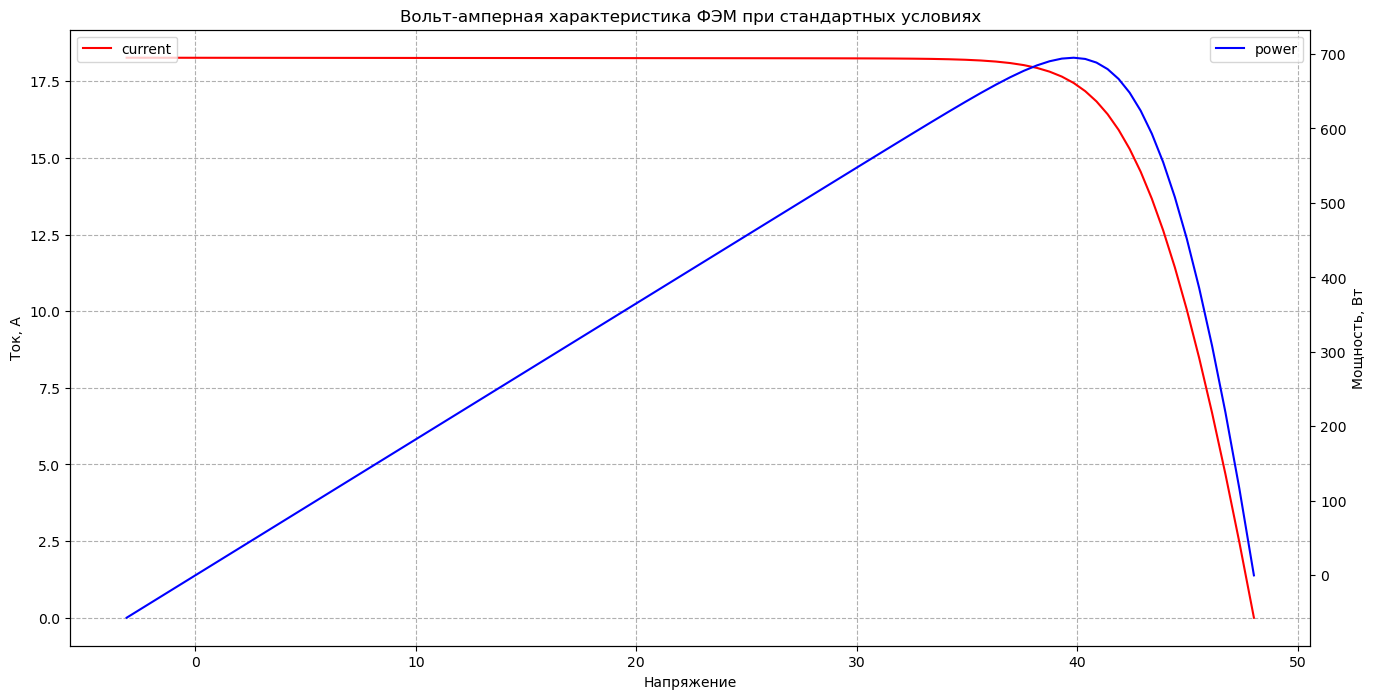

In [66]:
i = DCout_STC['i']
v = DCout_STC['v']

fig,ax = plt.subplots(figsize=(16, 8))
ax.set_title('Вольт-амперная характеристика ФЭМ при стандартных условиях')
#plt.figure(figsize=(16, 8))
ax.plot(v, i, color='red', label='current')
ax.set_xlabel('Напряжение')
ax.set_ylabel('Ток, А')
ax.legend(loc=2)
ax2 = ax.twinx ()
ax2.plot(v, i*v, color='blue', label='power')
ax2.set_ylabel('Мощность, Вт')
ax2.legend(loc=0)
ax.grid(linestyle='--')

## 4.4 Определение параметров "пользовательского" ФЭМ

In [67]:
# Смоделируем один из ФЭМ производства Хевел
# https://www.hevelsolar.com/catalog/solnechnye-moduli/hvl-445hjt/

print('ФЭМ hvl-445hjt')
print('--------------')

celltype = 'monoSi'
v_mp = 44.94
i_mp = 9.91
v_oc = 53.14
i_sc = 10.5
alpha_sc = 0.055           # %/C
alpha_sc = alpha_sc / 100  # 1/C
alpha_sc = alpha_sc * 10.5 # A/C
beta_voc = -0.244
beta_voc = beta_voc / 100 * 53.14
gamma_pmp = -0.26
cells_in_series = 144

print('Тип СЭ:                                        ', celltype)
print('Напряжение и ток в точке максимальной мощности:', v_mp, 'В,', i_mp, 'А')
print('Напряжение ХХ и ток КЗ:                        ', v_oc, 'В,', i_sc, 'А')
print('Температурный коэффициент тока КЗ:             ', round(alpha_sc, 3), 'A/C')
print('Температурный коэффициент напряжения ХХ:       ', round(beta_voc, 3), 'В/C')
print('Температурный коэффициент мощности:            ', gamma_pmp, '%/C')
print('Количество последовательно соединённых СЭ:     ', cells_in_series, 'шт.')

ФЭМ hvl-445hjt
--------------
Тип СЭ:                                         monoSi
Напряжение и ток в точке максимальной мощности: 44.94 В, 9.91 А
Напряжение ХХ и ток КЗ:                         53.14 В, 10.5 А
Температурный коэффициент тока КЗ:              0.006 A/C
Температурный коэффициент напряжения ХХ:        -0.13 В/C
Температурный коэффициент мощности:             -0.26 %/C
Количество последовательно соединённых СЭ:      144 шт.


### Функция pvlib.ivtools.sdm.fit_cec_sam

Функция `pvlib.ivtools.sdm.fit_cec_sam(celltype, v_mp, i_mp, v_oc, i_sc, alpha_sc, beta_voc, gamma_pmp, cells_in_series, temp_ref=25)` позволяет оценить параметры для однодиодной схемы замещения ФЭМ для модели CEC.


### Параметры

- `celltype` (str) – Тип солнечного элемента. Параметр может принимать одно из следующих значений: ‘monoSi’, ‘multiSi’, ‘polySi’, ‘cis’, ‘cigs’, ‘cdte’, ‘amorphous’.
- `v_mp` (float) – Напряжение в точке максимальной мощности [В]
- `i_mp` (float) – Ток в точке максимальной мощности [А]
- `v_oc` (float) – Напряжение холостого хода [В]
- `i_sc` (float) – Ток короткого замыкания [А]
- `alpha_sc` (float) – Температурный коэффициент тока короткого замыкания [А/C]
- `beta_voc` (float) – Температурный коэффициент напряжения холостого хода [В/C]
- `gamma_pmp` (float) – Температурный коэффициент мощности в точке максимальной мощности [%/C]
- `cells_in_series` (int) – Количество последовательно соединённых солнечных элементов
- `temp_ref` (float, default 25) – Температура при стандартных условиях [C]

### Результаты
- `I_L_ref` (float) – Генерируемый световой ток (или фототок) при стандартных условиях [А]
- `I_o_ref` (float) – Ток обратного насыщения диода при стандартных условиях [А]
- `R_s` (float) – Последовательное сопротивление при стандартных условиях, [Ом].
- `R_sh_ref` (float) – Шунтирующее (параллельное) сопротивление при стандартных условиях, [Ом].
- `a_ref` (float) – Произведение коэффициента идеальности диода n, количества моследовательно соединённых солнечных элементов Ns и термического напряжения солнечного элемента при стандартных условиях, [В]
- `Adjust` (float) – Корректировка температурного коэффициента для тока короткого замыкания, в процентах.

### Примечания
1. Для работы функции требуется установка модуля NREL-PySAM: pip install NREL-PySAM

2. Модель CEC и метод оценки описаны в [1]. Предполагается, что входные данные v_mp, i_mp, v_oc и i_sc получены паспортных данных при стандартных условях освещенности и температуры СЭ. При этом значение освещенности явно не используется в процедуре подбора параметров схемы замещания ФЭМ.

### Список использованных источников:
[1]  A. Dobos, “An Improved Coefficient Calculator for the California Energy Commission 6 Parameter Photovoltaic Module Model”, Journal of Solar Energy Engineering, vol 134, 2012. DOI: 10.1115/1.4005759

Фототок, А:                          10.733
Ток насыщения диода, А:              0.0
Последовательное сопротивление, Ом:  0.233
Шунтирующее сопротивление, Ом:       114.109
Коэффициент идеальности диода, о.е.: 1.828
Поправка темп. коэффициента, о.е.:   -1.47
Максимальная мощность:               445.3030690618396


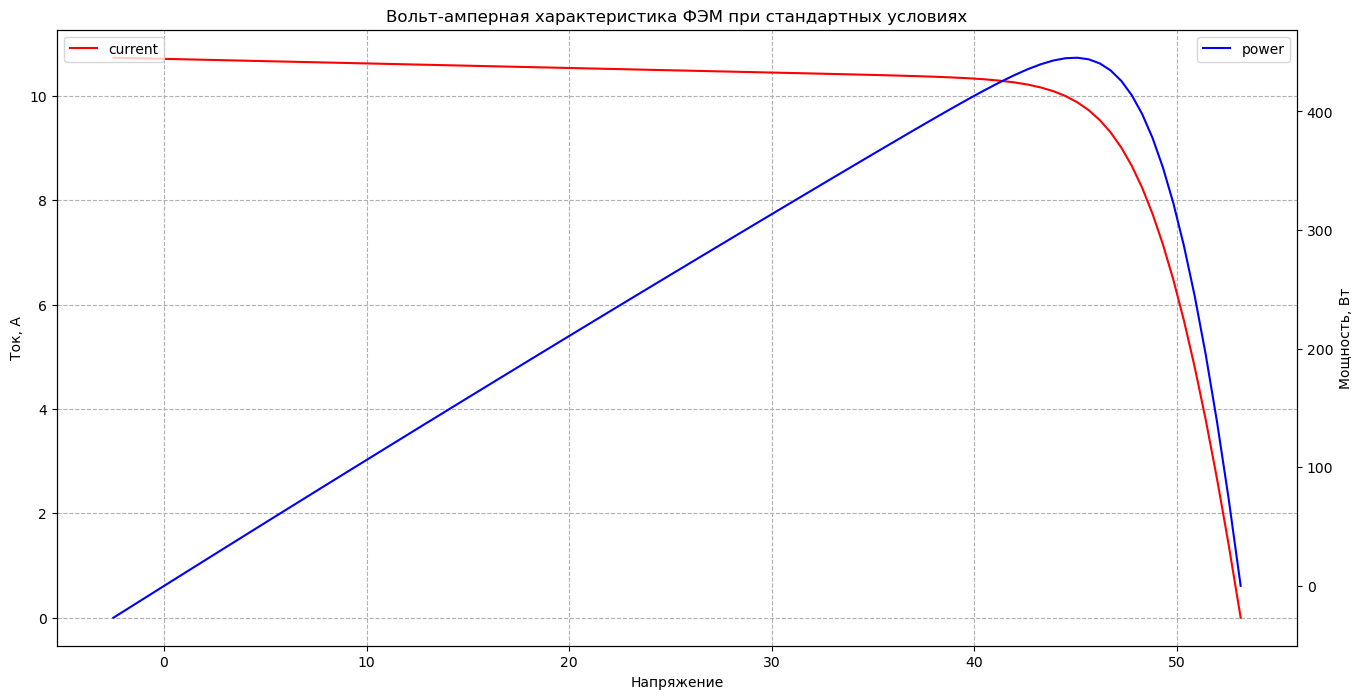

In [68]:
I_L_ref, I_o_ref, R_s, R_sh_ref, a_ref, Adjust = pvlib.ivtools.sdm.fit_cec_sam(
    celltype, 
    v_mp, 
    i_mp, 
    v_oc, 
    i_sc, 
    alpha_sc, 
    beta_voc, 
    gamma_pmp, 
    cells_in_series, 
    temp_ref=25)

print('Фототок, А:                         ', round(I_L_ref, 3))
print('Ток насыщения диода, А:             ', round(I_o_ref, 3))
print('Последовательное сопротивление, Ом: ', round(R_s, 3))
print('Шунтирующее сопротивление, Ом:      ', round(R_sh_ref, 3))
print('Коэффициент идеальности диода, о.е.:', round(a_ref, 3))
print('Поправка темп. коэффициента, о.е.:  ', round(Adjust, 3))

DCout_STC = pvlib.pvsystem.singlediode(I_L_ref, 
                           I_o_ref, 
                           R_s, 
                           R_sh_ref, 
                           a_ref, 
                           ivcurve_pnts=50, 
                           method='newton')

i = DCout_STC['i']
v = DCout_STC['v']
p = v * i
print('Максимальная мощность:              ', p.max())

fig,ax = plt.subplots(figsize=(16, 8))
ax.set_title('Вольт-амперная характеристика ФЭМ при стандартных условиях')
#plt.figure(figsize=(16, 8))
ax.plot(v, i, color='red', label='current')
ax.set_xlabel('Напряжение')
ax.set_ylabel('Ток, А')
ax.legend(loc=2)
ax2 = ax.twinx ()
ax2.plot(v, i*v, color='blue', label='power')
ax2.set_ylabel('Мощность, Вт')
ax2.legend(loc=0)
ax.grid(linestyle='--')

## 4.5 Расчёт выработки энергии единичным ФЭМ

In [69]:
# Расчёт параметров схемы замещения ФЭМ при текущих внешних условиях
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = pvlib.pvsystem.calcparams_desoto(
    pd.to_numeric(effective_irradiance), 
    pd.to_numeric(Cells_temperature_PVSYST),
    PV_Module['alpha_sc'],                      # Заданы параметры для выбранного из БД CEC ФЭМ
    PV_Module['a_ref'], 
    PV_Module['I_L_ref'], 
    PV_Module['I_o_ref'], 
    PV_Module['R_sh_ref'], 
    PV_Module['R_s'], 
    EgRef=1.121, 
    dEgdT=- 0.0002677, 
    irrad_ref=1000, 
    temp_ref=25)

# Расчёт характерных точек ВАХ ФЭМ при текущих внешних условиях
DCout = pvlib.pvsystem.singlediode(photocurrent,
                           saturation_current, 
                           resistance_series, 
                           resistance_shunt, 
                           nNsVth, 
                           ivcurve_pnts=None, 
                           method='newton')
DCout

i_sc  v_oc  i_mp  v_mp  p_mp  i_x  i_xx
2025-01-01 00:00:00+03:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2025-01-01 01:00:00+03:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2025-01-01 02:00:00+03:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2025-01-01 03:00:00+03:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2025-01-01 04:00:00+03:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
...                         ...   ...   ...   ...   ...  ...   ...
2025-12-31 19:00:00+03:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2025-12-31 20:00:00+03:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2025-12-31 21:00:00+03:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2025-12-31 22:00:00+03:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2025-12-31 23:00:00+03:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0

[8760 rows x 7 columns]

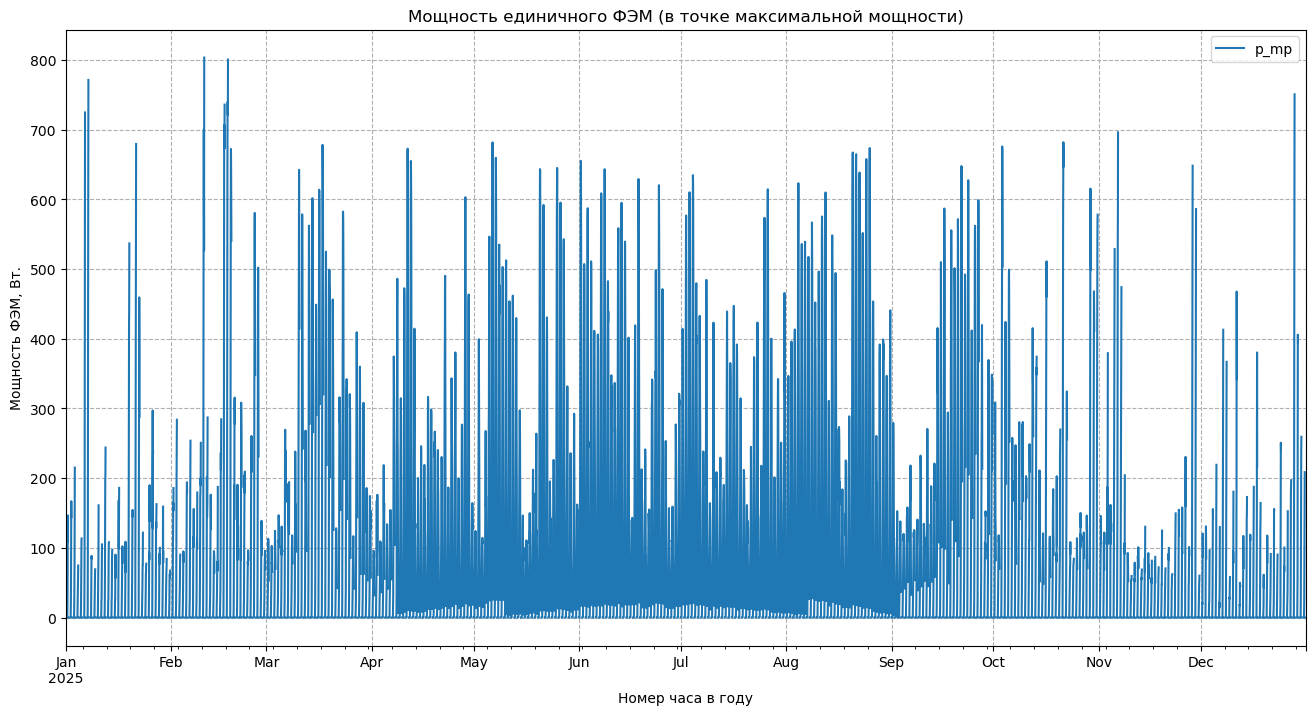

In [70]:
DCout['p_mp'].plot(figsize=(16,8), label='p_mp')
plt.legend()
plt.grid(linestyle='--')
plt.ylabel('Мощность ФЭМ, Вт.')
plt.xlabel('Номер часа в году')
plt.title('Мощность единичного ФЭМ (в точке максимальной мощности)')
plt.show()

## 4.6 Загрузка информации об инверторе
### 4.6.1 Загрузка информации из БД CEC

In [71]:
# Используем уже знакомую функцию pvlib.pvsystem.retrieve_sam

Inverters_CEC = pvlib.pvsystem.retrieve_sam(name=None, path='CEC_Inverters.csv')
Inverters_CEC

ABB__PVI_3_0_OUTD_S_US_A__208V_ ABB__PVI_3_0_OUTD_S_US_A__240V_  \
Vac                                    208                             240   
Pso                                18.1674                         16.8813   
Paco                                3000.0                          3000.0   
Pdco                                3142.3                         3121.67   
Vdco                                 310.0                           340.0   
C0                               -0.000008                       -0.000006   
C1                               -0.000011                       -0.000021   
C2                                0.000999                        0.000583   
C3                               -0.000287                       -0.000712   
Pnt                                    0.1                             0.1   
Vdcmax                               480.0                           480.0   
Idcmax                             10.1365                         9.18138   
Mppt_low                             100.0                           100.0   
Mppt_high                            480.0                           480.0   
CEC_Date                        10/15/2018                      10/15/2018   
CEC_hybrid                               N                               N   

           ABB__PVI_3_0_OUTD_S_US_A__277V_ ABB__PVI_3_0_OUTD_S_US_Z_A__208V_  \
Vac                                    277                               208   
Pso                                22.0466                           18.1674   
Paco                                3000.0                            3000.0   
Pdco                               3106.85                            3142.3   
Vdco                                 390.0                             310.0   
C0                               -0.000005                         -0.000008   
C1                               -0.000033                         -0.000011   
C2                               -0.000032                          0.000999   
C3                                -0.00118                         -0.000287   
Pnt                                    0.2                               0.1   
Vdcmax                               480.0                             480.0   
Idcmax                             7.96628                           10.1365   
Mppt_low                             100.0                             100.0   
Mppt_high                            480.0                             480.0   
CEC_Date                        10/15/2018                        10/15/2018   
CEC_hybrid                               N                                 N   

           ABB__PVI_3_0_OUTD_S_US_Z_A__240V_  \
Vac                                      240   
Pso                                  16.8813   
Paco                                  3000.0   
Pdco                                 3121.67   
Vdco                                   340.0   
C0                                 -0.000006   
C1                                 -0.000021   
C2                                  0.000583   
C3                                 -0.000712   
Pnt                                      0.1   
Vdcmax                                 480.0   
Idcmax                               9.18138   
Mppt_low                               100.0   
Mppt_high                              480.0   
CEC_Date                          10/15/2018   
CEC_hybrid                                 N   

           ABB__PVI_3_0_OUTD_S_US_Z_A__277V_  \
Vac                                      277   
Pso                                  22.0466   
Paco                                  3000.0   
Pdco                                 3106.85   
Vdco                                   390.0   
C0                                 -0.000005   
C1                                 -0.000033   
C2                                 -0.000032   
C3                                  -0.00118   
Pnt                       

In [72]:
# Простейший поиск по загруженной базе данных:

# Для удобства работы транспонируем таблицу
Inverters_CEC2 = Inverters_CEC.transpose()

# Установим в качестве индексов порядковые номера строк в таблице
Inverters_CEC2 = Inverters_CEC2.rename_axis('Name').reset_index()

# для каждой строчки в таблице выполним проверку по нескольким условиям
for i in range(len(Inverters_CEC2)):
    if Inverters_CEC2['Vac'].iloc[i] == 240: # по напряжению
        if Inverters_CEC2['Paco'].iloc[i] > 9000 and Inverters_CEC2['Paco'].iloc[i] < 12000: # по мощности инвертора
            if Inverters_CEC2['Idcmax'].iloc[i] < 24:
                print(Inverters_CEC2['Name'].iloc[i])

Fronius_International_GmbH__Fronius_Primo_10_0_1_208_240__240V_
Fronius_International_GmbH__Fronius_Primo_11_4_1_208_240__240V_
Shenzhen_Growatt_New_Energy_Co___Ltd___GROWATT_10000MTLP_US__240V_
Shenzhen_Growatt_New_Energy_Co___Ltd___GROWATT_9000MTLP_US__240V_


In [73]:
# Выберем два инвертора для рассмотрения

# Первый - с напряжением AC 240 В, мощностью от 9 до 12 кВт, макс. током DC более 36 А:
Inverter1 = Inverters_CEC['GoodWe_Technologies_Co___Ltd___GEC11_4_1U_US20__240V_']

# Второй - с напряжением AC 240 В, мощностью от 9 до 12 кВт, с макс.током DC не более 20 А:
Inverter2 = Inverters_CEC['Shenzhen_Growatt_New_Energy_Co___Ltd___GROWATT_10000MTLP_US__240V_']

In [74]:
Inverter1

Vac                240
Pso            39.3275
Paco           11391.9
Pdco           11908.6
Vdco             300.0
C0           -0.000002
C1           -0.000031
C2           -0.004393
C3             -0.0057
Pnt               5.61
Vdcmax           495.0
Idcmax         39.6954
Mppt_low         235.0
Mppt_high        495.0
CEC_Date           NaN
CEC_hybrid           N
Name: GoodWe_Technologies_Co___Ltd___GEC11_4_1U_US20__240V_, dtype: object

In [75]:
Inverter2

Vac                  240
Pso               29.932
Paco             10058.0
Pdco             10351.4
Vdco               480.0
C0             -0.000001
C1             -0.000031
C2              0.003171
C3              0.003919
Pnt                  3.5
Vdcmax             550.0
Idcmax           21.5655
Mppt_low           330.0
Mppt_high          550.0
CEC_Date      10/15/2018
CEC_hybrid             N
Name: Shenzhen_Growatt_New_Energy_Co___Ltd___GROWATT_10000MTLP_US__240V_, dtype: object

### 4.6.2 Загрузка характеристик "пользовательского" инвертора

In [76]:
# Для примера рассмотрим загрузку информации об инверторе SMA SUNNY TRIPOWER 12000TL:
# https://files.sma.de/downloads/STP12000TL-DEN1723-V10web.pdf

# Рабочие характеристики заданы в CSV-файле для трёх уровней напряжения DC
SMA_12000TL = pd.read_csv('SMA_12000TL.csv', sep=';', header=0)
SMA_12000TL

ac_power  dc_power  dc_voltage dc_voltage_level
0       1200      1240         440             Vmin
1       2400      2469         440             Vmin
2       3600      3700         440             Vmin
3       6000      6179         440             Vmin
4       9000      9336         440             Vmin
5      12000     12448         440             Vmin
6       1200      1232         580             Vnom
7       2400      2447         580             Vnom
8       3600      3666         580             Vnom
9       6000      6116         580             Vnom
10      9000      9211         580             Vnom
11     12000     12320         580             Vnom
12      1200      1253         800             Vmax
13      2400      2472         800             Vmax
14      3600      3696         800             Vmax
15      6000      6148         800             Vmax
16      9000      9240         800             Vmax
17     12000     12371         800             Vmax

In [77]:
# Номинальна мощность инвертора со стороны переменного тока, Вт
p_ac_0 = 12000
# Мощность, потребляемая инвертором в режиме ожидания, Вт
p_nt = 1

Функция `pvlib.inverter.fit_sandia(ac_power, dc_power, dc_voltage, dc_voltage_level, p_ac_0, p_nt)` позволяет определить параметры математической модели инвертора Sandia.

### Параметры
- ac_power (array_like) – Значения выходной AC мощности в каждой точке характеристики [Вт].
- dc_power (array_like) – Значения входной DC мощности в каждой точке характеристики [Вт].
- dc_voltage (array_like) – Значение DC напряжения в каждой точке характеритсики [В].
- dc_voltage_level (array_like) – Уровень DC напряжения в каждой точке характеристики - параметр может принимать значения ‘Vmin’, ‘Vnom’ or ‘Vmax’.
- p_ac_0 (float) – Номинальная мощность инвертора со стороны переменного тока [Вт].
- p_nt (float) – Потребляемая в режиме ожидания мощность, [Вт]

### Результаты
dict – Набор параметров для модели инвертора по модели Sandia [1]. Описание параметров и значений смотрите в описании функции `pvlib.inverter.sandia()`.

### Примечания
- Процедура подбора параметров инвертора описана [2]. 
- Каждая точка данных представляет собой пару значений (dc_power, ac_power). 
- Как правило, эффективность инвертора в зависисмости от уровня выходной мощности определется при трёх уровнях входного напряжения постоянного тока, обозначаемых "Vmin", "Vnom" и "Vmax". Протокол  тестирования инверторов CEC [3] определяет измерение входной мощности постоянного тока, которая обеспечивает выходную мощность переменного тока, равную 0,1, 0,2, 0,3, 0,5, 0,75 и 1,0 от номинальной мощности переменного тока инвертора.


### Список использованных источников:

[1] D. King, S. Gonzalez, G. Galbraith, W. Boyson, “Performance Model for Grid-Connected Photovoltaic Inverters”, SAND2007-5036, Sandia National Laboratories.

[2] Sandia Inverter Model page, PV Performance Modeling Collaborative https://pvpmc.sandia.gov/modeling-steps/dc-to-ac-conversion/sandia-inverter-model/

[3] W. Bower, et al., “Performance Test Protocol for Evaluating Inverters Used in Grid-Connected Photovoltaic Systems”, available at https://www.energy.ca.gov/sites/default/files/2020-06/2004-11-22_Sandia_Test_Protocol_ada.pdf

In [78]:
Inverter_SMA = pvlib.inverter.fit_sandia(
    SMA_12000TL['ac_power'], 
    SMA_12000TL['dc_power'], 
    SMA_12000TL['dc_voltage'], 
    SMA_12000TL['dc_voltage_level'], 
    p_ac_0, 
    p_nt)
Inverter_SMA

C:\Users\vag\anaconda3\lib\site-packages\pvlib\inverter.py:535: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  coeffs['a'][d] = a
C:\Users\vag\anaconda3\lib\site-packages\pvlib\inverter.py:536: FutureWarning: ChainedAssignmentError: behaviour

{'Paco': 12000,
 'Pdco': 12387.809920772852,
 'Vdco': 580.0,
 'Pso': 18.284484231219817,
 'C0': -1.2122764614768104e-06,
 'C1': -1.6219229716370046e-05,
 'C2': 0.00634386509865596,
 'C3': 0.0012580489090851083,
 'Pnt': 1}

## 4.7 Определение схемы соединения ФЭМ внутри батареи ФЭМ

In [79]:
# Максимальное напряжение холостого хода, которое может быть на единичном ФЭМ
VOC_max = max(DCout['v_oc'].max(), PV_Module['V_oc_ref'])
print('Максимальное напряжение ХХ ФЭМ, В', round(VOC_max,2))
print()

# Максимальное допустимое DC напряжение на входе инвертора
V_inv_max1 = Inverter1['Vdcmax']
V_inv_max2 = Inverter2['Vdcmax']
V_inv_max3 = SMA_12000TL['dc_voltage'].max()
print('Максимальное DC напряжение инвертора 1, В:', V_inv_max1)
print('Максимальное DC напряжение инвертора 2, В:', V_inv_max2)
print('Максимальное DC напряжение инвертора 3, В:', V_inv_max3)
print()

# Количество последовательно соединённых ФЭМ
N1 = math.modf(V_inv_max1 / VOC_max) # Округлённое до ближайшего меньшего целого
N1 = int(N1[1])
N2 = math.modf(V_inv_max2 / VOC_max)
N2 = int(N2[1])
N3 = math.modf(V_inv_max3 / VOC_max)
N3 = int(N3[1])

print('К инвертору 1 можно подключить', N1, 'ФЭМ, соединённых последовательно.')
print('К инвертору 2 можно подключить', N2, 'ФЭМ, соединённых последовательно.')
print('К инвертору 3 можно подключить', N3, 'ФЭМ, соединённых последовательно.')

Максимальное напряжение ХХ ФЭМ, В 51.56

Максимальное DC напряжение инвертора 1, В: 495.0
Максимальное DC напряжение инвертора 2, В: 550.0
Максимальное DC напряжение инвертора 3, В: 800

К инвертору 1 можно подключить 9 ФЭМ, соединённых последовательно.
К инвертору 2 можно подключить 10 ФЭМ, соединённых последовательно.
К инвертору 3 можно подключить 15 ФЭМ, соединённых последовательно.


In [80]:
# Максимальное значение тока короткого замыкания, которое может быть на единичном ФЭМ
ISC_max = max(DCout['i_sc'].max(), PV_Module['I_sc_ref'])
print('Максимальный ток КЗ ФЭМ, А', round(ISC_max,2))
print()

# Максимальное допустимое значение DC тока на входе инвертора
I_inv_max1 = Inverter1['Idcmax']
I_inv_max2 = Inverter2['Idcmax']
I_inv_max3 = Inverter_SMA['Pdco'] / SMA_12000TL['dc_voltage'].min()
print('Максимальный DC ток инвертора 1, А:', I_inv_max1)
print('Максимальный DC ток инвертора 2, А:', I_inv_max2)
print('Максимальный DC ток инвертора 3, А:', round(I_inv_max3,4))
print()

# Количество параллельно соединённых цепочек ФЭМ
M1 = math.modf(I_inv_max1 / ISC_max) # Округлённое до ближайшего меньшего целого
M1 = int(M1[1])
M2 = math.modf(I_inv_max2 / ISC_max)
M2 = int(M2[1])
M3 = math.modf(I_inv_max3 / ISC_max)
M3 = int(M3[1])

print('К инвертору 1 можно подключить', M1, 'параллельных цепочек ФЭМ.')
print('К инвертору 2 можно подключить', M2, 'параллельных цепочек ФЭМ.')
print('К инвертору 3 можно подключить', M3, 'параллельных цепочек ФЭМ.')

Максимальный ток КЗ ФЭМ, А 21.22

Максимальный DC ток инвертора 1, А: 39.6954
Максимальный DC ток инвертора 2, А: 21.5655
Максимальный DC ток инвертора 3, А: 28.1541

К инвертору 1 можно подключить 1 параллельных цепочек ФЭМ.
К инвертору 2 можно подключить 1 параллельных цепочек ФЭМ.
К инвертору 3 можно подключить 1 параллельных цепочек ФЭМ.


In [81]:
# Для памяти посмотрим на значение пиковой мощности рассматриваемого ФЭМ
print('Пиковая мощность единичного ФЭМ, Вт:', PV_Module['STC'])

# Пиковая мощность батареи рассматриваемых ФЭМ, которую мощно подключить к конкретному инвертору
PVbattery1 = M1 * N1 * PV_Module['STC']
PVbattery2 = M2 * N2 * PV_Module['STC']
PVbattery3 = M3 * N3 * PV_Module['STC']
print('Мощность батареи ФЭМ, подключённой к инвертору 1, Вт', round(PVbattery1, 1))
print('Мощность батареи ФЭМ, подключённой к инвертору 2, Вт', round(PVbattery2, 1))
print('Мощность батареи ФЭМ, подключённой к инвертору 3, Вт', round(PVbattery3, 1))
print()

# Коэффициент загрузки инвертора
print('Коэффициент загрузки инвертора должен лежать в пределах 0,85...1,25 (рекомендуется, чтобы)')
print('он был близок к 1,0:')
print('   Коэффициент загрузки инвертора 1, о.е.:', round(PVbattery1 / Inverter1['Pdco'], 3))
print('   Коэффициент загрузки инвертора 2, о.е.:', round(PVbattery2 / Inverter2['Pdco'], 3))
print('   Коэффициент загрузки инвертора 3, о.е.:', round(PVbattery3 / Inverter_SMA['Pdco'], 3))

Пиковая мощность единичного ФЭМ, Вт: 694.908
Мощность батареи ФЭМ, подключённой к инвертору 1, Вт 6254.2
Мощность батареи ФЭМ, подключённой к инвертору 2, Вт 6949.1
Мощность батареи ФЭМ, подключённой к инвертору 3, Вт 10423.6

Коэффициент загрузки инвертора должен лежать в пределах 0,85...1,25 (рекомендуется, чтобы)
он был близок к 1,0:
   Коэффициент загрузки инвертора 1, о.е.: 0.525
   Коэффициент загрузки инвертора 2, о.е.: 0.671
   Коэффициент загрузки инвертора 3, о.е.: 0.841


## 4.8 Определение выработки энергии со стороны переменного тока

Функция ``pvlib.inverter.sandia(v_dc, p_dc, inverter)`` преобразует постоянный ток и напряжение в переменный ток, используя модель фотоэлектрического сетевого инвертора Sandia.
Выходная мощность со стороны переменного тока инвертора определяется с учетом напряжения постоянного тока, мощности постоянного тока и соответствующих параметров модели фотоэлектрического преобразователя, подключенного к сети. Выходная мощность ac_power ограничивается максимальной выходной мощностью и дает отрицательную мощность в условиях низкой входной мощности, но НЕ учитывает окна максимального напряжения отслеживания точки питания, а также максимальный ток или пределы напряжения на инверторе.
   
## Параметры:
- ``v_dc`` (numeric) – Напряжения со стороны постоянного тока на входе инвертора, (В). v_dc должно быть >= 0.
- ``p_dc`` (numeric) – Скаляр или DataFrame мощностей постоянного тока на входе инвертора, (Вт). p_dc должно быть >= 0.
- ``inverter`` (dict-like) – параметры инвертора, определяющие его рабочие характеристики в соответствии с моделью сетевого инвертора Sandia (SAND 2007-5036) [1]. Выше приведено описание используемых параметров инвертора.

## Результаты:	
- ``ac_power`` (numeric) – Смоделированные значения выходной мощности со стороны переменного тока, (Вт).

## Примечания
      * Если ac_power будет больше, чем Pac0, выходная мощность будет ограничена на уровне Pac0.
      * Если ac_power будет меньше, чем Ps0 (требуется мощность для запуска инвертора), то ac_power устанавливается на -1 * abs (Pnt) для моделирования потерь мощности в ночной период времени.
      * ac_power не ограничивается в диапазоне точки максимальной мощности и в пределах максимального тока инвертора.

    
## Использованные источники:

[1]	SAND2007-5036, “Performance Model for Grid-Connected Photovoltaic Inverters by D. King, S. Gonzalez, G. Galbraith, W. Boyson

[2]	System Advisor Model web page. https://sam.nrel.gov.

In [82]:
# Рассмотрим один из вариантов состава оборудрвания СЭС:
N = N3
M = M3
inverter = Inverter_SMA

In [83]:
# Напряжение батареи ФЭМ
v_dc = DCout['v_mp'] * N
# Мощность батареи ФЭМ
p_dc = DCout['p_mp'] * N * M

# Определение выработки электроэнергии со стороны переменного тока инвертора
ACout = pvlib.inverter.sandia(
    v_dc, 
    p_dc, 
    inverter)

In [84]:
print('Годовая выработка энергии в сеть, МВтч', round(ACout.sum()/1000000, 3))
print('Годовая выработка энергии батареей ФЭМ, МВтч', round(p_dc.sum()/1000000, 3))
print()
print('Коэффициент использования установленной мощности AC, %:', round(ACout.sum()/(inverter['Paco']*8760)*100, 2))
print('Коэффициент использования установленной мощности DC, %:', round(p_dc.sum()/(PV_Module['STC']*N*M*8760)*100, 2))

Годовая выработка энергии в сеть, МВтч 10.684
Годовая выработка энергии батареей ФЭМ, МВтч 10.996

Коэффициент использования установленной мощности AC, %: 10.16
Коэффициент использования установленной мощности DC, %: 12.04


## 4.9 Определение выработки энергии с учётом потерь энергии

In [85]:
# Создадим dataframe, в котором будут результаты расчёта различного вида потерь энергии:
# Far shading - 0 (если Солнце за профилем горизонта), 1 - если Солнце не закрыто и светит на ФЭМ
#

LOSS = pd.DataFrame(columns=['time', 'Far shading', 'Self-shading factor', 'ReductionFactor', 'Shading loss', 'Eloss', 'DCout_with_loss'])
LOSS['time'] = times_loc

### 4.9.1 Дальнее затенение

In [86]:
# Данные о "профиле горизонта" хранятся в отдельном csv-файле
# Формат файла - два столбца [azimuth] и [elevation], соответствующих угловой высоте объекта,
# который расположен на указанном азимуте
#
horizon_profile = pd.read_csv('Horizon.csv', sep=';', header=0)

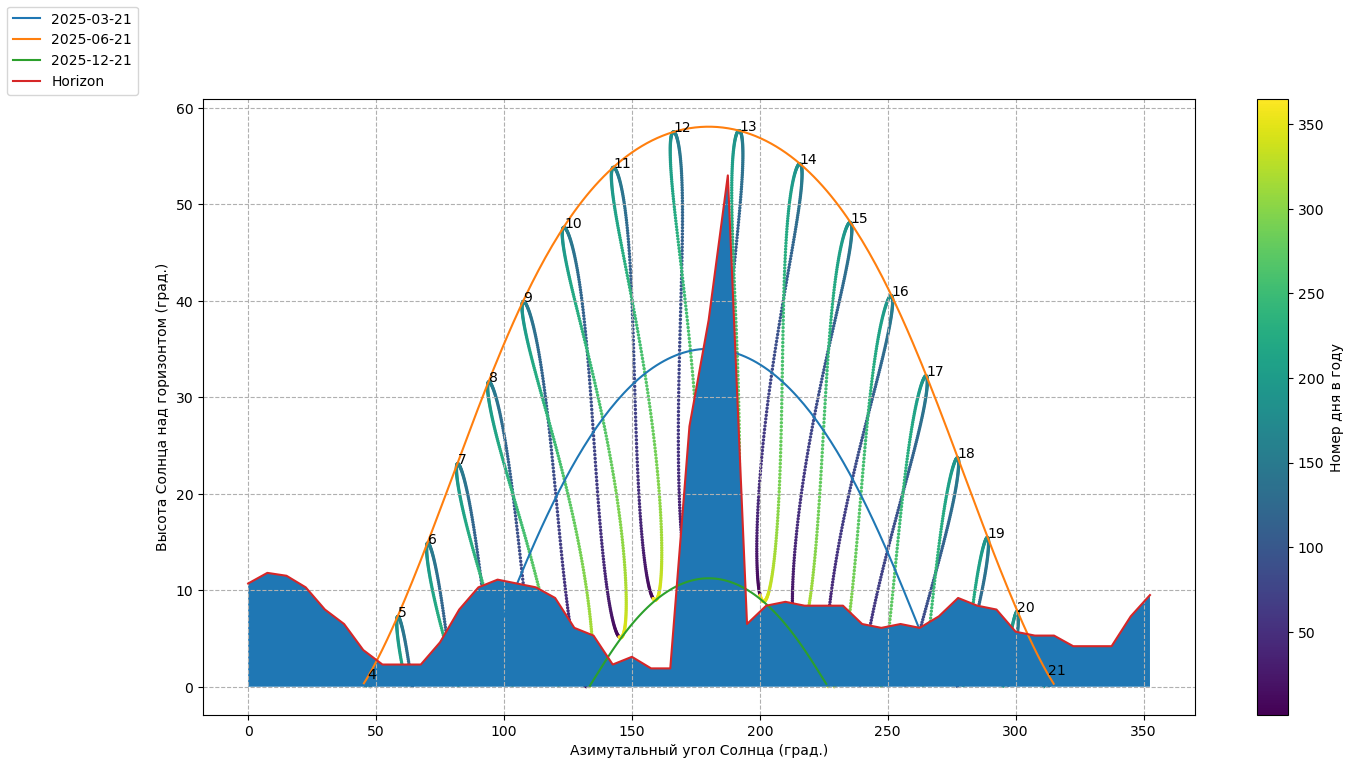

In [87]:
# Удалим ночной период времени (когда Солнце находится под горизонтом)
solpos = SPA.loc[SPA['apparent_elevation'] > 0, :]

# Будем строить несколько графиков, общий размер поля построения - 16х8
fig, ax = plt.subplots(figsize=(16, 8))

# построим "точечный" график - зависимость высоты Солнца над горизонтом от азимутального угла
points = ax.scatter(solpos.azimuth, solpos.apparent_elevation, s=2, c=solpos.index.dayofyear, label=None)
fig.colorbar(points, label='Номер дня в году')

# Подпись номера часа к каждой аналлеме
for hour in np.unique(solpos.index.hour):
    # Определим позицию подписи по наибольшей высоте Солнца над гориднтом доля каждого часа
    subset = solpos.loc[solpos.index.hour == hour, :]
    height = subset.apparent_elevation
    pos = solpos.loc[height.idxmax(), :]
    ax.text(pos['azimuth'], pos['apparent_elevation'], str(hour))

# Построение графиков изменения положения Cолнца в течение дня (для характерных дней года)
for date in pd.to_datetime(['2025-03-21', '2025-06-21', '2025-12-21']):
    times = pd.date_range(date, date+pd.Timedelta('24h'), freq='5min', tz=A.tz)
    solpos = pvlib.solarposition.spa_python(times, 
                                     A.latitude, 
                                     A.longitude, 
                                     altitude=A.altitude)
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    label = date.strftime('%Y-%m-%d')
    ax.plot(solpos.azimuth, solpos.apparent_elevation, label=label)

# Отобразим на графике форму горизонта
ax.plot(horizon_profile['azimuth'], horizon_profile['elevation'], label='Horizon')
# Для красоты закрасим пространство под графиком
ax.fill_between(horizon_profile['azimuth'], horizon_profile['elevation'])

# Покажем легенду, установим подписи осей и сетку
ax.figure.legend(loc='upper left')
ax.set_xlabel('Азимутальный угол Солнца (град.)')
ax.set_ylabel('Высота Солнца над горизонтом (град.)')
plt.grid(linestyle='--')

plt.show()

In [88]:
# Определение наличия дальнего затенения:
# Если угловая высота Солнца меньше высоты профиля горизонта на рассматриваемом азимуте, то
# дальнее затенение есть и Far shading = 0
# в противном случае - Far shading = 1
# В дальнейшем можно будет умножать приход СИ на значение Far shading и учитывать таким образом наличие или отсутствие 
# дальнего затенения.
# Примечание: не учитывается наличие диффузной составляющей СИ

for i in range(len(LOSS)):
    sol_az = SPA['azimuth'].iloc[i]
    sol_el = SPA['apparent_elevation'].iloc[i]
    for j in range(len(horizon_profile)-1):
        hor_el = horizon_profile['elevation'].iloc[j]
        hor_az1 = horizon_profile['azimuth'].iloc[j]
        hor_az2 = horizon_profile['azimuth'].iloc[j+1]
        if sol_az >= hor_az1 and sol_az <= hor_az2:
            if sol_el < hor_el:
                LOSS.loc[i, 'Far shading'] = 0
            else:
                LOSS.loc[i, 'Far shading'] = 1

### 4.9.2 Самозатенение
В основу расчёта легли две статьи:
1. https://minesparis-psl.hal.science/hal-02113798/document
Формулы (5) и (6) позволяют оценить долю площади поверхности ФЭМ, которая затенена.
2. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5614450
Простая модель, позволяющая оценить насколько снизится мощность ФЭМ, у которого затенена часть поверхности

In [89]:
# Азимут установки ФЭМ
alpha_P = math.radians(180)
# Угол наклона поверхности ФЭМ к горизонту
gamma_P = math.radians(surface_tilt)
# Длина стола ФЭМ
L = 2

# GCR (Ground coverage Ratio) - Коэффициент покрытия поверхности земли (показывает долю земельного участка СЭС, занятую непосредственно ФЭМ)
GCR = 0.25

R = L / GCR # Расстояние между рядами
s = L * (1 / GCR - math.cos(gamma_P)) # Ширина прохода между рядами

print('>>>                               GCR =', GCR)
print('При длине стола                      L=', round(L, 2), 'м')
print('Расстояние между рядами ФЭМ составит R=', round(R, 2), 'м')
print('Проход между рядами                  s=', round(s, 2), 'м')

>>>                               GCR = 0.25
При длине стола                      L= 2 м
Расстояние между рядами ФЭМ составит R= 8.0 м
Проход между рядами                  s= 6.74 м


In [90]:
for i in range(len(LOSS)):
    # Азимутальный угол Солнца
    alpha_S = SPA['azimuth'].iloc[i]
    alpha_S = math.radians(alpha_S)
    # Высота Солнца над горизонтом
    gamma_S = SPA['apparent_elevation'].iloc[i]
    gamma_S = math.radians(gamma_S)
    # См. формулу (6) из [1]
    if abs(gamma_S - gamma_P) < math.pi/2:
        OA = L * math.sin(gamma_P) / math.tan(gamma_S)
        OE = s / math.cos(alpha_S - alpha_P - math.pi)
        OC = L * math.cos(gamma_P) / math.cos(alpha_S - alpha_P - math.pi)
        fshading = (abs(OA) - abs(OE)) / (abs(OA) + abs(OC))
    elif gamma_S < 0 or abs(gamma_S - gamma_P) >= math.pi/2:
        fshading = 0
    else:
        fshading = 0
    if fshading < 0:
        fshading = 0
    LOSS.loc[i, 'Self-shading factor'] = fshading

In [91]:
# расчёт коэффициента снижения мощности ФЭМ при частичном затенеии (см. формулу 2 из [1])
for i in range(len(LOSS)):
    ReductionFactor = min(1, max(0, 1 - LOSS['Self-shading factor'].iloc[i])) * 0.94 + 0.06
    LOSS.loc[i, 'ReductionFactor'] = ReductionFactor

In [92]:
# Расчёт величины потерь энергии от дальнего и ближнего затенения
LOSS['Shading loss'] = DCout['p_mp'].values * (1 - LOSS['Far shading'].values * LOSS['ReductionFactor'].values)

### 4.9.3 Расчёт омических потерь

In [93]:
# Максимальная допустимая величина потерь (%)
dc_ohmic_percent = 4

Rw = pvlib.pvsystem.dc_ohms_from_percent(
    PV_Module['V_mp_ref'], 
    PV_Module['I_mp_ref'], 
    dc_ohmic_percent, 
    modules_per_string=N, 
    strings=M)

print('Эквивалентное сопротивление', Rw)

LOSS['Eloss'] = Rw * DCout['i_mp'].values**2 * M

Эквивалентное сопротивление 1.3676975945017182


### 4.9.4 Итоговая величина потерь энергии (для единичного ФЭМ)

In [94]:
LOSS['DCout_with_loss'] = DCout['p_mp'].values - LOSS['Shading loss'].values - LOSS['Eloss'].values
LOSS[LOSS['DCout_with_loss'] < 0] = 0

C:\Users\vag\AppData\Local\Temp\ipykernel_14828\892177140.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns, Europe/Moscow], please explicitly cast to a compatible dtype first.
  LOSS[LOSS['DCout_with_loss'] < 0] = 0


In [95]:
print('Общая велична потерь энергии за год, кВтч:', round((LOSS['Shading loss'].sum() + LOSS['Eloss'].sum())/1000, 3))
print('Потери энергии составляют', round((LOSS['Shading loss'].sum() + LOSS['Eloss'].sum())/DCout['p_mp'].sum()*100, 2), '% от выработки электроэнергии')

Общая велична потерь энергии за год, кВтч: 185.145
Потери энергии составляют 25.26 % от выработки электроэнергии
